In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from tqdm.auto import tqdm
import pingouin as pg
import warnings


warnings.filterwarnings("ignore")

sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={"figure.figsize": (10, 7)}
)

### Data Analyst (Karpov Courses)

## Проект: вариант 3

Представьте, что вы работаете в крупном дейтинговом приложении.

Помимо базовых функций, в приложении также имеется премиум-подписка, которая дает доступ к ряду важных дополнительных возможностей. Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы. При этом стоимость пробного периода оставалась прежней.

#### Надо проверить:

#### 1) Был ли эксперимент успешен в целом.

#### 2) Проанализируйте, имеет ли нововведение смысл среди каких-либо конкретных групп пользователей.

*Деньги за подписку списываются ежемесячно до тех пор, пока пользователь её не отменит.

## Данные
Всего есть три группы: тестовая (test), контрольная 1 (control_1) и контрольная 2 (control_2). Для каждой из них:

**users_*.csv** – информация о пользователях:

- **uid** – идентификатор пользователя
- **age** – возраст
- **attraction_coeff** – коэффициент привлекательности (от 0 до 1000, $\frac{лайки}{просмотры}*1000$)
- **coins** – число монеток (внутренняя валюта)
- **country** – страна  
- **visit_days** – в какие дни после регистрации пользователь посещал приложение (напр. в 1, затем в 7)
- **gender** – пол
- **age_filter_start**  – фильтр поиска, мин. значение 
- **age_filter_end**  – фильтр поиска, макс. значение 
- **views_count** – число полученных оценок 
- **was_premium** – был ли когда-либо премиум (либо пробный период премиум-статуса, либо купленный за деньги)
- **is_premium** –  является ли премиум
- **total_revenue** – нормированная выручка
 
**transactions_*.csv** – информация о платежах пользователей:

- **uid** – идентификатор пользователя
- **country** – страна
- **joined_at** – дата и время регистрации
- **paid_at** – дата и время покупки
- **revenue** – нормированная выручка
- **payment_id** – идентификатор платежа
- **from_page** – откуда пользователь перешел на страницу оплаты
- **product_type** – тип продукта (trial_premium – пробная премиум-подписка, premium_no_trial – премиум-подписка без пробной, coins – подписка за внутреннюю валюту, other_type – другое)
 
#### Файлы:

- **users_test** – информация о пользователях в тестовой группе. 
- **users_control_1** – информация о пользователях в первой контрольной группе. 
- **users_control_2** – информация о пользователях во второй контрольной группе . 
- **transactions_test** – информация о платежах пользователей в тестовой группе. 
- **transactions_control_1** – информация о платежах пользователей в первой контрольной группе. 
- **transactions_control_2** – информация о платежах пользователей во второй контрольной группе 

# Functions

In [2]:
def get_data_descr(df):
    """
    Функция, которая дает небольшой обзор по датафрейму
    """
    print("Первые 5 строк датафрейма:")
    display(df.head())
    print("- " * 50, "\n")
    print("Тип данных каждого столбца:")
    display(df.dtypes.to_frame())
    print("- " * 50, "\n")
    print("Количество nan значений по каждому столбцу:")
    display(df.isna().sum().to_frame())
    print("- " * 50, "\n")
    print("Размер датафрейма:")
    print(f"{df.shape[0]} строк\n{df.shape[1]} столбцов\n")
    print("- " * 50, "\n")


def get_for_outliers(col):
    """
    Функция для выделени интервалов для удаления выбросов,
    Считается 2 и 3 квартили, затем откладываются 1.5 межквартильных 
    размахов от второго квартиля в меньшую сторону и от третьего квартиля 
    в большую сторону
    """
    q1 = np.quantile(col, 0.25)
    q3 = np.quantile(col, 0.75)
    b1 = q1 - (q3 - q1) * 1.5 
    b2 = q3 + (q3 - q1) * 1.5
    
    return b1, b2


def del_outliers(df, col):
    """
    Удаляем выбросы с помощью функции get_for_outliers
    """
    low, up = get_for_outliers(df[col])
    res = df[(low <= df[col]) & (up >= df[col])].copy()
    
    return res


def make_hist(df_control_1, df_control_2, df_test, col, size=(15, 15)):
    """
    Построение 3х гистаграм для количественного признака, 
    для 2х control и одной test групп 
    """
    fig, axs = plt.subplots(3, 1, figsize=size)
    plt.subplots_adjust(hspace=0.5)
    ax1 = sns.histplot(x=col, data=df_control_1, color="red", bins=50, ax=axs[0])
    ax1.set(title="control_1")
    ax2 = sns.histplot(x=col, data=df_control_2, color="olive", bins=50, ax=axs[1])
    ax2.set(title="control_2")
    ax3 = sns.histplot(x=col, data=df_test, color="green", bins=50, ax=axs[2])
    ax3.set(title="test")
    
    plt.show()


def make_countplot(df_control_1, df_control_2, df_test, col, size=(15, 15), del_d=True):
    """
    Построение 3х countplot для классового признака, 
    для 2х control и одной test групп, с удалением 
    дубликатов uid
    """
    fig, axs = plt.subplots(3, 1, figsize=size)
    plt.subplots_adjust(hspace=0.5)
    
    if del_d:
        order_1 = df_control_1.drop_duplicates(subset=["uid"])[col].value_counts().index
        order_2 = df_control_2.drop_duplicates(subset=["uid"])[col].value_counts().index
        order_3 = df_test.drop_duplicates(subset=["uid"])[col].value_counts().index
    else:
        order_1 = df_control_1[col].value_counts().index
        order_2 = df_control_2[col].value_counts().index
        order_3 = df_test[col].value_counts().index        
    
    ax1 = sns.countplot(y=col, data=df_control_1, order=order_1, ax=axs[0])
    ax1.set(title="control_1")
    
    ax2 = sns.countplot(y=col, data=df_control_2, order=order_2, ax=axs[1])
    ax2.set(title="control_2")
    
    ax3 = sns.countplot(y=col, data=df_test, order=order_3, ax=axs[2])
    ax3.set(title="test")
    
    plt.show()


def get_bootstrap(
    *args,  # Данные
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95,  # уровень значимости
    vis=True  # Нужна ли визуализация
):
    """
    Данная функция взята из лекции 9го урока по статистике 
    про 'BOOTSTRAP КАК МЕТОД ПРОВЕРКИ СТАТИСТИЧЕСКИХ ГИПОТЕЗ',
    только немного изменена.
    """
    boot_data = []
    
    it_data = tqdm(range(boot_it)) if vis else range(boot_it)
    
    if len(args) == 2:
        
        data_column_1, data_column_2 = args
        
        for i in it_data:  # извлекаем подвыборки
            samples_1 = np.random.choice(data_column_1, 
                                         size=len(data_column_1), 
                                         replace=True)
            
            samples_2 = np.random.choice(data_column_2, 
                                         size=len(data_column_2), 
                                         replace=True)
            
            boot_data.append(statistic(samples_2) - statistic(samples_1))
    
    elif len(args) == 4:
        
        data_u_1, data_t_1, data_u_2, data_t_2 = args
        
        # Получаем все id юзеров
        uid_1 = data_u_1.uid.unique()
        uid_2 = data_u_2.uid.unique()
                
        boot_data = []
        for i in it_data:  # извлекаем подвыборки
            
            # Сэмплируемся с возвращением
            samples_1 = np.random.choice(uid_1, size=len(uid_1), replace=True)
            samples_2 = np.random.choice(uid_1, size=len(uid_2), replace=True)
            
            # Оставляем только уникальные значения
            samples_1 = np.unique(samples_1)
            samples_2 = np.unique(samples_2)
            
            cnt_users_1 = samples_1.shape[0]
            cnt_users_2 = samples_2.shape[0]        
            
            # Получаем количество транзакций
            cnt_trans_1 = data_t_1[data_t_1.uid.isin(samples_1)].shape[0]
            cnt_trans_2 = data_t_2[data_t_2.uid.isin(samples_2)].shape[0]
            
            boot_data.append((cnt_trans_2 / cnt_users_2) - (cnt_trans_1 / cnt_users_1))        

    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    if vis:
        _, _, bars = plt.hist(pd_boot_data[0], bins=50)
        for bar in bars:
            if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
                bar.set_facecolor("red")
            else: 
                bar.set_facecolor("grey")
                bar.set_edgecolor("black")
        
        plt.style.use("ggplot")
        plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
        plt.xlabel("boot_data")
        plt.ylabel("frequency")
        plt.title("Histogram of boot_data")
        plt.show()
       
    return {"quants": quants, 
            "bt_p_value": p_value}


def get_res_test_bootstrap(
    *args,  # Данные
    list_of_gr=[],  # список стран
    col=None,  # признак который будем исследовать
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    """
    Данная функция позволяет оценить метрику бустингом для подгрупп
    """
  
    len_lst = len(list_of_gr)
    res_tests = []
    
    # Для обычного бутстрапа для оценки среднего
    if len(args) == 2 and col is not None:
        
        df_1, df_2 = args
        
        for i in tqdm(range(len_lst)):
            
            df_cur_1 = df_1[df_1["country"] == list_of_gr[i]]
            df_cur_2 = df_2[df_2["country"] == list_of_gr[i]]
            
            cur_val = get_bootstrap(df_cur_1[col], df_cur_2[col], vis=False)
            
            res_tests.append([list_of_gr[i], 
                              cur_val["bt_p_value"], 
                              cur_val["quants"].iloc[0, 0],
                              cur_val["quants"].iloc[1, 0],
                              int(cur_val["bt_p_value"] < 0.05)])
    
    # Бустрап для оценки конверсии
    elif len(args) == 4:
        
        data_u_1, data_t_1, data_u_2, data_t_2 = args
        
        for i in tqdm(range(len_lst)):
            
            df_cur_1 = data_u_1[data_u_1["country"] == list_of_gr[i]]
            df_cur_2 = data_u_2[data_u_2["country"] == list_of_gr[i]]
            
            cur_val = get_bootstrap(df_cur_1, data_t_1, 
                                    df_cur_2, data_t_2, vis=False)
            
            res_tests.append([list_of_gr[i], 
                              cur_val["bt_p_value"], 
                              cur_val["quants"].iloc[0, 0],
                              cur_val["quants"].iloc[1, 0],
                              int(cur_val["bt_p_value"] < 0.05)])        
    
    return pd.DataFrame(columns=["country", "bt_p_value", "0.025", "0.0975", "bt_has_effect"],
                        data=res_tests)


def get_t_test(data_1, data_2, altr="two-sided"):
    
    """
    Полный сценарий оценки средних по t-test
    
    ttest_ind(a, b, ...)
    
    Defines the alternative hypothesis:
    two-sided: the means of the distributions underlying the samples are unequal.
    
    less: the mean of the distribution underlying the first sample is less than 
    the mean of the distribution underlying the second sample.
    
    greater: the mean of the distribution underlying the first sample is greater 
    than the mean of the distribution underlying the second sample.
        
    equal_var:
    If True (default), perform a standard independent 2 
    sample test that assumes equal population variances
    
    If False, perform Welch’s t-test, which does not assume equal population variance
    """
    
    # Рассчет проверки на нормальность
    try:
        if stats.shapiro(data_1).pvalue > 0.05 and stats.shapiro(data_2).pvalue > 0.05:
            is_normal = True
        else:
            is_normal = False
    except ValueError:
        is_normal = False
    
    # Проверка на размер выборок
    if len(data_1) < 30 or len(data_2) < 30:
        # Если размеры выборок меньше 30
        # Проверка на нормальность
        if not is_normal:
            return ("can't estimate", "can't estimate", "can't estimate")
        else:
            # Проверка на равенство дисперсий в случае нормального распределения
            if stats.levene(data_1, data_2, center="mean").pvalue < 0.05:
                # Если дисперсии разные используем t-критерий Уэлча
                res = stats.ttest_ind(data_1, data_2, 
                                      equal_var=False, alternative=altr)
            else:
                # В противном случае стандартный t-тест
                res = stats.ttest_ind(data_1, data_2, 
                                      equal_var=True, alternative=altr)
            return (round(res.pvalue, 6), int(res.pvalue < 0.05))
    else:
        # Если больше 30 в каждой группе
        # Проверка на нормальность для того чтобы понять какой center 
        # в тесте Левене использовать
        if not is_normal:
            # Проверка на равенство дисперсий в случае не нормального распределения
            if stats.levene(data_1, data_2, center="median").pvalue < 0.05:
                # Если дисперсии разные используем t-критерий Уэлча
                res = stats.ttest_ind(data_1, data_2, 
                                      equal_var=False, alternative=altr)
            else:
                # В противном случае стандартный t-тест
                res = stats.ttest_ind(data_1, data_2, 
                                      equal_var=True, alternative=altr)
            return (round(res.pvalue, 6), int(res.pvalue < 0.05))        
        else:
            # Проверка на равенство дисперсий в случае нормального распределения
            if stats.levene(data_1, data_2, center="mean").pvalue < 0.05:
                # Если дисперсии разные используем t-критерий Уэлча
                res = stats.ttest_ind(data_1, data_2, 
                                      equal_var=False, alternative=altr)
            else:
                # В противном случае стандартный t-тест
                res = stats.ttest_ind(data_1, data_2, 
                                      equal_var=True, alternative=altr)
            return (round(res.pvalue, 6), int(res.pvalue < 0.05))


def get_res_test_t_test(datafr1, datafr2, list_of_gr, col, altr="two-sided"):
    """
    Данная функция позволяет оценить метрику t-test'ом для подгрупп
    """    
    res_tests = []
    
    for i in list_of_gr:
        
        dt1 = datafr1[datafr1["country"] == i][col].values
        dt2 = datafr2[datafr2["country"] == i][col].values
        
        res_tst = get_t_test(dt1, dt2, altr)
        
        res_tests.append([i, res_tst[0], res_tst[1]])

    return pd.DataFrame(columns=["country", "tt_p_value", "tt_has_effect"],
                        data=res_tests)


def get_anova(data_1, data_2, col):
    
    """
    Полный сценарий дисперсионного анализа anova
    
    Если дисперсии в группах равны то используем кассическую anova
    иначе welch_anova
    
    """
    
    # Соединяем датафреймы и присваиваем группы
    dt_1 = data_1.copy()
    dt_1["gr_df"] = "gr_1"
    
    dt_2 = data_2.copy()
    dt_2["gr_df"] = "gr_2"
    
    # Рассчитываем среднее
    if np.mean(dt_1[col]) < np.mean(dt_2[col]):
        pr = "greater"
    else:
        pr = "less"
    
    # Соединяем датафреймы
    com_df = pd.concat([dt_1, dt_2])
    
    # Рассчет проверки на нормальность
    try:
        if stats.shapiro(dt_1[col]).pvalue > 0.05 and stats.shapiro(dt_2[col]).pvalue > 0.05:
            is_normal = True
        else:
            is_normal = False
    except ValueError:
        is_normal = False
    
    # Проверка на размер выборок
    if len(dt_1[col]) < 30 or len(dt_2[col]) < 30:
        # Если размеры выборок меньше 30
        # Проверка на нормальность
        if not is_normal:
            return ("can't estimate", "can't estimate", "can't estimate")
        else:
            # Проверка на равенство дисперсий в случае нормального распределения
            if stats.levene(dt_1[col], dt_2[col], center="mean").pvalue < 0.05:
                # Если дисперсии разные используем anova Уэлча
                res = pg.welch_anova(data=com_df, dv=col, between="gr_df")["p-unc"].values[0]
            else:
                # В противном случае стандартный anova
                res = pg.anova(data=com_df, dv=col, between="gr_df")["p-unc"].values[0]
                
            return (round(res, 6), int(res < 0.05), pr)
    else:
        # Если больше 30 в каждой группе
        # Проверка на нормальность для того чтобы понять какой center 
        # в тесте Левене использовать
        if not is_normal:
            # Проверка на равенство дисперсий в случае не нормального распределения
            if stats.levene(dt_1[col], dt_2[col], center="median").pvalue < 0.05:
                # Если дисперсии разные используем anova Уэлча
                res = pg.welch_anova(data=com_df, dv=col, between="gr_df")["p-unc"].values[0]
            else:
                # В противном случае стандартный anova
                res = pg.anova(data=com_df, dv=col, between="gr_df")["p-unc"].values[0]
                
            return (round(res, 6), int(res < 0.05), pr)       
        else:
            # Проверка на равенство дисперсий в случае нормального распределения
            if stats.levene(dt_1[col], dt_2[col], center="mean").pvalue < 0.05:
                # Если дисперсии разные используем anova Уэлча
                res = pg.welch_anova(data=com_df, dv=col, between="gr_df")["p-unc"].values[0]
            else:
                # В противном случае стандартный anova
                res = pg.anova(data=com_df, dv=col, between="gr_df")["p-unc"].values[0]
                
            return (round(res, 6), int(res < 0.05), pr)


def get_res_test_anova(datafr1, datafr2, list_of_gr, col):
    """
    Данная функция позволяет оценить метрику anova'й для подгрупп
    """
    
    res_tests = []
    
    for i in list_of_gr:
        
        dt1 = datafr1[datafr1["country"] == i]
        dt2 = datafr2[datafr2["country"] == i]
        
        res_tst = get_anova(dt1, dt2, col)
        
        res_tests.append([i, res_tst[0], res_tst[1], res_tst[2]])

    return pd.DataFrame(columns=["country", "av_p_value", "av_has_effect", "av_dec"],
                        data=res_tests)
        

def get_mannwhitneyu(data_1, data_2, altr="two-sided"):
    """
    Полный сценарий реализации критерия Манна-Уитни
    
    scipy.stats.mannwhitneyu(x, y, ...)
    two-sided: the distributions are not equal, i.e. F(u) ≠ G(u) for at least one u.
    
    less: the distribution underlying x is stochastically less than the 
    distribution underlying y, i.e. F(u) > G(u) for all u.
    
    greater: the distribution underlying x is stochastically greater than 
    the distribution underlying y, i.e. F(u) < G(u) for all u..
    """
    
    try:
        res = stats.mannwhitneyu(data_1, data_2, alternative=altr)
    except ValueError:
        return ("can't estimate", "can't estimate")
    
    return (round(res.pvalue, 6), int(res.pvalue < 0.05))


def get_res_test_manwh(datafr1, datafr2, list_of_gr, col, altr="two-sided"):
    """
    Данная функция позволяет оценить метрику критерием Манна-Уитни для подгрупп
    """
    
    res_tests = []
    
    for i in list_of_gr:
        
        dt1 = datafr1[datafr1["country"] == i][col].values
        dt2 = datafr2[datafr2["country"] == i][col].values
        
        res_tst = get_mannwhitneyu(dt1, dt2)
        
        res_tests.append([i, res_tst[0], res_tst[1]])

    return pd.DataFrame(columns=["country", "mw_p_value", "mw_has_effect"],
                        data=res_tests)


def get_chisquare(data_1, data_2):
    """
    Полный сценарий Хи-квадрат
    """
        
    # Посчитаем количество 1 и 0
    tr_data_d_1 = data_1.value_counts().to_dict()
    tr_data_d_1.setdefault(0, 0)
    tr_data_d_1.setdefault(1, 0)
    
    tr_data_d_2 = data_2.value_counts().to_dict()
    tr_data_d_2.setdefault(0, 0)
    tr_data_d_2.setdefault(1, 0)

    tr_data_1 = np.array([tr_data_d_1[0], tr_data_d_1[1]])
    tr_data_2 = np.array([tr_data_d_2[0], tr_data_d_2[1]])
    
    # Сравним соотношения единиц и 0
    if (tr_data_1[1] / tr_data_1.sum()) < (tr_data_2[1] / tr_data_2.sum()):
        pr = "greater"
    else:
        pr = "less"
        
    # Формирование матрицы
    ch_mat = np.vstack((tr_data_1, tr_data_2))
    
    try:
        res = stats.chi2_contingency(ch_mat)[1]
    except ValueError:
        return ("can't estimate", "can't estimate", "can't estimate")
    
    return (round(res, 6), int(res < 0.05), pr)


def get_res_test_chisq(datafr1, datafr2, list_of_gr, col):
    """
    Данная функция позволяет оценить метрику критерием Хи-квадрат для подгрупп
    """
    
    res_tests = []
    
    for i in list_of_gr:
        
        dt1 = datafr1[datafr1["country"] == i][col]
        dt2 = datafr2[datafr2["country"] == i][col]
        
        res_tst = get_chisquare(dt1, dt2)
        
        res_tests.append([i, res_tst[0], res_tst[1], res_tst[2]])

    return pd.DataFrame(columns=["country", "ch_p_value", "ch_has_effect", "ch_dec"],
                        data=res_tests)


def get_proportions_ztest(*args, altr="two-sided"):
    """
    Полная сценарий proportions_ztest
    """
    
    if len(args) == 2:
        
        data_1, data_2 = args
        
        ones_data_1 = data_1.values.sum()
        ones_data_2 = data_2.values.sum()
        
        len_data_1 = data_1.values.shape[0]
        len_data_2 = data_2.values.shape[0]
        
        val = ones_data_2 / len_data_2
        
    else:
        ones_data_1, len_data_1, val = args
    
    try:
        res = proportions_ztest(ones_data_1, len_data_1, val, alternative=altr)
    except ValueError:
        return ("can't estimate", "can't estimate")
    
    return (round(res[1], 6), int(res[1] < 0.05))


def get_res_test_prop_ztst(*args, list_of_gr=[], col=None, altr="two-sided"):
    """
    Данная функция позволяет оценить метрику proportions_ztest'ом для подгрупп
    """    
    res_tests = []
    
    if len(args) == 2:
        
        datafr1, datafr2 = args
    
        for i in list_of_gr:
            
            dt1 = datafr1[datafr1["country"] == i][col]
            dt2 = datafr2[datafr2["country"] == i][col]
            
            res_tst = get_proportions_ztest(dt1, dt2, altr=altr)
            
            res_tests.append([i, res_tst[0], res_tst[1]])
    else:
        
        data_u_1, data_t_1, data_u_2, data_t_2 = args
        
        for i in list_of_gr:
            
            dt_u_1 = data_u_1[data_u_1["country"] == i]["uid"]
            dt_u_2 = data_u_2[data_u_2["country"] == i]["uid"]          
            dt_t_1 = data_t_1[data_t_1["country"] == i]["uid"]
            dt_t_2 = data_t_2[data_t_2["country"] == i]["uid"]
            
            u_1 = dt_u_1.nunique()
            u_2 = dt_u_2.nunique()
            t_1 = dt_t_1.count()
            t_2 = dt_t_2.count()            
            
            res_tst = get_proportions_ztest(t_1, u_1, t_2 / u_2, altr=altr)
            
            res_tests.append([i, res_tst[0], res_tst[1]])
    
    return pd.DataFrame(columns=["country", "pz_p_value", "pz_has_effect"],
                        data=res_tests)


def multimerge(*args, how="inner", on="country"):
    """
    Соединяет несколько датафреймов между собой
    """
    
    res_df = args[0]
    
    for df in args[1:]:
        res_df = res_df.merge(df, how=how, on=on)
        
    return res_df

# Загрузка данных

In [3]:
path_data = "/mnt/HC_Volume_18315164/home-jupyter/jupyter-n-sitenkov/final_project_data"
users_test = pd.read_csv(f"{path_data}/Проект_3_users_test.csv", sep=";")
users_control_1 = pd.read_csv(f"{path_data}/Проект_3_users_control_1.csv", sep=";")
users_control_2 = pd.read_csv(f"{path_data}/Проект_3_users_control_2.csv", sep=";")
transactions_test = pd.read_csv(f"{path_data}/Проект_3_transactions_test.csv", sep=";",
                                parse_dates=["joined_at", "paid_at"])
transactions_control_1 = pd.read_csv(f"{path_data}/Проект_3_transactions_control_1.csv", sep=";",
                                     parse_dates=["joined_at", "paid_at"])
transactions_control_2 = pd.read_csv(f"{path_data}/Проект_3_transactions_control_2.csv", sep=";",
                                     parse_dates=["joined_at", "paid_at"])

# EDA

### Осмотр признаков по отдельности

### users_* – информация о пользователях

#### users_test

In [4]:
get_data_descr(users_test)

Первые 5 строк датафрейма:


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892309896,27,685,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12,16,17",1,24,30,89,NaN,NaN,0
1,892044516,27,0,NaN,Germany,NaN,1,24,30,0,NaN,NaN,0
2,892185708,45,44,NaN,Israel,"1,3,4,6,7,8,10,11,12,13,14,15,16,17,18,19,20,2...",1,42,48,68,NaN,NaN,0
3,892130292,32,0,NaN,United States of America,"1,2,3,4,5,6,7,8,9,10,11,12",1,29,35,0,NaN,NaN,0
4,891406035,27,1000,NaN,France,NaN,1,24,30,1,1.0,NaN,0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Тип данных каждого столбца:


,0
uid,int64
age,int64
attraction_coeff,int64
coins,float64
country,object
visit_days,object
gender,int64
age_filter_start,int64
age_filter_end,int64
views_count,int64


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Количество nan значений по каждому столбцу:


,0
uid,0
age,0
attraction_coeff,0
coins,4259
country,0
visit_days,1330
gender,0
age_filter_start,0
age_filter_end,0
views_count,0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Размер датафрейма:
4308 строк
13 столбцов

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  



In [5]:
users_test[["age", "attraction_coeff", "coins", 
            "age_filter_start", "age_filter_end", "views_count",
            "total_revenue"]].describe()

,age,attraction_coeff,coins,age_filter_start,age_filter_end,views_count,total_revenue
count,4308.000000,4308.000000,49.000000,4308.000000,4308.000000,4308.000000,4308.000000
mean,31.889276,316.411328,229.836735,26.701486,38.248839,50.391133,534.080316
std,10.245287,323.373725,1205.819471,9.390851,15.344562,318.676437,4371.682632
min,16.000000,0.000000,1.000000,13.000000,19.000000,0.000000,0.000000
25%,25.000000,0.000000,4.000000,19.000000,28.000000,1.000000,0.000000
50%,30.000000,250.000000,9.000000,24.000000,35.000000,6.000000,0.000000
75%,38.000000,520.250000,72.000000,32.000000,44.000000,22.000000,0.000000
max,99.000000,1000.000000,8466.000000,96.000000,102.000000,12831.000000,129870.000000


#### users_control_1

In [6]:
get_data_descr(users_control_1)

Первые 5 строк датафрейма:


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892319115,25,435,NaN,United States of America,"1,2,3,4,5,6",0,22,32,982,NaN,NaN,0
1,891248523,29,500,NaN,United States of America,"1,2",1,26,32,12,NaN,NaN,0
2,891670932,33,800,NaN,France,"1,2,3,5,6,8,9,11,13,16",1,30,36,5,NaN,NaN,0
3,891060786,26,0,NaN,Argentina,"1,2,3,4,5",1,23,29,0,NaN,NaN,0
4,892006554,35,294,NaN,United States of America,"1,2,3,5,6,7,8,9,10,12,15,16,17,19",1,30,40,17,NaN,NaN,0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Тип данных каждого столбца:


,0
uid,int64
age,int64
attraction_coeff,int64
coins,float64
country,object
visit_days,object
gender,int64
age_filter_start,int64
age_filter_end,int64
views_count,int64


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Количество nan значений по каждому столбцу:


,0
uid,0
age,0
attraction_coeff,0
coins,4280
country,0
visit_days,1324
gender,0
age_filter_start,0
age_filter_end,0
views_count,0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Размер датафрейма:
4340 строк
13 столбцов

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  



In [7]:
users_control_1[["age", "attraction_coeff", "coins", 
                 "age_filter_start", "age_filter_end", "views_count",
                 "total_revenue"]].describe()

,age,attraction_coeff,coins,age_filter_start,age_filter_end,views_count,total_revenue
count,4340.000000,4340.000000,60.0000,4340.000000,4340.000000,4340.000000,4340.000000
mean,32.095392,312.048848,1745.9000,26.793779,38.553226,44.467512,594.761982
std,10.257466,320.972130,12902.3577,9.405103,15.226951,204.800272,7987.922925
min,16.000000,0.000000,1.0000,13.000000,19.000000,0.000000,0.000000
25%,24.000000,0.000000,8.0000,19.000000,28.000000,1.000000,0.000000
50%,30.000000,238.500000,11.5000,25.000000,35.000000,6.000000,0.000000
75%,38.000000,518.000000,28.0000,32.000000,45.000000,21.000000,0.000000
max,99.000000,1000.000000,99958.0000,96.000000,102.000000,4953.000000,486330.000000


#### users_control_2

In [8]:
get_data_descr(users_control_2)

Первые 5 строк датафрейма:


,uid,age,attraction_coeff,coins,country,visit_days,gender,age_filter_start,age_filter_end,views_count,was_premium,is_premium,total_revenue
0,892035504,37,137,NaN,Israel,"1,2,3,4,5,6,7,8,9,11,13",1,30,40,51,NaN,NaN,0
1,891782112,57,0,NaN,Italy,1,1,54,60,0,NaN,NaN,0
2,891110337,30,769,NaN,France,"1,2,3,4,5",1,27,33,13,NaN,NaN,0
3,891796320,48,750,NaN,France,"1,4,6,8,10,11,12,14,15,16,18",1,45,51,12,NaN,NaN,0
4,891880212,54,638,NaN,United States of America,1,1,35,53,94,NaN,NaN,0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Тип данных каждого столбца:


,0
uid,int64
age,int64
attraction_coeff,int64
coins,float64
country,object
visit_days,object
gender,int64
age_filter_start,int64
age_filter_end,int64
views_count,int64


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Количество nan значений по каждому столбцу:


,0
uid,0
age,0
attraction_coeff,0
coins,4203
country,0
visit_days,1364
gender,0
age_filter_start,0
age_filter_end,0
views_count,0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Размер датафрейма:
4264 строк
13 столбцов

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  



In [9]:
users_control_2[["age", "attraction_coeff", "coins", 
                 "age_filter_start", "age_filter_end", "views_count",
                 "total_revenue"]].describe()

,age,attraction_coeff,coins,age_filter_start,age_filter_end,views_count,total_revenue
count,4264.000000,4264.000000,61.000000,4264.000000,4264.000000,4264.000000,4264.000000
mean,32.046201,317.957317,18.147541,26.954268,38.906895,45.064493,450.384146
std,10.170721,326.191737,35.439543,9.546657,15.955574,318.188992,2859.242228
min,16.000000,0.000000,1.000000,13.000000,19.000000,0.000000,0.000000
25%,25.000000,0.000000,4.000000,19.000000,28.000000,1.000000,0.000000
50%,30.000000,250.000000,10.000000,25.000000,35.000000,6.000000,0.000000
75%,38.000000,548.500000,20.000000,32.000000,45.000000,20.000000,0.000000
max,99.000000,1000.000000,271.000000,94.000000,99.000000,16157.000000,81796.000000


#### age

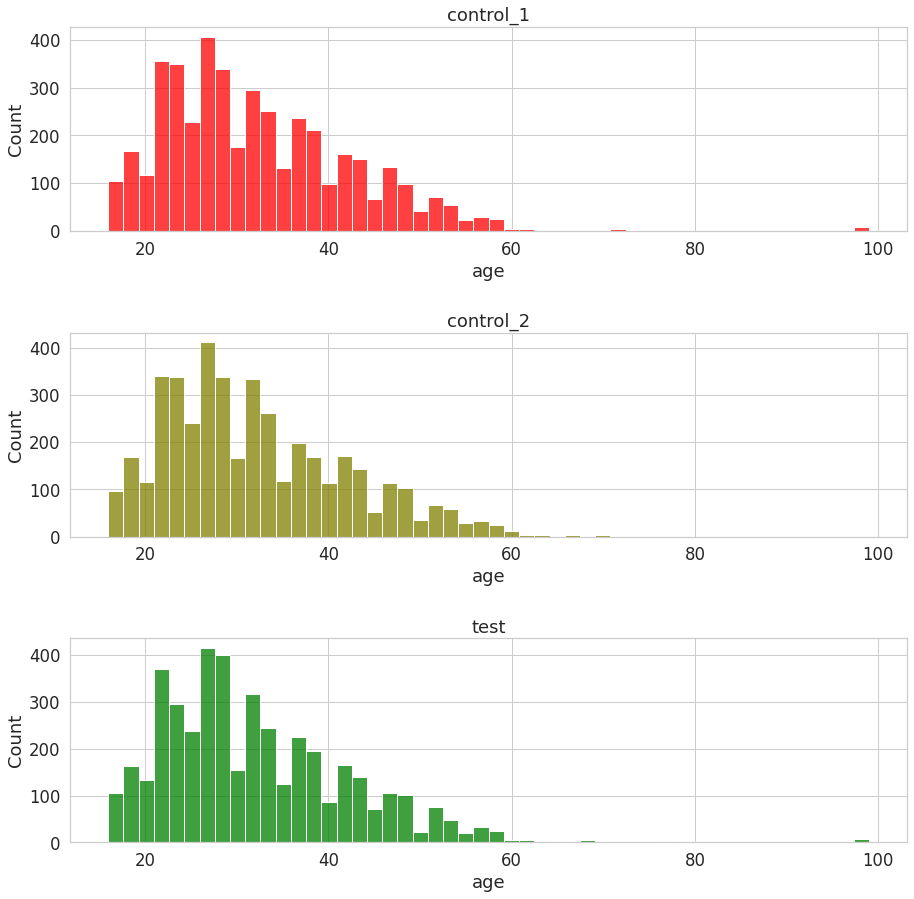

In [10]:
make_hist(df_control_1=users_control_1, 
          df_control_2=users_control_2, 
          df_test=users_test,
          col="age")

У переменной **age** содержаться немного выбросов(например 99 лет), ниже посмотрим какие промежутки возрастов не считаются выбросами.

In [11]:
o_age_c1 = get_for_outliers(users_control_1.age)
o_age_c2 = get_for_outliers(users_control_2.age)
o_age_test = get_for_outliers(users_test.age)


print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", o_age_c1)
print("Control_2:", o_age_c1)
print("Test:", o_age_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (3.0, 59.0)
Control_2: (3.0, 59.0)
Test: (5.5, 57.5)


Визуализация с учетом удаления выбросов:

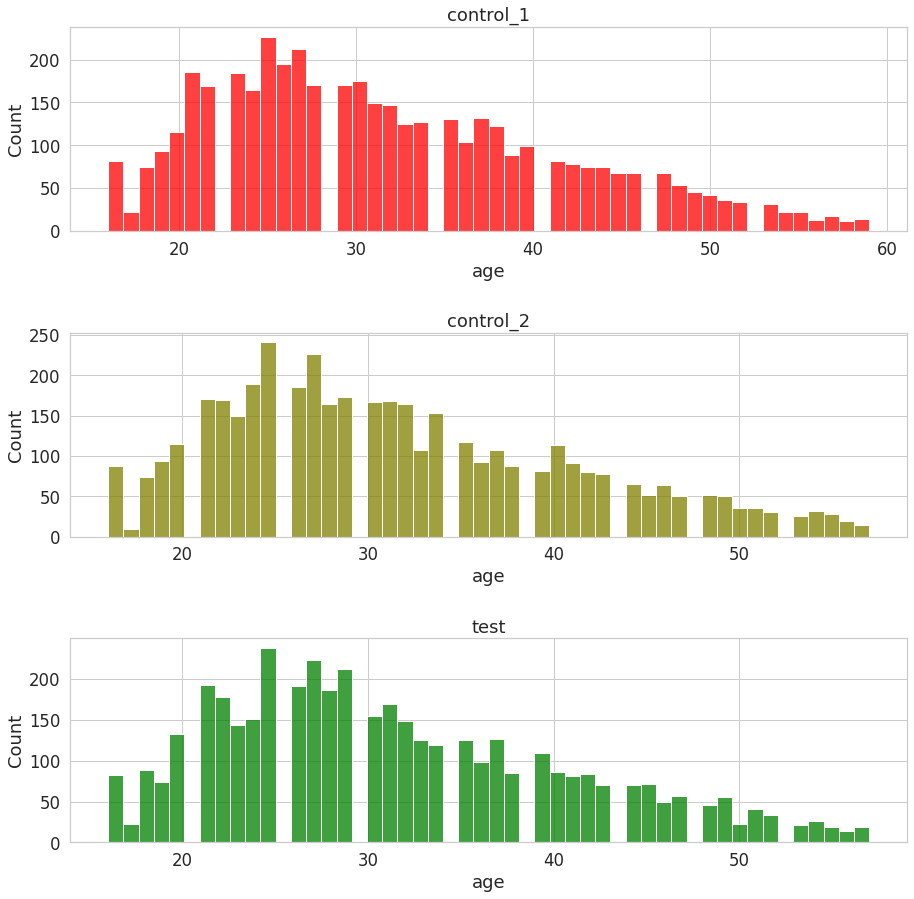

In [12]:
make_hist(df_control_1=del_outliers(users_control_1, "age"), 
          df_control_2=del_outliers(users_control_2, "age"), 
          df_test=del_outliers(users_test, "age"),
          col="age")

Около 60 лет более похоже на правду, потому что наврятли очень старые люди будут пользоваться дейтинговым приложением.

#### attraction_coeff

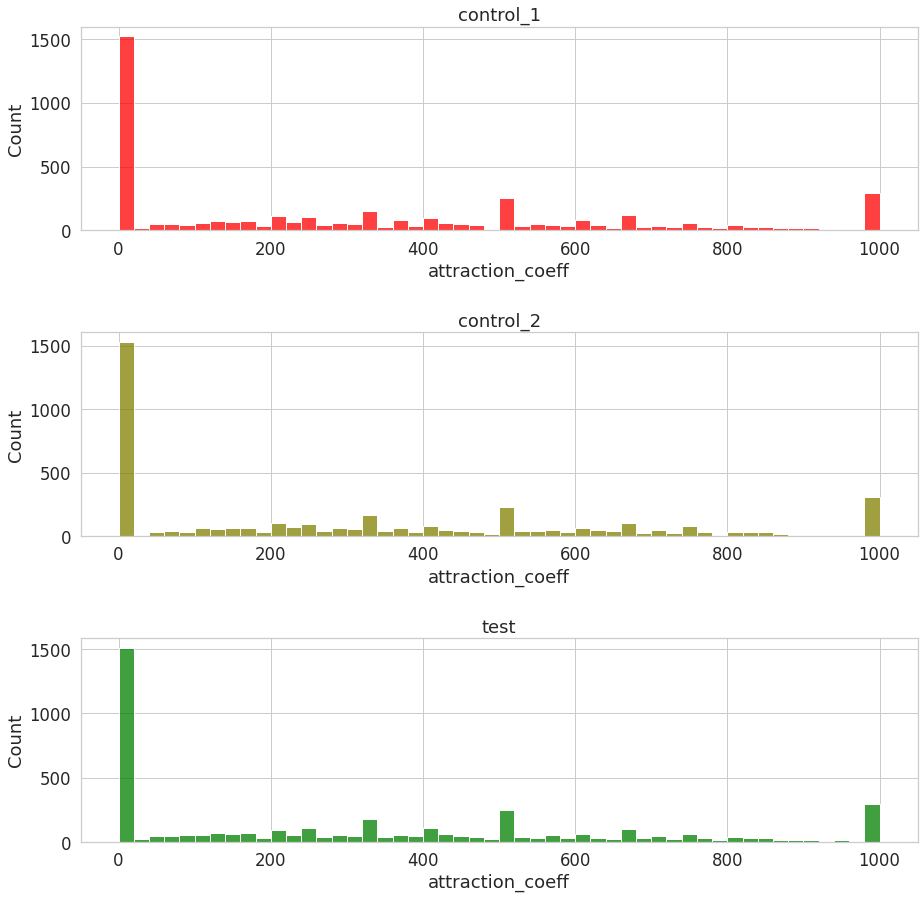

In [13]:
make_hist(df_control_1=users_control_1, 
          df_control_2=users_control_2, 
          df_test=users_test,
          col="attraction_coeff")

На счет выбросов, тут что-то сказать сложно, разве, что слишком много минимальных и максимальных значений 0 и 1000. 

#### coins

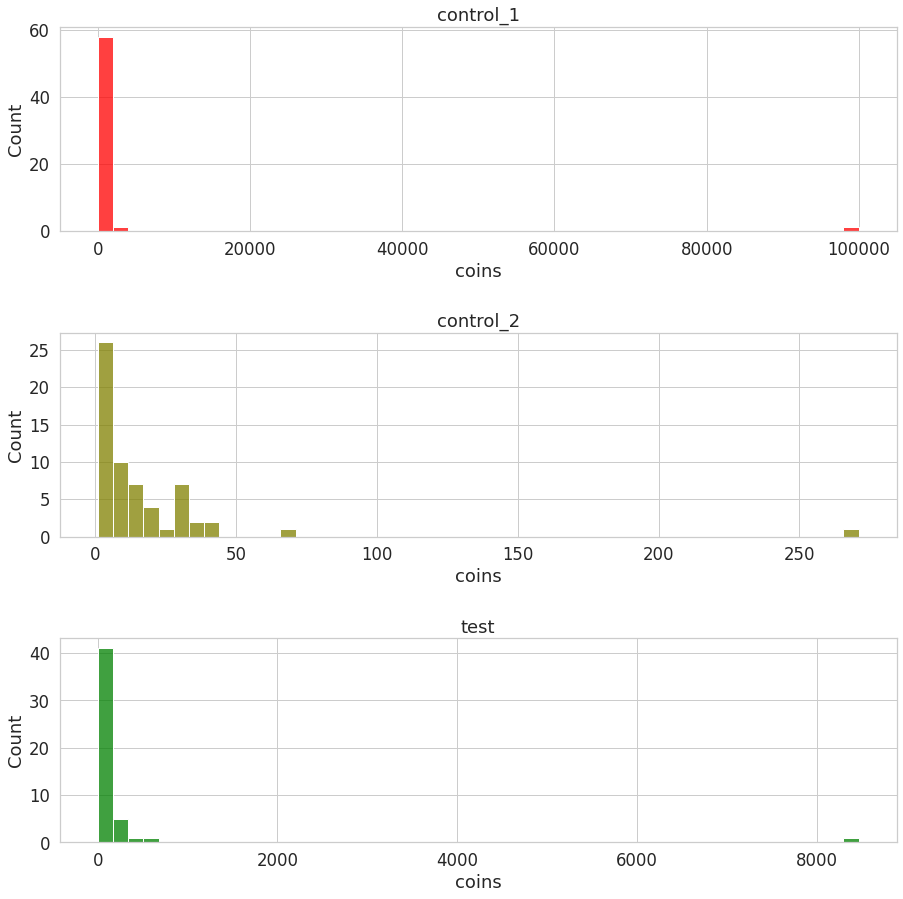

In [14]:
make_hist(df_control_1=users_control_1, 
          df_control_2=users_control_2, 
          df_test=users_test,
          col="coins")

У переменной **coins** содержатся не мало выбросов, ниже посмотрим какие промежутки coins не считаются выбросами. Дозаполним nan значения 0 так, как это можно рассматривать как отсутствие coins.

In [15]:
o_coins_c1 = get_for_outliers(users_control_1.coins.fillna(0))
o_coins_c2 = get_for_outliers(users_control_2.coins.fillna(0))
o_coins_test = get_for_outliers(users_test.coins.fillna(0))


print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", o_coins_c1)
print("Control_2:", o_coins_c2)
print("Test:", o_coins_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (0.0, 0.0)
Control_2: (0.0, 0.0)
Test: (0.0, 0.0)


Из-за того, что первые 3 квартиля составляют 0 то границы выделить не вышло, так как nan значения составляли значительную часть данного признака. Поэтому просто удалим nan значения и глянем что выйдет:

In [16]:
o_coins_c1 = get_for_outliers(users_control_1.coins.dropna())
o_coins_c2 = get_for_outliers(users_control_2.coins.dropna())
o_coins_test = get_for_outliers(users_test.coins.dropna())


print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", o_coins_c1)
print("Control_2:", o_coins_c2)
print("Test:", o_coins_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (-22.0, 58.0)
Control_2: (-20.0, 44.0)
Test: (-98.0, 174.0)


Визуализация с учетом удаления выбросов:

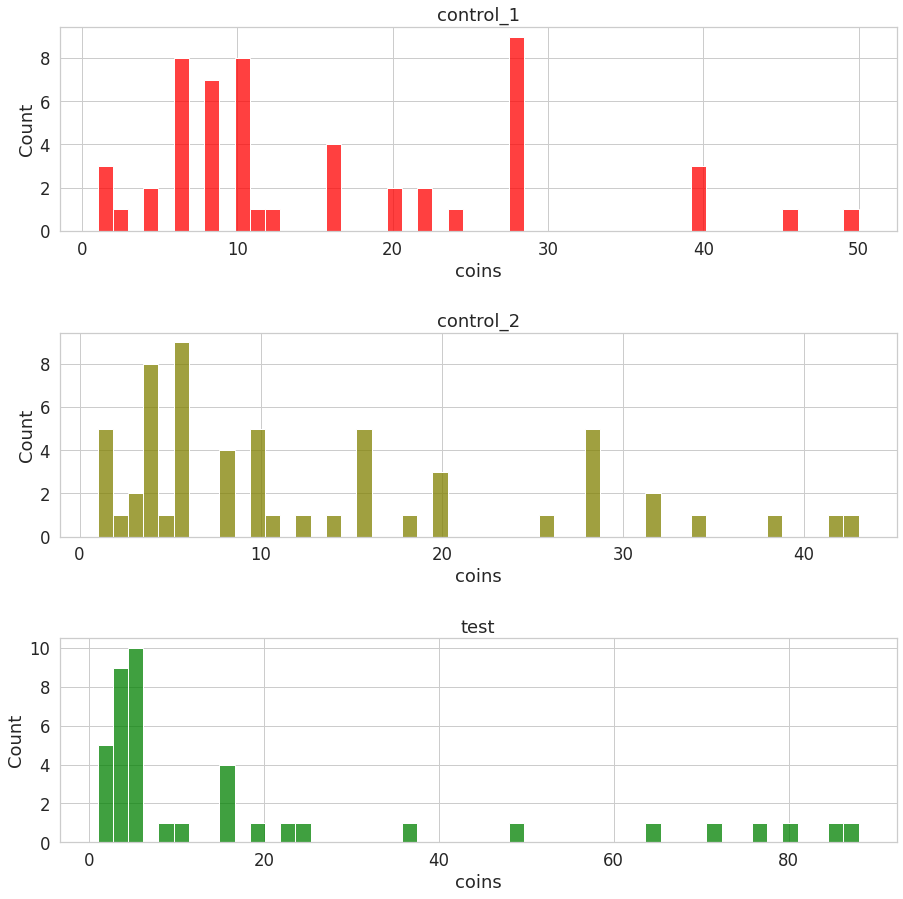

In [17]:
make_hist(df_control_1=del_outliers(users_control_1[~users_control_1.coins.isna()], "coins"), 
          df_control_2=del_outliers(users_control_2[~users_control_2.coins.isna()], "coins"), 
          df_test=del_outliers(users_test[~users_test.coins.isna()], "coins"),
          col="coins")

Тут уже **визуально** видно, что группы тестовая и контрольные отличаются по признаку coins.

#### country

In [18]:
users_control_1.groupby("country", as_index=False)\
               .agg({"uid": "count"})\
               .sort_values(by="uid", ascending=False)\
               .rename(columns={"uid": "count_uid"})\
               .head(10)

,country,count_uid
38,United States of America,1471
1,Argentina,389
13,France,370
30,Spain,342
17,Italy,338
7,Chile,287
36,United Arab Emirates,207
14,Germany,188
37,United Kingdom (Great Britain),146
6,Canada,134


In [19]:
users_control_2.groupby("country", as_index=False)\
               .agg({"uid": "count"})\
               .sort_values(by="uid", ascending=False)\
               .rename(columns={"uid": "count_uid"})\
               .head(10)

,country,count_uid
43,United States of America,1486
0,Argentina,397
12,France,376
35,Spain,310
18,Italy,293
6,Chile,286
41,United Arab Emirates,211
14,Germany,202
42,United Kingdom (Great Britain),146
5,Canada,134


In [20]:
users_test.groupby("country", as_index=False)\
          .agg({"uid": "count"})\
          .sort_values(by="uid", ascending=False)\
          .rename(columns={"uid": "count_uid"})\
          .head(10)

,country,count_uid
48,United States of America,1450
1,Argentina,396
13,France,359
24,Italy,323
40,Spain,301
8,Chile,272
46,United Arab Emirates,226
16,Germany,209
47,United Kingdom (Great Britain),169
7,Canada,137


По топ 10 странам видно, что распределение юзеров по страннам в контрольных и тестовых группах сохроняется.

#### visit_days

В обзоре по признакам полей, пока рассмотрим количество посещений приложения каждым юзером

In [21]:
users_control_1["cnt_visit_days"] = users_control_1.visit_days\
                                                   .apply(lambda x: len(str(x).split(",")))
users_control_2["cnt_visit_days"] = users_control_2.visit_days\
                                                   .apply(lambda x: len(str(x).split(",")))
users_test["cnt_visit_days"] = users_test.visit_days\
                                         .apply(lambda x: len(str(x).split(",")))

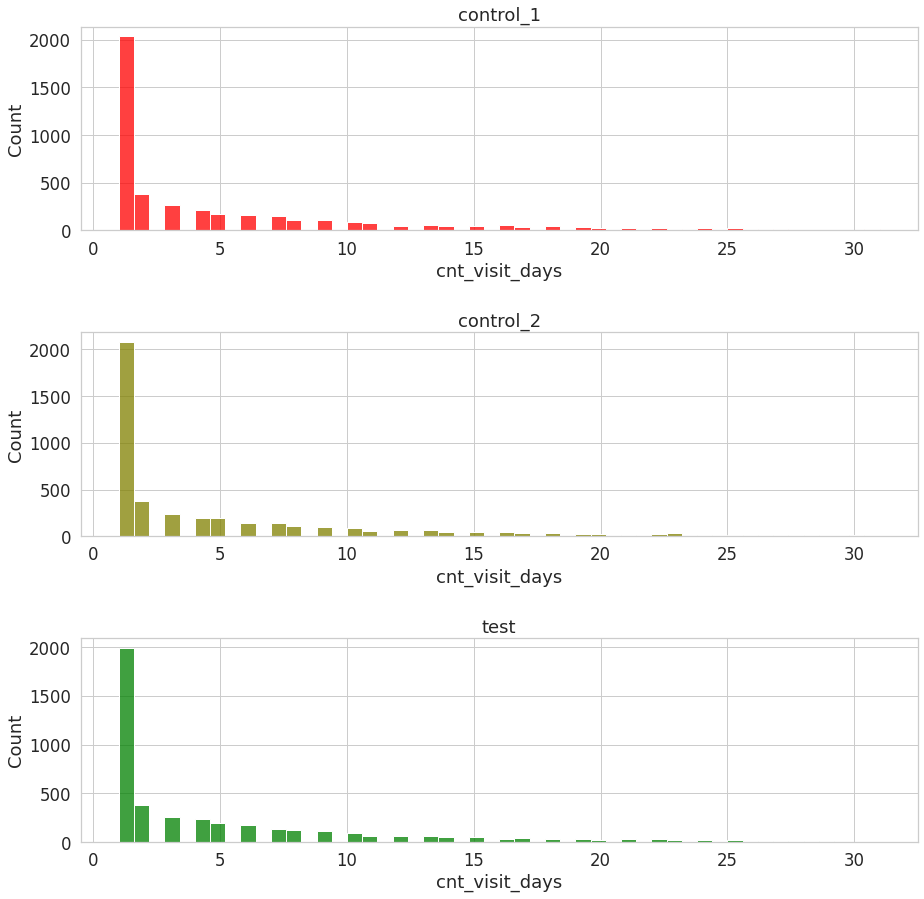

In [22]:
make_hist(df_control_1=users_control_1, 
          df_control_2=users_control_2, 
          df_test=users_test,
          col="cnt_visit_days")

Тут хорошо видно, что распределения почти не отличаются и люди обычно заходят в приложение в основном заходят 1 раз и начиная со второго дня количество заходов в приложение резко падает.

#### gender

In [23]:
users_control_1.groupby("gender", as_index=False)\
               .agg({"uid": "count"})\
               .sort_values(by="uid", ascending=False)\
               .rename(columns={"uid": "count_gender"})

,gender,count_gender
1,1,4158
0,0,182


In [24]:
users_control_2.groupby("gender", as_index=False)\
               .agg({"uid": "count"})\
               .sort_values(by="uid", ascending=False)\
               .rename(columns={"uid": "count_gender"})

,gender,count_gender
1,1,4069
0,0,195


In [25]:
users_test.groupby("gender", as_index=False)\
          .agg({"uid": "count"})\
          .sort_values(by="uid", ascending=False)\
          .rename(columns={"uid": "count_gender"})

,gender,count_gender
1,1,4106
0,0,202


Четко видно, что одного пола значительно больше чем другого. При этом визульно распределения групп одинаковые.

#### age_filter_start

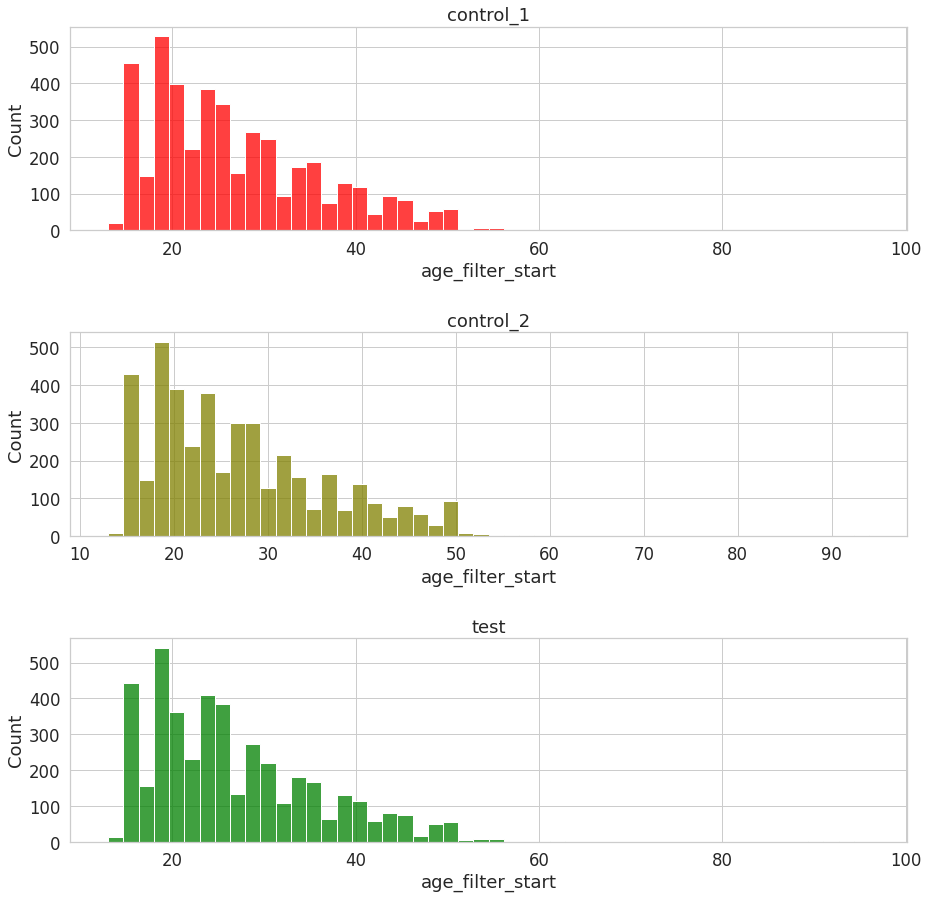

In [26]:
make_hist(df_control_1=users_control_1, 
          df_control_2=users_control_2, 
          df_test=users_test,
          col="age_filter_start")

Видно что признак **age_filter_start** имеет похожее **age** распределение и имеет практически похожие выбросы. Посмотрим как выглядят распределения без них.

In [27]:
o_age_filter_start_c1 = get_for_outliers(users_control_1.age_filter_start)
o_age_filter_start_c2 = get_for_outliers(users_control_2.age_filter_start)
o_age_filter_start_test = get_for_outliers(users_test.age_filter_start)


print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", o_age_filter_start_c1)
print("Control_2:", o_age_filter_start_c2)
print("Test:", o_age_filter_start_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (-0.5, 51.5)
Control_2: (-0.5, 51.5)
Test: (-0.5, 51.5)


Визуализаци с учетом удаления выбросов

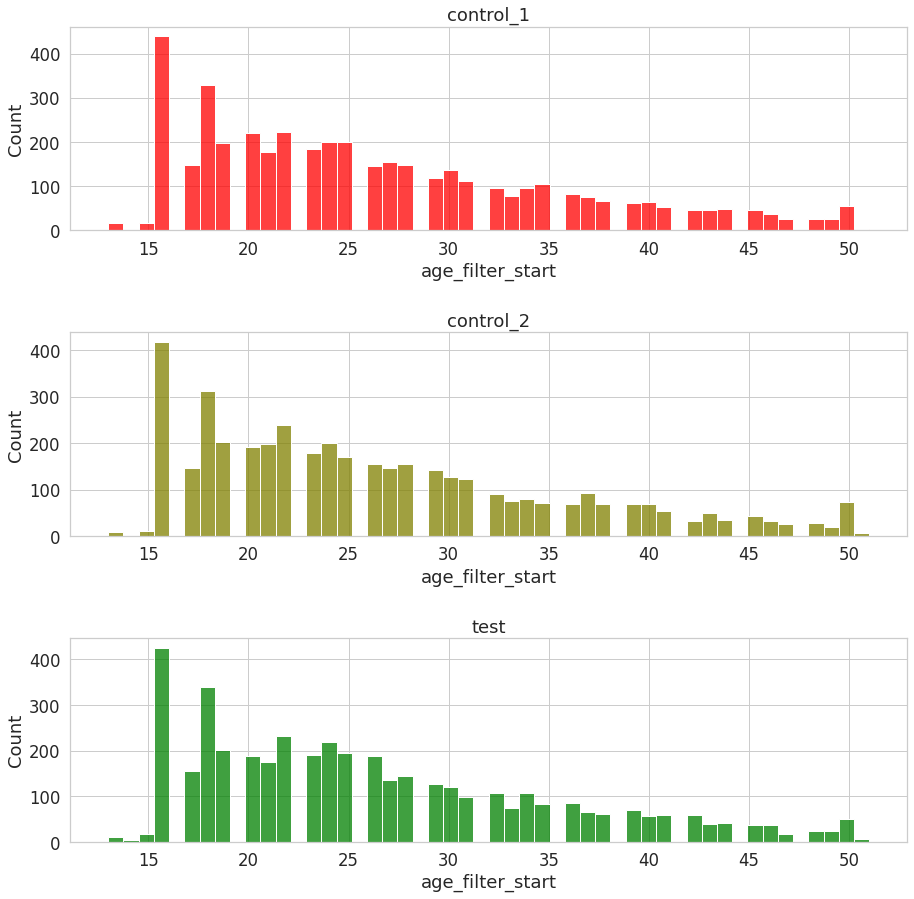

In [28]:
make_hist(df_control_1=del_outliers(users_control_1, "age_filter_start"), 
          df_control_2=del_outliers(users_control_2, "age_filter_start"), 
          df_test=del_outliers(users_test, "age_filter_start"),
          col="age_filter_start")

#### age_filter_end

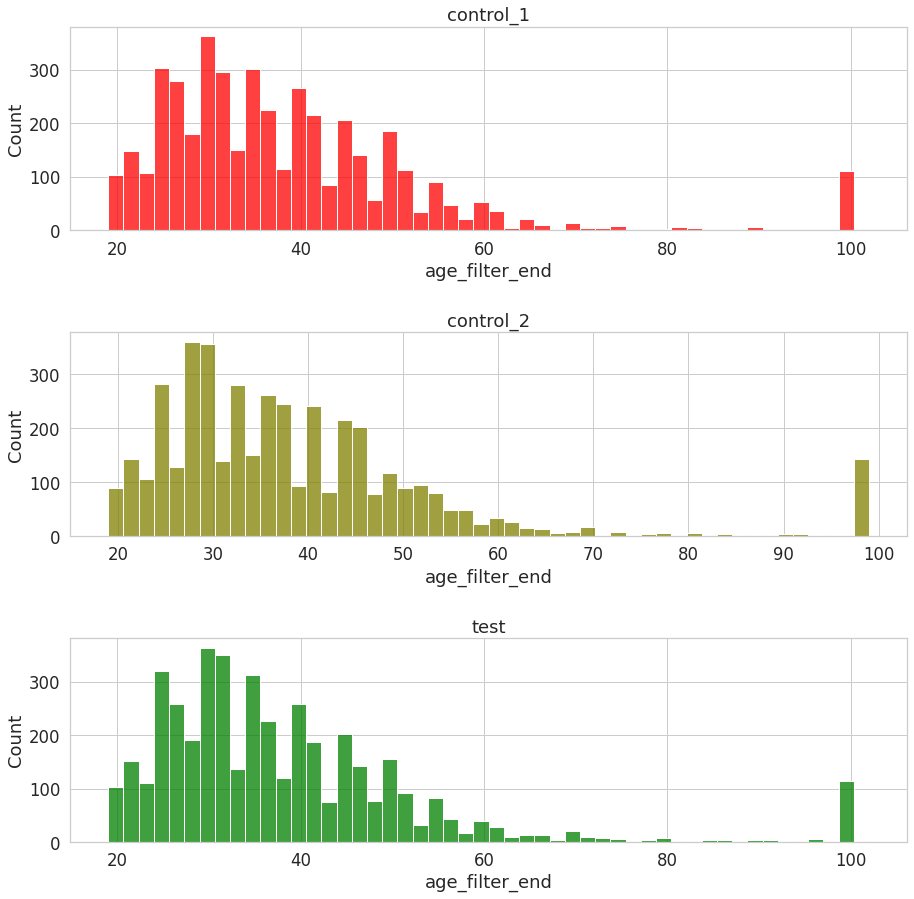

In [29]:
make_hist(df_control_1=users_control_1, 
          df_control_2=users_control_2, 
          df_test=users_test,
          col="age_filter_end")

Видно что признак **age_filter_end** имеет похожее **age** распределение и имеет практически похожие выбросы за исключением крупных значений которых подозрительно много. Посмотрим как выглядят распределения без них.

In [30]:
o_age_filter_end_c1 = get_for_outliers(users_control_1.age_filter_end)
o_age_filter_end_c2 = get_for_outliers(users_control_2.age_filter_end)
o_age_filter_end_test = get_for_outliers(users_test.age_filter_end)


print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", o_age_filter_end_c1)
print("Control_2:", o_age_filter_end_c2)
print("Test:", o_age_filter_end_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (2.5, 70.5)
Control_2: (2.5, 70.5)
Test: (4.0, 68.0)


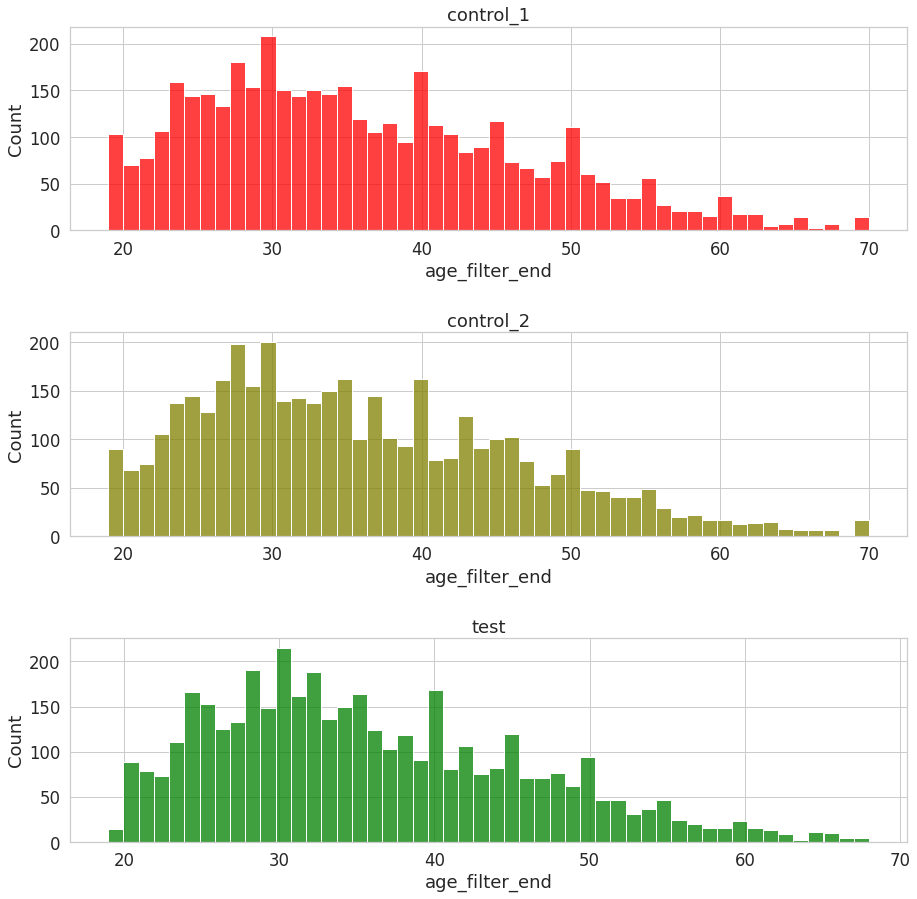

In [31]:
make_hist(df_control_1=del_outliers(users_control_1, "age_filter_end"), 
          df_control_2=del_outliers(users_control_2, "age_filter_end"), 
          df_test=del_outliers(users_test, "age_filter_end"),
          col="age_filter_end")

Нельзя не заметить что из-за большого количество крупных значений граница правого интервала сильно сдвинулась вправо, что почти на 10 лет и почти на 20 лет превосходит **age** и **age_filter_end**.

#### views_count

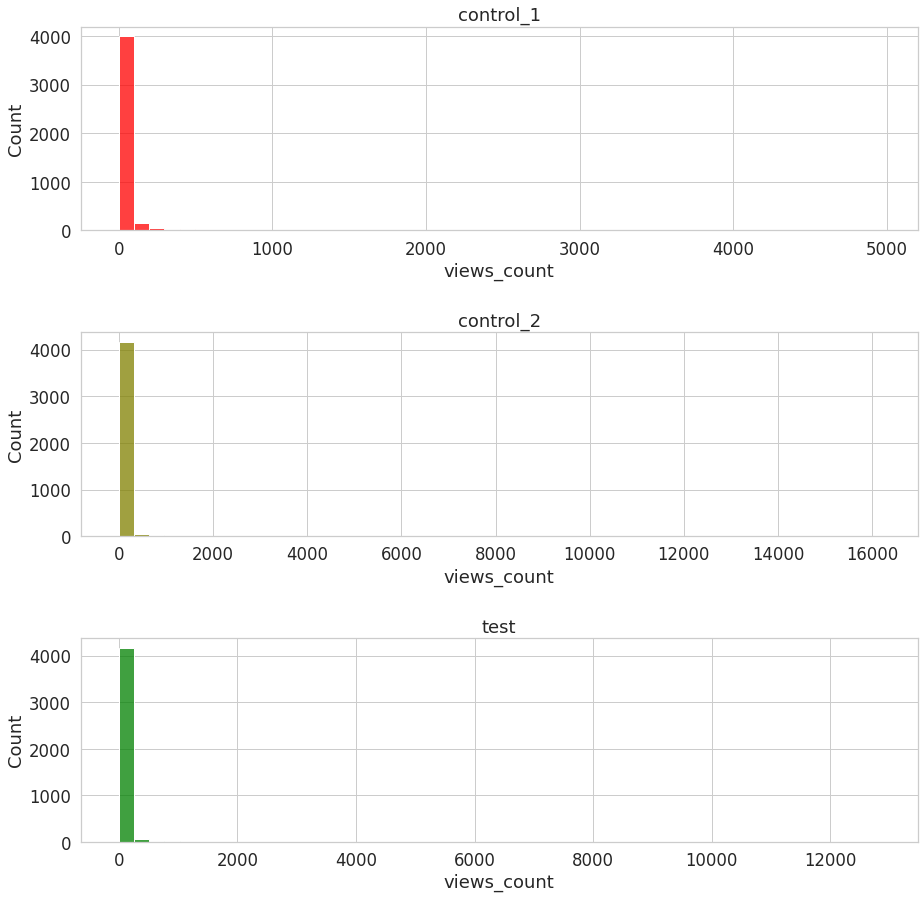

In [32]:
make_hist(df_control_1=users_control_1, 
          df_control_2=users_control_2, 
          df_test=users_test,
          col="views_count")

В признаке **views_count** тоже во всех группах видны выбросы, удалим их и посмотрим на гистограммы без них.

In [33]:
o_views_count_c1 = get_for_outliers(users_control_1.views_count)
o_views_count_c2 = get_for_outliers(users_control_2.views_count)
o_views_count_test = get_for_outliers(users_test.views_count)


print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", o_views_count_c1)
print("Control_2:", o_views_count_c2)
print("Test:", o_views_count_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (-29.0, 51.0)
Control_2: (-27.5, 48.5)
Test: (-30.5, 53.5)


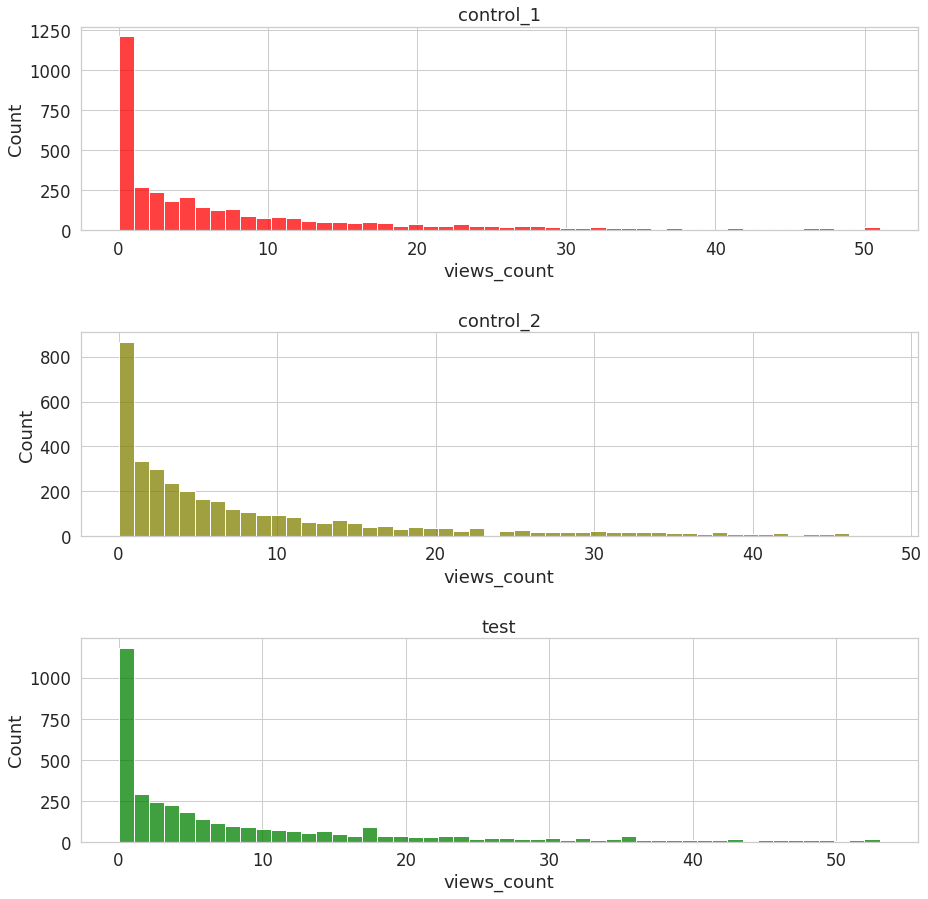

In [34]:
make_hist(df_control_1=del_outliers(users_control_1, "views_count"), 
          df_control_2=del_outliers(users_control_2, "views_count"), 
          df_test=del_outliers(users_test, "views_count"),
          col="views_count")

Как мы видим в общем люди слишком мало имеют полученных оценок, а в самом распространенном случае их не имеют вообще. Визуально распределения примерно одинаковы.

#### was_premium

Так как у нас есть только наличие nan и 1, nan будем считать как отсутствие в прошлом любого премиум-статуса и заменим nan на 0.

In [35]:
users_control_1.fillna(0)\
               .groupby("was_premium", as_index=False)\
               .agg({"uid": "count"})\
               .sort_values(by="uid", ascending=False)\
               .rename(columns={"uid": "count_was_premium"})

,was_premium,count_was_premium
0,0.0,3904
1,1.0,436


In [36]:
users_control_2.fillna(0)\
               .groupby("was_premium", as_index=False)\
               .agg({"uid": "count"})\
               .sort_values(by="uid", ascending=False)\
               .rename(columns={"uid": "count_was_premium"})

,was_premium,count_was_premium
0,0.0,3853
1,1.0,411


In [37]:
users_test.fillna(0)\
          .groupby("was_premium", as_index=False)\
          .agg({"uid": "count"})\
          .sort_values(by="uid", ascending=False)\
          .rename(columns={"uid": "count_was_premium"})

,was_premium,count_was_premium
0,0.0,3900
1,1.0,408


Как мы видим люди не охотно преобретают какие-либо премиумы. Визуально распределения групп данного признака примерно одинаковы.

#### is_premium

Так как у нас есть только наличие nan и 1, nan будем считать как отсутствие премиум-статуса и заменим nan на 0.

In [38]:
users_control_1.fillna(0)\
               .groupby("is_premium", as_index=False)\
               .agg({"uid": "count"})\
               .sort_values(by="uid", ascending=False)\
               .rename(columns={"uid": "count_is_premium"})

,is_premium,count_is_premium
0,0.0,4148
1,1.0,192


In [39]:
users_control_2.fillna(0)\
               .groupby("is_premium", as_index=False)\
               .agg({"uid": "count"})\
               .sort_values(by="uid", ascending=False)\
               .rename(columns={"uid": "count_is_premium"})

,is_premium,count_is_premium
0,0.0,4073
1,1.0,191


In [40]:
users_test.fillna(0)\
          .groupby("is_premium", as_index=False)\
          .agg({"uid": "count"})\
          .sort_values(by="uid", ascending=False)\
          .rename(columns={"uid": "count_is_premium"})

,is_premium,count_is_premium
0,0.0,4151
1,1.0,157


Как мы видим люди не охотно преобретают премиумы. Визуально распределения групп данного признака примерно одинаковы.

#### total_revenue

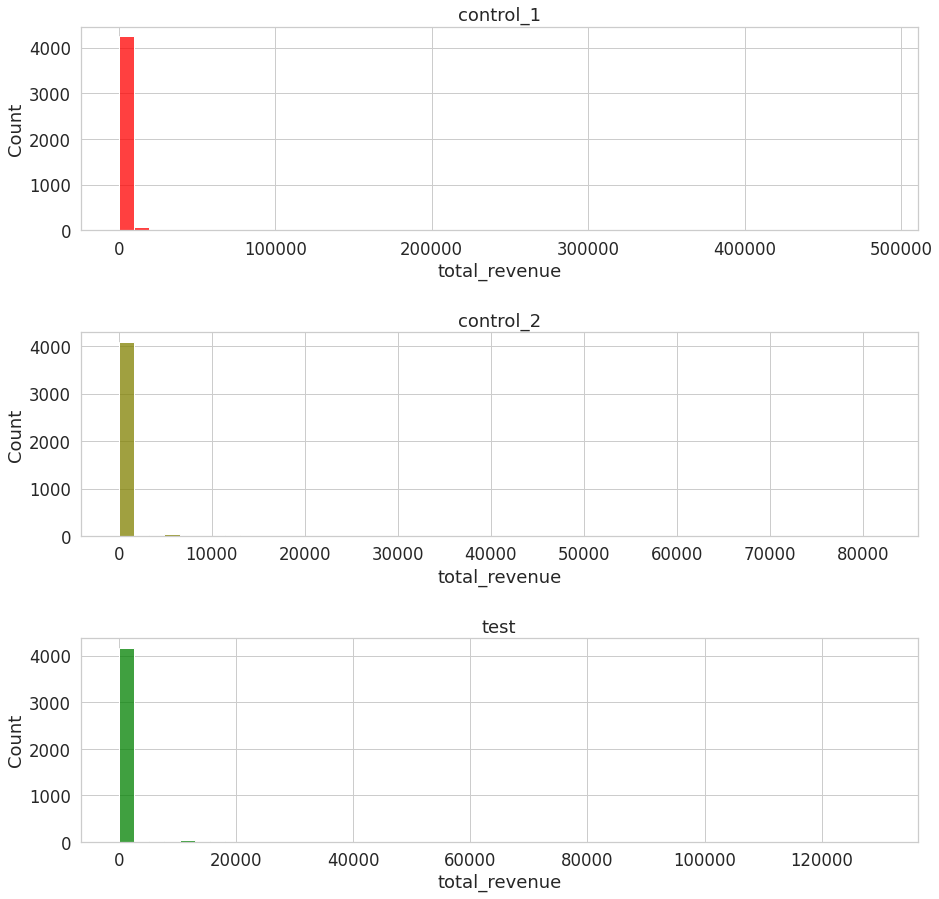

In [41]:
make_hist(df_control_1=users_control_1, 
          df_control_2=users_control_2, 
          df_test=users_test,
          col="total_revenue")

В признаке **total_revenue** тоже во всех группах видны выбросы, удалим их и посмотрим на гистограммы без них.

In [42]:
o_total_revenue_c1 = get_for_outliers(users_control_1.total_revenue)
o_total_revenue_c2 = get_for_outliers(users_control_2.total_revenue)
o_total_revenue_test = get_for_outliers(users_test.total_revenue)


print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", o_total_revenue_c1)
print("Control_2:", o_total_revenue_c2)
print("Test:", o_total_revenue_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (0.0, 0.0)
Control_2: (0.0, 0.0)
Test: (0.0, 0.0)


Из-за того, что первые 3 квартиля составляют 0 то границы выделить не вышло, так как 0 значения составляли значительную часть данного признака. Поэтому просто удалим 0 значения и глянем что выйдет:

In [43]:
o_total_revenue_c1 = get_for_outliers(users_control_1[users_control_1.total_revenue > 0].total_revenue)
o_total_revenue_c2 = get_for_outliers(users_control_2[users_control_2.total_revenue > 0].total_revenue)
o_total_revenue_test = get_for_outliers(users_test[users_test.total_revenue > 0].total_revenue)

print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", o_total_revenue_c1)
print("Control_2:", o_total_revenue_c2)
print("Test:", o_total_revenue_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (-3992.625, 23008.375)
Control_2: (-3929.25, 22720.75)
Test: (-4021.875, 28699.125)


Нули исключим для более понятной визуализации, так как понятно, что их много 

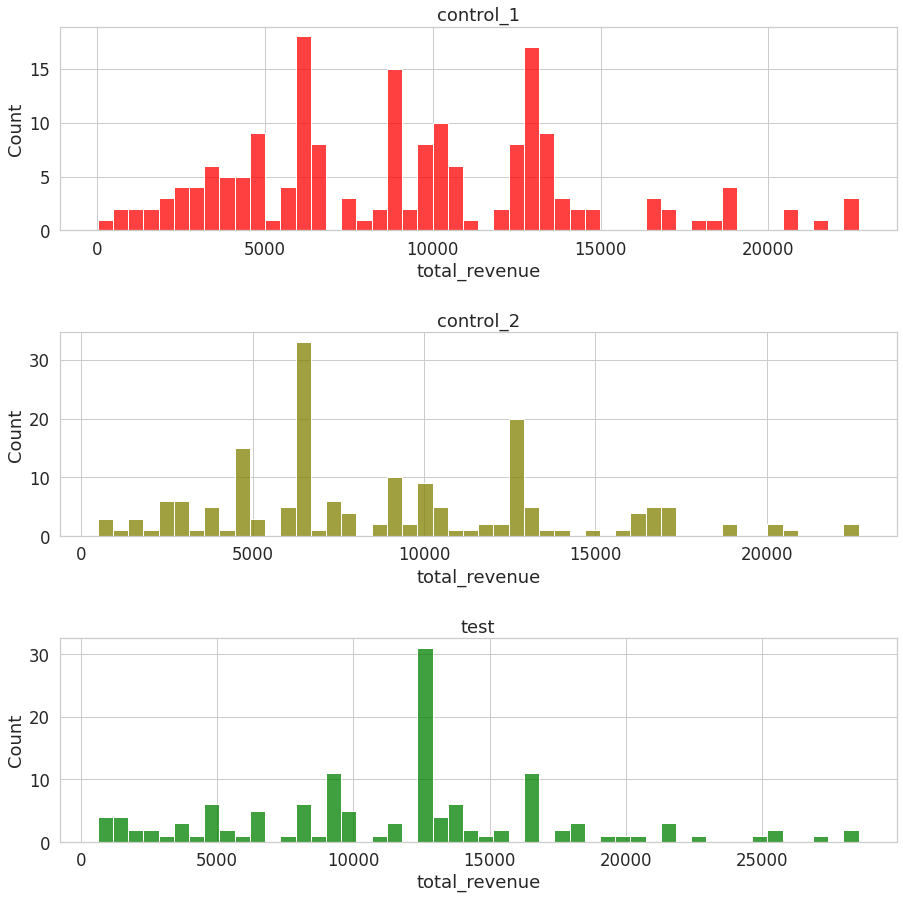

In [44]:
make_hist(df_control_1=del_outliers(users_control_1[users_control_1.total_revenue > 0], 
                                    "total_revenue"), 
          df_control_2=del_outliers(users_control_2[users_control_2.total_revenue > 0], 
                                    "total_revenue"), 
          df_test=del_outliers(users_test[users_test.total_revenue > 0], "total_revenue"),
          col="total_revenue")

Визульно видно, что распределения несколько отличаются.

### transactions_*.csv – информация о платежах пользователей:

#### transactions_test

In [45]:
get_data_descr(transactions_test)

Первые 5 строк датафрейма:


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891345942,Italy,2017-05-11 13:00:00,2017-11-13 15:04:00,12909,147,trial_vip_popup,trial_premium
1,892054251,United States of America,2017-10-22 00:33:00,2017-10-30 01:37:00,13923,147,trial_vip_popup,trial_premium
2,892236423,United States of America,2017-10-18 01:09:00,2017-10-23 00:15:00,3783,67,menu,other_type
3,892236423,United States of America,2017-10-18 01:09:00,2017-10-27 22:38:00,3783,67,menu,other_type
4,892168170,United States of America,2017-10-19 17:10:00,2017-10-27 19:10:00,9087,147,trial_vip_popup,trial_premium


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Тип данных каждого столбца:


,0
uid,int64
country,object
joined_at,datetime64[ns]
paid_at,datetime64[ns]
revenue,int64
payment_id,int64
from_page,object
product_type,object


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Количество nan значений по каждому столбцу:


,0
uid,0
country,0
joined_at,0
paid_at,0
revenue,0
payment_id,0
from_page,0
product_type,0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Размер датафрейма:
273 строк
8 столбцов

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  



In [46]:
transactions_test[["revenue"]].describe()

,revenue
count,273.000000
mean,8589.380952
std,11127.479971
min,533.000000
25%,2743.000000
50%,6305.000000
75%,12597.000000
max,113477.000000


#### transactions_control_1

In [47]:
get_data_descr(transactions_control_1)

Первые 5 строк датафрейма:


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891319275.0,France,2017-05-11 19:57:00,2017-12-11 21:57:00,12727.0,147.0,trial_vip_popup,trial_premium
1,892421826.0,Israel,2017-10-14 12:46:00,2017-10-23 12:54:00,14586.0,147.0,trial_vip_popup,trial_premium
2,891822480.0,Italy,2017-10-26 22:27:00,2017-12-11 20:59:00,1911.0,19.0,none,coins
3,891367521.0,Italy,2017-05-11 02:37:00,2017-06-11 19:15:00,1456.0,127.0,sympathy,other_type
4,892207959.0,France,2017-10-18 18:30:00,2017-12-11 12:03:00,1261.0,19.0,empty_likes,coins


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Тип данных каждого столбца:


,0
uid,float64
country,object
joined_at,datetime64[ns]
paid_at,datetime64[ns]
revenue,float64
payment_id,float64
from_page,object
product_type,object


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Количество nan значений по каждому столбцу:


,0
uid,630
country,630
joined_at,630
paid_at,630
revenue,630
payment_id,630
from_page,630
product_type,630


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Размер датафрейма:
1007 строк
8 столбцов

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  



In [48]:
transactions_control_1[["revenue"]].describe()

,revenue
count,377.000000
mean,6929.206897
std,8027.889630
min,26.000000
25%,2730.000000
50%,6266.000000
75%,6448.000000
max,63037.000000


#### transactions_control_2

In [49]:
get_data_descr(transactions_control_2)

Первые 5 строк датафрейма:


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type
0,891266616,Argentina,2017-06-11 15:25:00,2017-10-11 17:35:00,6305,19,autorefill,coins
1,892186737,Chile,2017-10-19 06:03:00,2017-04-11 08:53:00,4732,147,promo_09,premium_no_trial
2,891959004,United States of America,2017-10-24 00:12:00,2017-10-31 02:12:00,10153,147,trial_vip_popup,trial_premium
3,892115478,Spain,2017-10-20 20:39:00,2017-10-26 06:26:00,2366,67,empty_likes,other_type
4,891592941,Switzerland,2017-10-31 12:40:00,2017-03-11 16:25:00,6292,147,promo_09,premium_no_trial


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Тип данных каждого столбца:


,0
uid,int64
country,object
joined_at,datetime64[ns]
paid_at,datetime64[ns]
revenue,int64
payment_id,int64
from_page,object
product_type,object


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Количество nan значений по каждому столбцу:


,0
uid,0
country,0
joined_at,0
paid_at,0
revenue,0
payment_id,0
from_page,0
product_type,0


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  

Размер датафрейма:
328 строк
8 столбцов

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -  



In [50]:
transactions_control_2[["revenue"]].describe()

,revenue
count,328.000000
mean,5854.993902
std,6582.242539
min,481.000000
25%,2323.750000
50%,4706.000000
75%,6314.750000
max,81796.000000


#### country

In [51]:
transactions_test.groupby("country", as_index=False)\
                 .agg({"uid": pd.Series.nunique})\
                 .sort_values(by="uid", ascending=False)\
                 .rename(columns={"uid": "count_country"}).head()

,country,count_country
16,United States of America,52
11,Spain,15
5,France,13
14,United Arab Emirates,9
8,Italy,9


In [52]:
transactions_control_1.groupby("country", as_index=False)\
                      .agg({"uid": pd.Series.nunique})\
                      .sort_values(by="uid", ascending=False)\
                      .rename(columns={"uid": "count_country"}).head()

,country,count_country
17,United States of America,60.0
5,France,22.0
9,Italy,17.0
8,Israel,14.0
0,Argentina,12.0


In [53]:
transactions_control_2.groupby("country", as_index=False)\
                      .agg({"uid": pd.Series.nunique})\
                      .sort_values(by="uid", ascending=False)\
                      .rename(columns={"uid": "count_country"}).head()

,country,count_country
18,United States of America,64
6,France,19
9,Italy,16
12,Spain,12
5,Chile,11


Топ 5 стран в которых больше всего посетителей с которых имеется выручка.

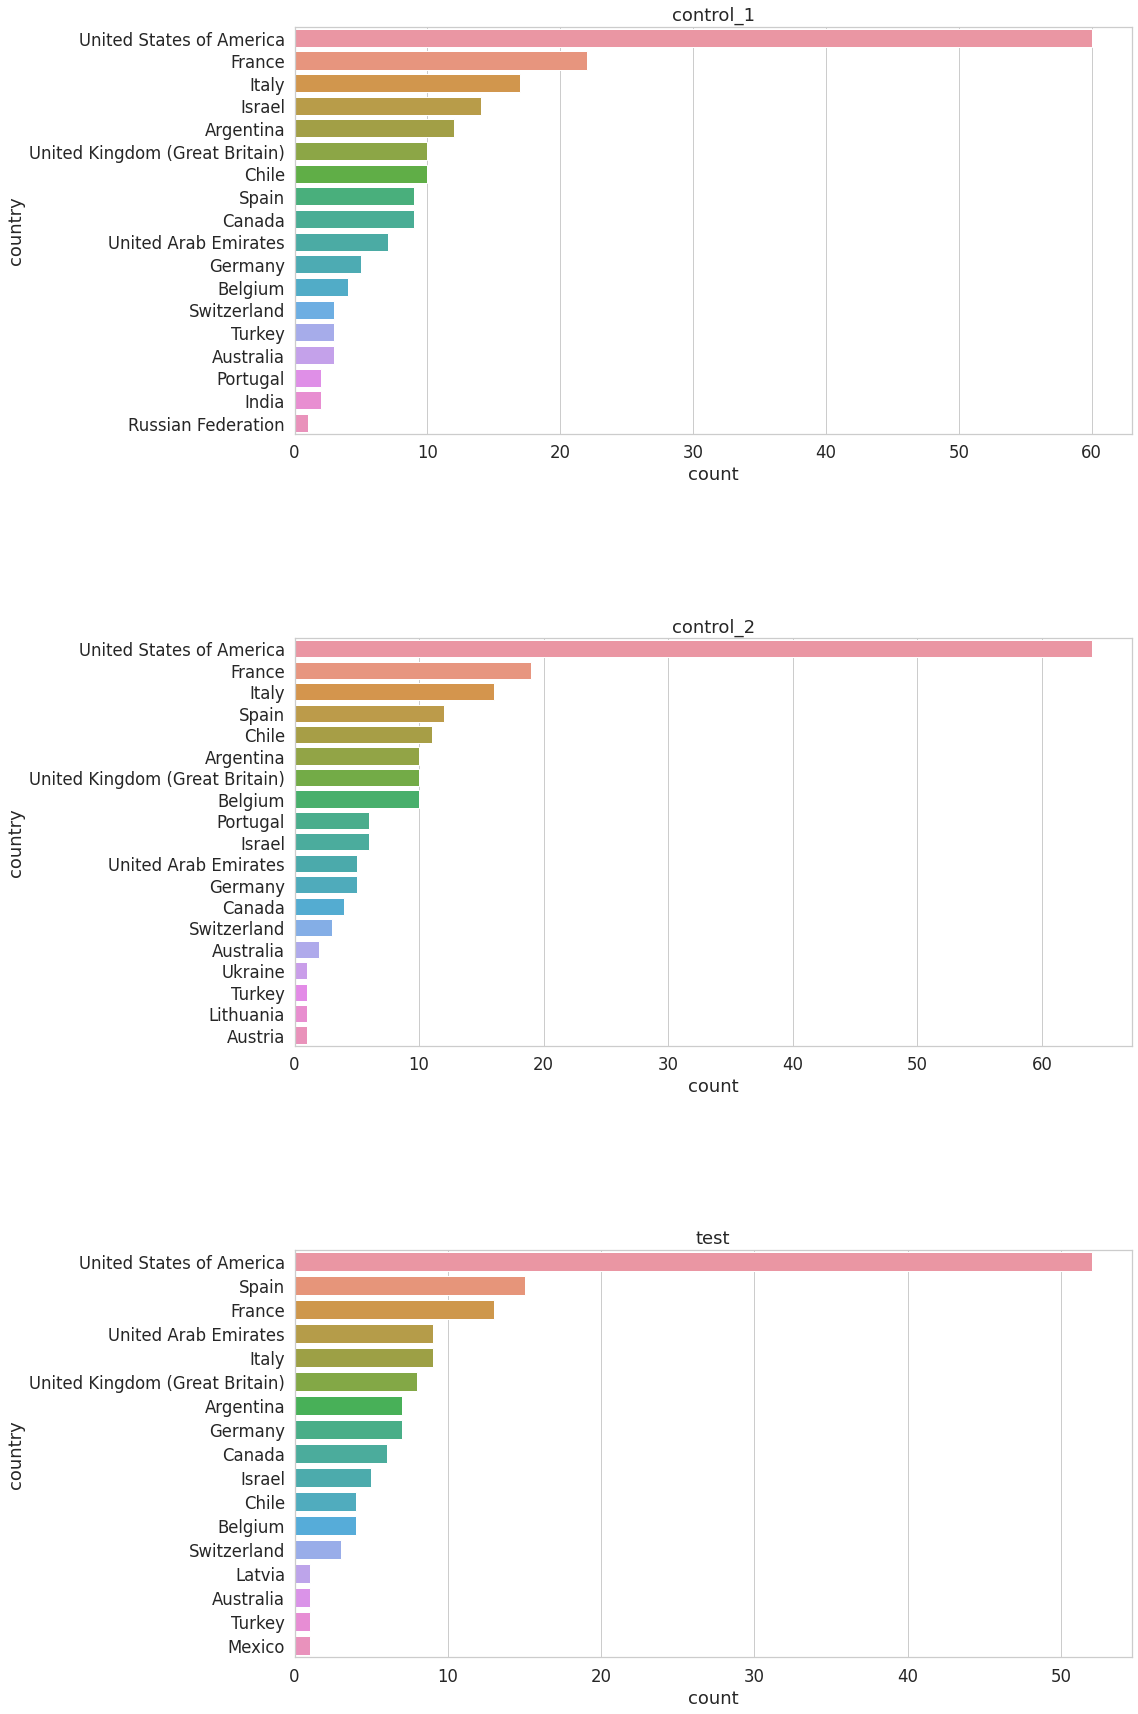

In [54]:
make_countplot(transactions_control_1.drop_duplicates(subset=["uid"]), 
               transactions_control_2.drop_duplicates(subset=["uid"]), 
               transactions_test.drop_duplicates(subset=["uid"]), "country", size=(15, 30))

Больше всего клиентов у нас с USA, но топ 5 постоянно меняется из группы в группу.  

#### revenue

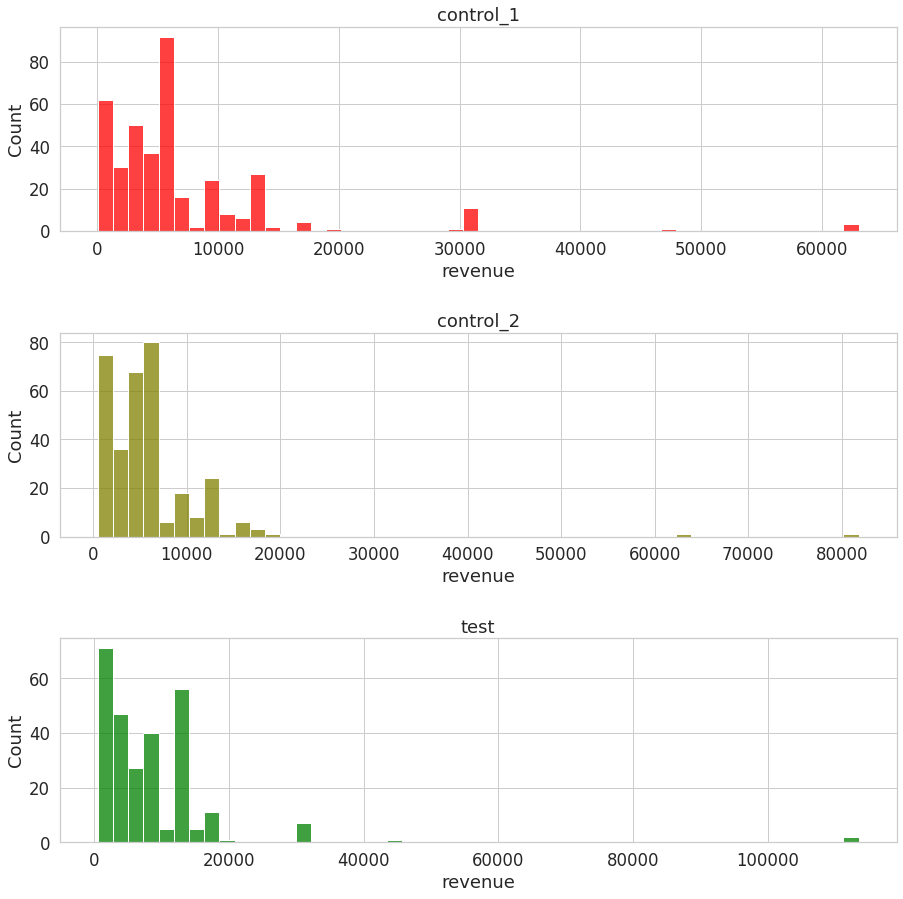

In [55]:
make_hist(df_control_1=transactions_control_1, 
          df_control_2=transactions_control_2, 
          df_test=transactions_test,
          col="revenue")

В данном признаке явно отслеживаются выбросы, удалим их и посмотрим как будут выглядеть гистограммы

In [56]:
t_revenue_c1 = get_for_outliers(transactions_control_1.dropna().revenue)
t_revenue_c2 = get_for_outliers(transactions_control_2.revenue)
t_revenue_test = get_for_outliers(transactions_test.revenue)


print("Нижнии и верхние границы интервалов данных без учета выбросов:")
print("Control_1:", t_revenue_c1)
print("Control_2:", t_revenue_c2)
print("Test:", t_revenue_test)

Нижнии и верхние границы интервалов данных без учета выбросов:
Control_1: (-2847.0, 12025.0)
Control_2: (-3662.75, 12301.25)
Test: (-12038.0, 27378.0)


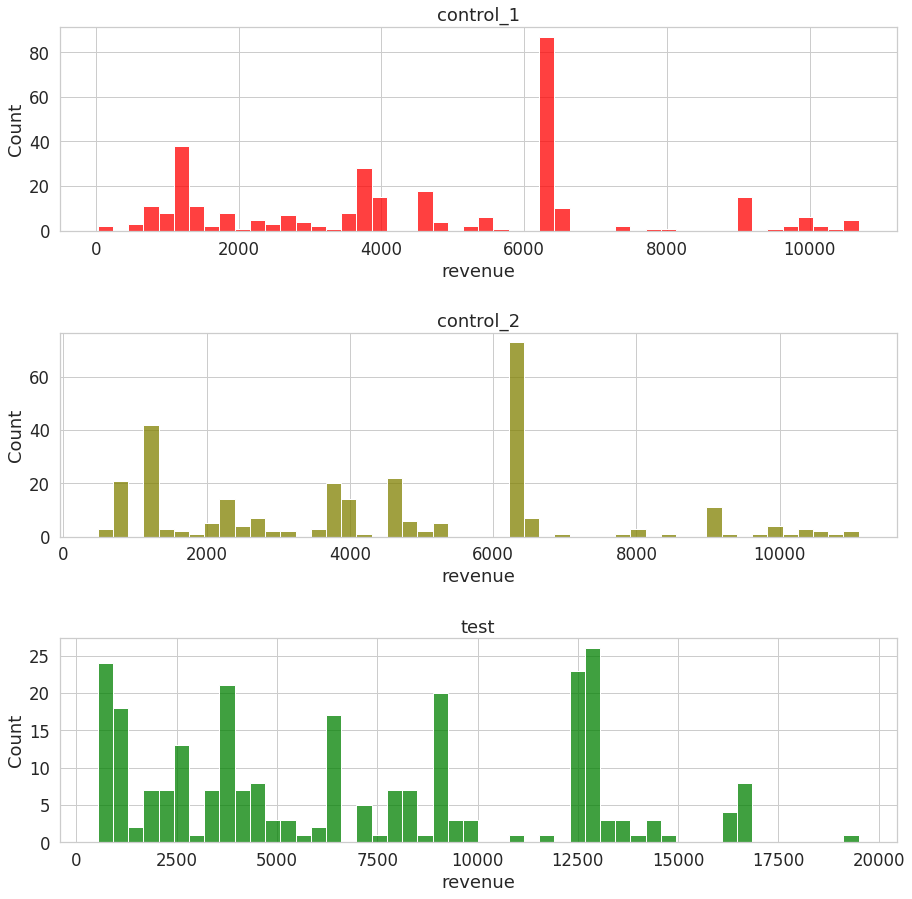

In [57]:
make_hist(df_control_1=del_outliers(transactions_control_1.dropna(), "revenue"), 
          df_control_2=del_outliers(transactions_control_2, "revenue"), 
          df_test=del_outliers(transactions_test, "revenue"),
          col="revenue")

Визуально видно, что контрольные(вместе) и тестовая группы между собой отличаются.

#### from_page

In [58]:
transactions_test.groupby("from_page", as_index=False)\
                 .agg({"uid": "count"})\
                 .sort_values(by="uid", ascending=False)\
                 .rename(columns={"uid": "count_from_page"}).head()

,from_page,count_from_page
6,empty_likes,72
20,trial_vip_popup,48
13,none,34
2,autoreply_message,27
12,menu,27


In [59]:
transactions_control_1.groupby("from_page", as_index=False)\
                      .agg({"uid": "count"})\
                      .sort_values(by="uid", ascending=False)\
                      .rename(columns={"uid": "count_from_page"}).head()

,from_page,count_from_page
7,empty_likes,99
23,trial_vip_popup,56
13,none,34
11,menu,31
3,autoreply_message,29


In [60]:
transactions_control_2.groupby("from_page", as_index=False)\
                      .agg({"uid": "count"})\
                      .sort_values(by="uid", ascending=False)\
                      .rename(columns={"uid": "count_from_page"}).head()

,from_page,count_from_page
4,empty_likes,101
16,trial_vip_popup,45
10,none,32
8,left_sidebar_menu,25
2,autoreply_message,24


Топ 5 страниц сайта откуда клиент перешел на страницу оплаты.

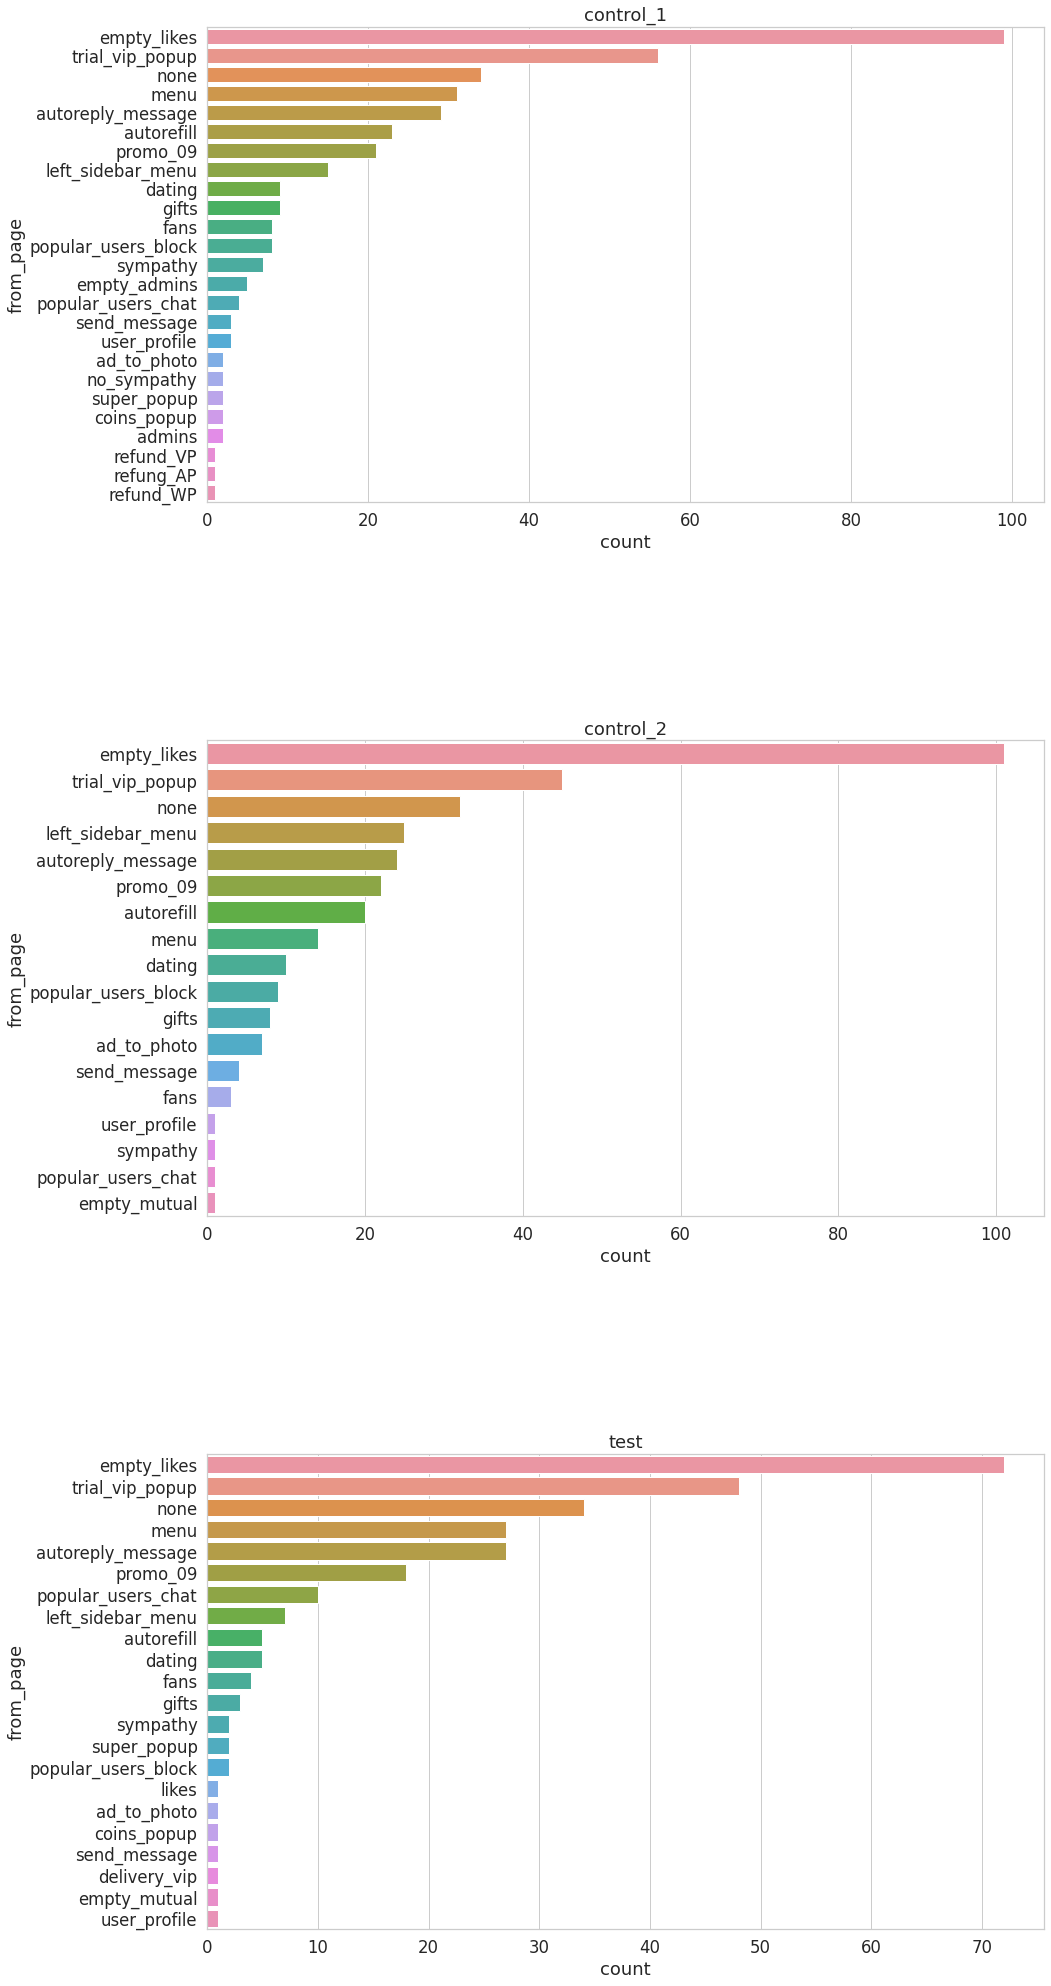

In [61]:
make_countplot(transactions_control_1,
               transactions_control_2,
               transactions_test, 
               "from_page", 
               size=(15, 35), 
               del_d=False)

Топ 3 источников не меняются из группы в группу.

#### product_type

In [62]:
transactions_test.groupby("product_type", as_index=False)\
                 .agg({"uid": "count"})\
                 .sort_values(by="uid", ascending=False)\
                 .rename(columns={"uid": "count_product_type"})

,product_type,count_product_type
0,coins,106
2,premium_no_trial,76
3,trial_premium,62
1,other_type,29


In [63]:
transactions_control_1.groupby("product_type", as_index=False)\
                      .agg({"uid": "count"})\
                      .sort_values(by="uid", ascending=False)\
                      .rename(columns={"uid": "count_product_type"})

,product_type,count_product_type
0,coins,149
2,premium_no_trial,106
3,trial_premium,67
1,other_type,55


In [64]:
transactions_control_2.groupby("product_type", as_index=False)\
                      .agg({"uid": "count"})\
                      .sort_values(by="uid", ascending=False)\
                      .rename(columns={"uid": "count_product_type"})

,product_type,count_product_type
0,coins,124
2,premium_no_trial,107
3,trial_premium,53
1,other_type,44


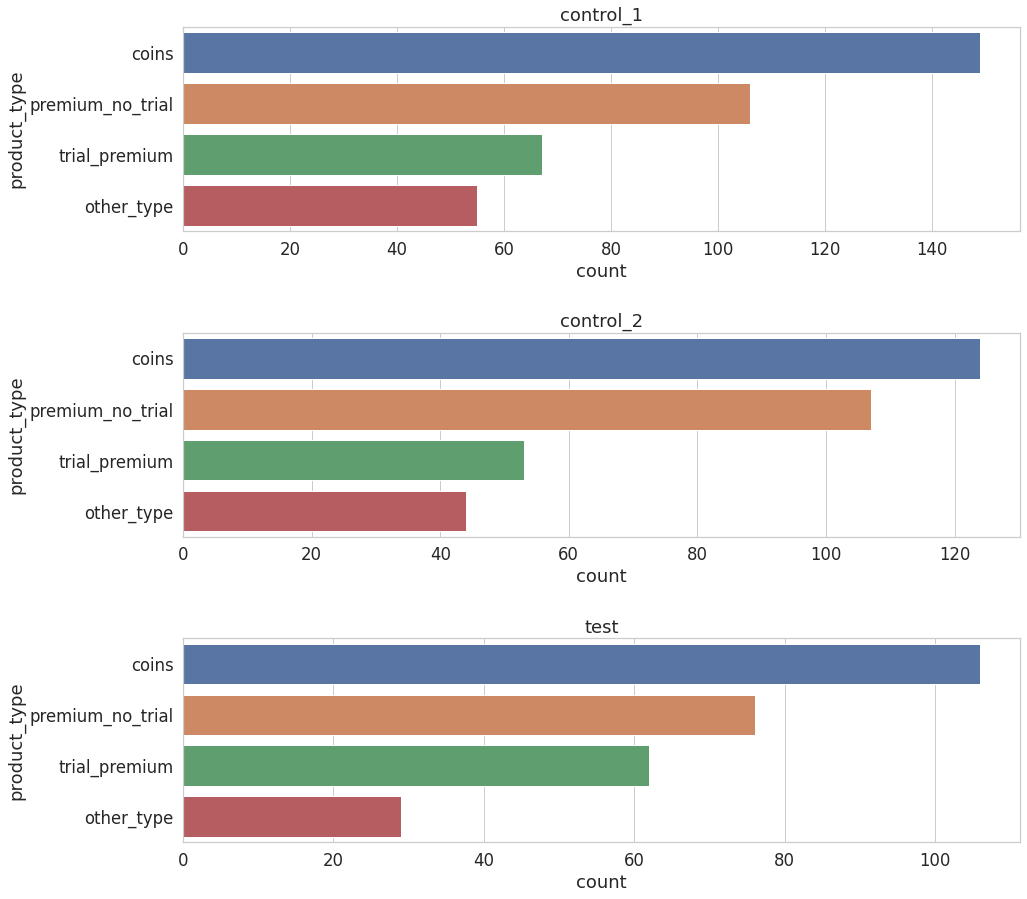

In [65]:
make_countplot(transactions_control_1,
               transactions_control_2,
               transactions_test, 
               "product_type", 
               size=(15, 15),
               del_d=False)

На сколько мы видим, распределения продуктов с которых получается прибыль не меняется от группы к группе, при этом самый приобретаемый это coins.

#### Посмотрим на корреляции между числовыми переменными

,age,age_filter_start,age_filter_end,attraction_coeff,views_count,total_revenue,coins,cnt_visit_days
age,1.000000,0.742034,0.519231,-0.017923,0.002772,0.021649,-0.184977,0.054664
age_filter_start,0.742034,1.000000,0.420102,-0.057732,0.005837,-0.027174,-0.001048,-0.001508
age_filter_end,0.519231,0.420102,1.000000,0.032161,0.041672,-0.008758,-0.048418,0.031972
attraction_coeff,-0.017923,-0.057732,0.032161,1.000000,0.045925,0.005771,0.162466,0.100348
views_count,0.002772,0.005837,0.041672,0.045925,1.000000,0.052057,0.991025,0.159639
total_revenue,0.021649,-0.027174,-0.008758,0.005771,0.052057,1.000000,-0.080385,0.132936
coins,-0.184977,-0.001048,-0.048418,0.162466,0.991025,-0.080385,1.000000,0.247014
cnt_visit_days,0.054664,-0.001508,0.031972,0.100348,0.159639,0.132936,0.247014,1.000000


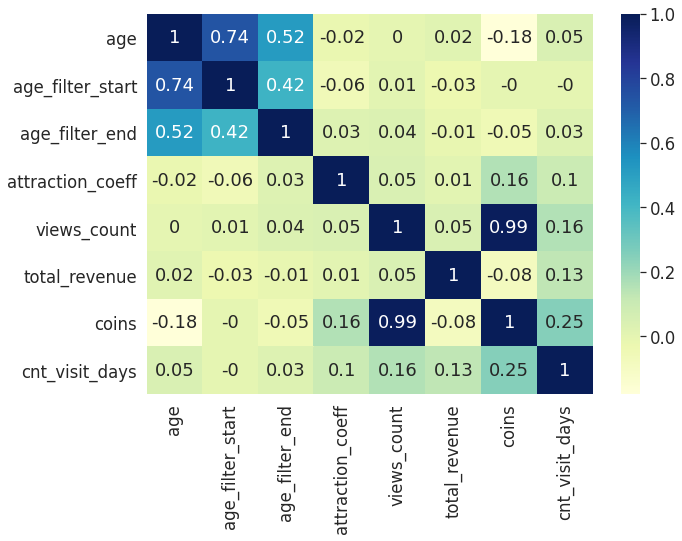

In [66]:
corr_mat_test = users_test[["age", "age_filter_start", "age_filter_end", 
                            "attraction_coeff", "views_count", "total_revenue",
                            "coins", "cnt_visit_days"]].corr()

display(corr_mat_test)

dataplot = sns.heatmap(corr_mat_test.round(2), cmap="YlGnBu", annot=True)

plt.show()

,age,age_filter_start,age_filter_end,attraction_coeff,views_count,total_revenue,coins,cnt_visit_days
age,1.000000,0.741461,0.547116,-0.019890,0.042672,-0.018330,-0.024170,0.054629
age_filter_start,0.741461,1.000000,0.424255,-0.059208,0.016896,-0.027596,0.007942,0.011706
age_filter_end,0.547116,0.424255,1.000000,0.034642,0.075986,-0.010329,0.232629,0.071970
attraction_coeff,-0.019890,-0.059208,0.034642,1.000000,0.052083,-0.001794,-0.262613,0.086623
views_count,0.042672,0.016896,0.075986,0.052083,1.000000,0.067861,0.918521,0.191472
total_revenue,-0.018330,-0.027596,-0.010329,-0.001794,0.067861,1.000000,-0.013599,0.068117
coins,-0.024170,0.007942,0.232629,-0.262613,0.918521,-0.013599,1.000000,0.259692
cnt_visit_days,0.054629,0.011706,0.071970,0.086623,0.191472,0.068117,0.259692,1.000000


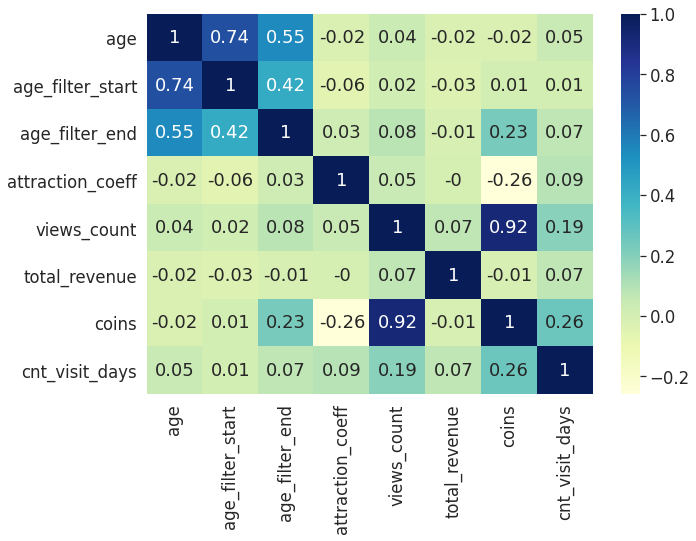

In [67]:
corr_mat_control_1 = users_control_1[["age", "age_filter_start", "age_filter_end", 
                                      "attraction_coeff", "views_count", "total_revenue",
                                      "coins", "cnt_visit_days"]].corr()

display(corr_mat_control_1)

dataplot = sns.heatmap(corr_mat_control_1.round(2), cmap="YlGnBu", annot=True)

plt.show()

,age,age_filter_start,age_filter_end,attraction_coeff,views_count,total_revenue,coins,cnt_visit_days
age,1.000000,0.762323,0.502582,-0.015116,-0.002451,0.012155,0.047285,0.015084
age_filter_start,0.762323,1.000000,0.414141,-0.055078,-0.019701,-0.022187,-0.084929,-0.043939
age_filter_end,0.502582,0.414141,1.000000,0.060342,0.076928,0.001372,0.037716,0.007063
attraction_coeff,-0.015116,-0.055078,0.060342,1.000000,0.032134,0.017953,-0.039725,0.099645
views_count,-0.002451,-0.019701,0.076928,0.032134,1.000000,0.070036,0.257894,0.111139
total_revenue,0.012155,-0.022187,0.001372,0.017953,0.070036,1.000000,0.309209,0.157114
coins,0.047285,-0.084929,0.037716,-0.039725,0.257894,0.309209,1.000000,0.049337
cnt_visit_days,0.015084,-0.043939,0.007063,0.099645,0.111139,0.157114,0.049337,1.000000


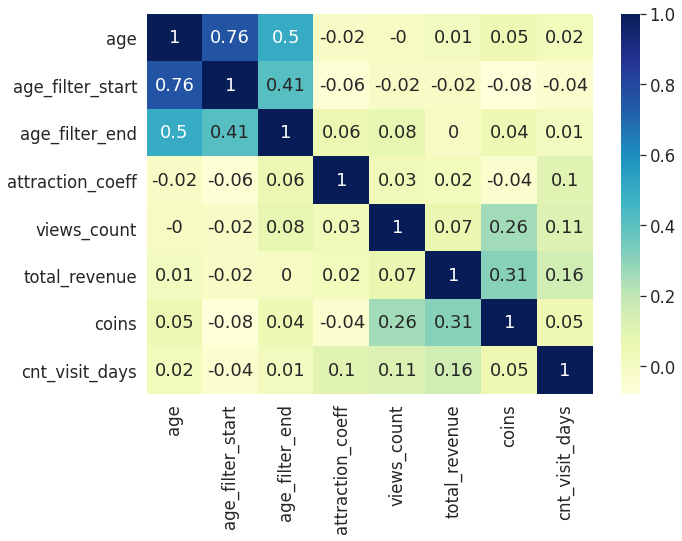

In [68]:
corr_mat_control_2 = users_control_2[["age", "age_filter_start", "age_filter_end", 
                                      "attraction_coeff", "views_count", "total_revenue",
                                      "coins", "cnt_visit_days"]].corr()

display(corr_mat_control_2)

dataplot = sns.heatmap(corr_mat_control_2.round(2), cmap="YlGnBu", annot=True)

plt.show()

1) Как мы видим выше хорошо между собой коррелируют age, age_filter_start и age_filter_end, в целом это ожидаемо так как люди определенных возрастов, себе в соответствие ищут партнеров.
<br/>
2) views_count и coins довольно хорошо коррелируют, кроме группы control_2, я полагаю потому что тут либо монетки получают за просмотры или монетки нужно платить за просмотры. Кстати в control_2 coins немного коррелирует с total_revenue, а в других группах нет, возможно просто случайность.
<br/>
3) В целом большая часть признаков не коррелируют друг с другом, короме некоторых, которые коррелируют немного.

####  Посмотрим на данные с датами

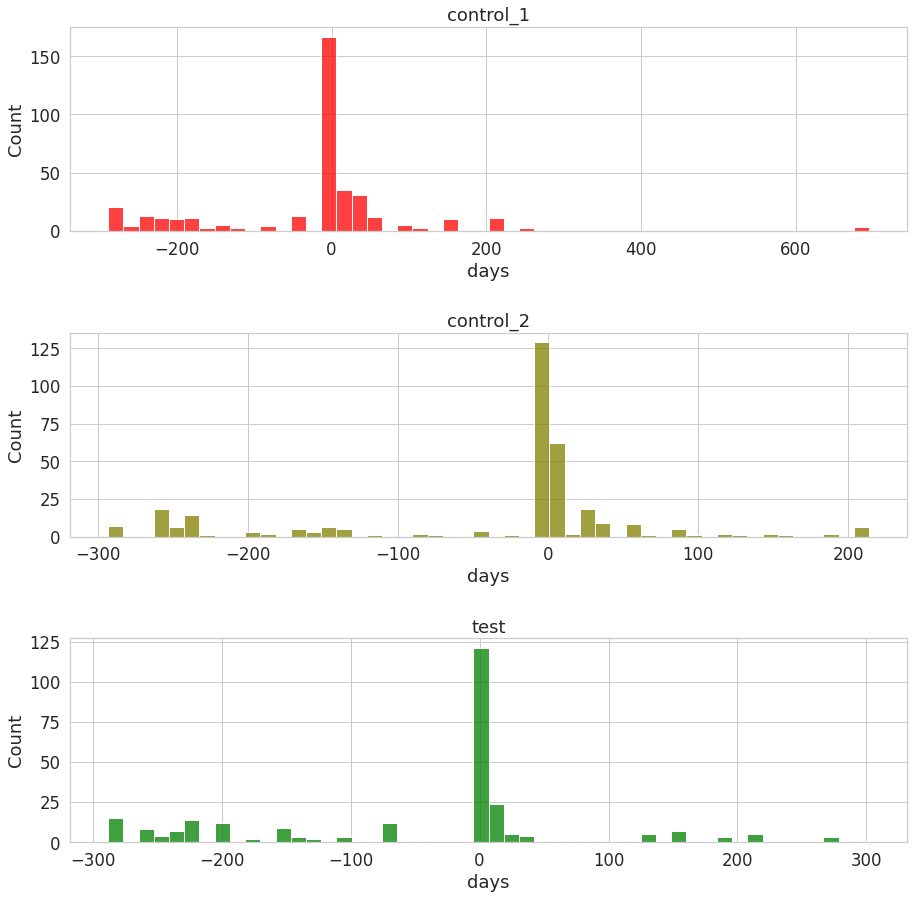

In [69]:
t_control_1 = transactions_control_1[~transactions_control_1.uid.isna()]
t_control_2 = transactions_control_2[~transactions_control_2.uid.isna()]
t_test_dt = transactions_test[~transactions_test.uid.isna()]

t_control_1_gr = t_control_1.groupby("uid", as_index=False)\
                            .agg({"paid_at": "min"})\
                            .rename(columns={"paid_at": "first_payment"})
t_control_2_gr = t_control_2.groupby("uid", as_index=False)\
                            .agg({"paid_at": "min"})\
                            .rename(columns={"paid_at": "first_payment"})
t_test_dt_gr = t_test_dt.groupby("uid", as_index=False)\
                        .agg({"paid_at": "min"})\
                        .rename(columns={"paid_at": "first_payment"})

t_control_1_gr = t_control_1_gr.merge(t_control_1, 
                                      on="uid", 
                                      how="inner")[["uid", "joined_at", 
                                                    "first_payment", "product_type"]]

t_control_2_gr = t_control_2_gr.merge(t_control_2, 
                                      on="uid", 
                                      how="inner")[["uid", "joined_at", 
                                                    "first_payment", "product_type"]]

t_test_dt_gr = t_test_dt_gr.merge(t_test_dt, 
                                  on="uid", 
                                  how="inner")[["uid", "joined_at", 
                                                "first_payment", "product_type"]]

t_control_1_gr["days"] = (t_control_1_gr["first_payment"] - t_control_1_gr["joined_at"]).dt.days
t_control_2_gr["days"] = (t_control_2_gr["first_payment"] - t_control_2_gr["joined_at"]).dt.days
t_test_dt_gr["days"] = (t_test_dt_gr["first_payment"] - t_test_dt_gr["joined_at"]).dt.days

make_hist(t_control_1_gr, t_control_2_gr, t_test_dt_gr, "days", size=(15, 15))

Выше мы находили минимальную дату в группировке uid, чтобы выяснить дату первого платежа пользователя. После чего отняв эту дату от даты того как клиент зарегестрировалcя мы получаем минимальное количество дней когда пользователь совершил первую покупку. Гистограммы выше показывют отрицательные дни во всех 3х группах что свидетельствует о том, что пользователь как-то совершал покупку до регестрации что достаточно странно. Походу в этом плане с данными связанные с датами что-то не так. 

In [70]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={"figure.figsize": (20, 7)}
)

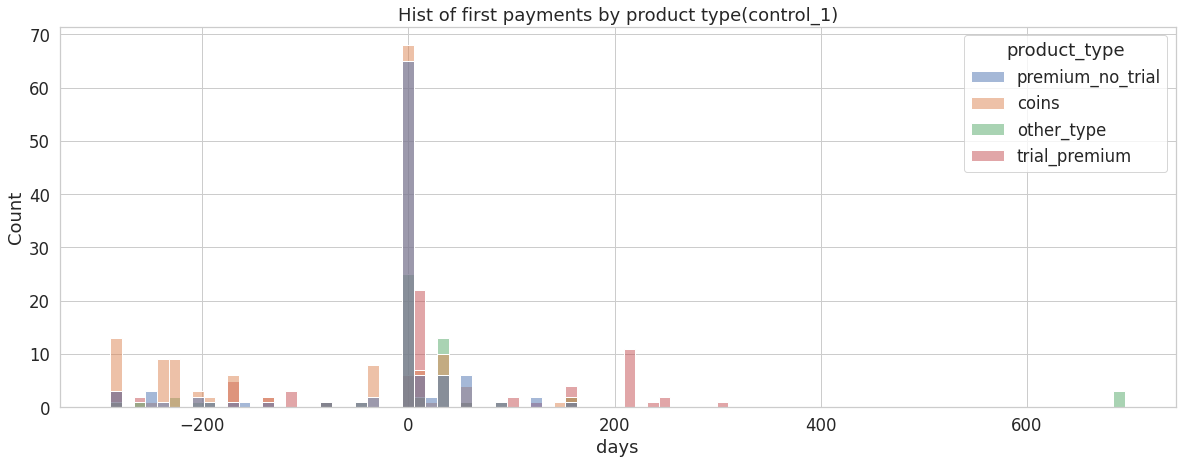

In [71]:
g1 = sns.histplot(data=t_control_1_gr, x="days", hue="product_type")
g1.set(title="Hist of first payments by product type(control_1)")
plt.show()

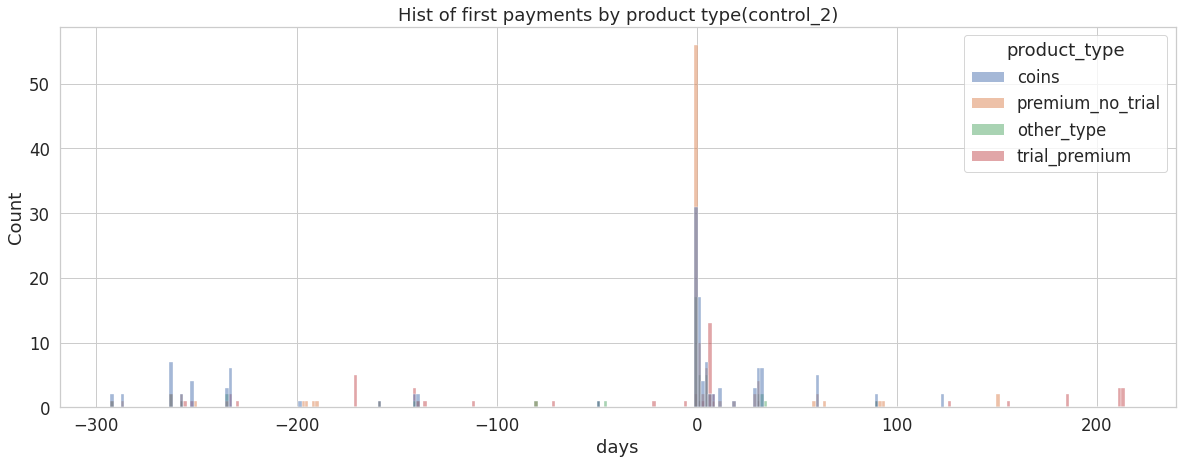

In [72]:
g2 = sns.histplot(data=t_control_2_gr, x="days", hue="product_type")
g2.set(title="Hist of first payments by product type(control_2)")
plt.show()

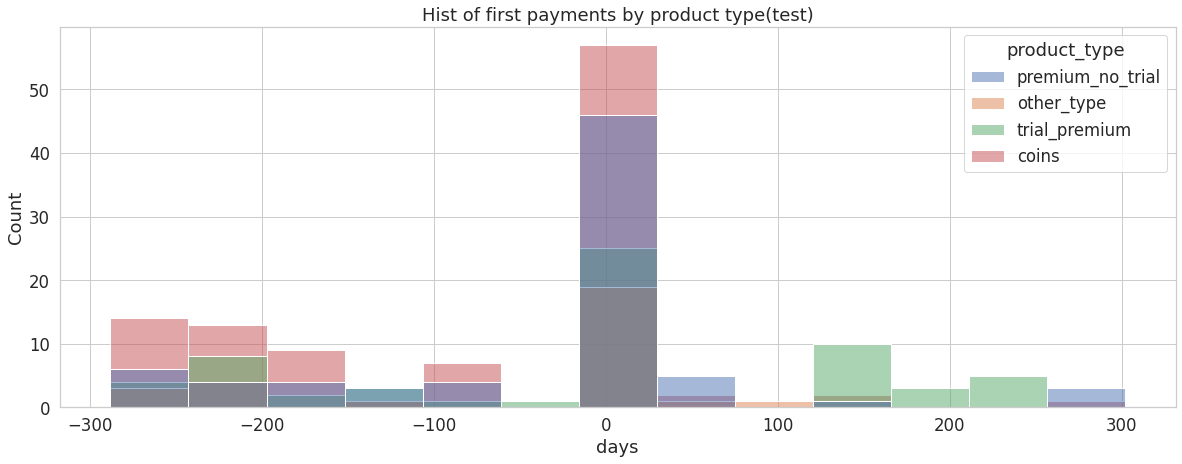

In [73]:
g2 = sns.histplot(data=t_test_dt_gr, x="days", hue="product_type")
g2.set(title="Hist of first payments by product type(test)")
plt.show()

Как мы видим выше, преимущественно в отрицательные и нулевые дни обычно покупают coins.
<br/>
Так же в нулевые и положительные дни люди преобретают trial_premium и premium_no_trial.

**Анализ в разрезе возраста, стран и gender**

Пока избавимся от выбросов в переменной age и будем эти данные использовать в дальнейшем в Detailed anlysis

In [74]:
users_test_m = del_outliers(users_test, "age")
users_control_1_m = del_outliers(users_control_1, "age")
users_control_2_m = del_outliers(users_control_2, "age")
users_control_m = pd.concat([users_control_1_m, users_control_2_m])
transactions_control_m = pd.concat([transactions_control_1, 
                                    transactions_control_2])

Соединение датафреймов для упрощения анализа и сформируем 2 датафрейма, 1 соединение 3 датафреймов и 2 сформируем из 1го только по платящим юзерам с удалением выбросов по total_revenue

In [75]:
users_control_1_m["group_name"] = "control_1"
users_control_2_m["group_name"] = "control_2"
users_test_m["group_name"] = "test"

full_users = pd.concat([users_control_1_m, users_control_2_m, users_test_m])
full_users_wo = del_outliers(full_users[full_users.total_revenue > 0], "total_revenue")

In [76]:
print("Средний возраст юзера:", full_users.age.mean())
print("Средний возраст платящего юзера:", full_users[full_users.total_revenue > 0].age.mean())

Средний возраст юзера: 31.623610458744324
Средний возраст платящего юзера: 31.700575815738965


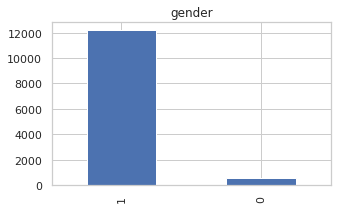

In [77]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={"figure.figsize": (5, 3)}
)


full_users.gender.value_counts().to_frame().plot(kind="bar", 
                                                 title="gender",
                                                 legend=False)
plt.show()

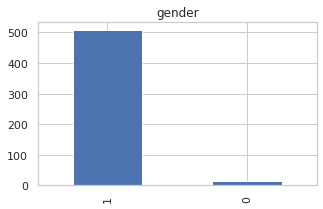

In [78]:
full_users[full_users.total_revenue > 0].gender.value_counts().to_frame().plot(kind="bar", 
                                                                               title="gender",
                                                                               legend=False)
plt.show()

Как мы видим выше, что основная аудитория и платящая аудитория по gender это 1(можно предположить что это мужчины, так как обычно это основные юзеры дейтинговых приложений)

Посмотрим на общее распределение возрастов по странам

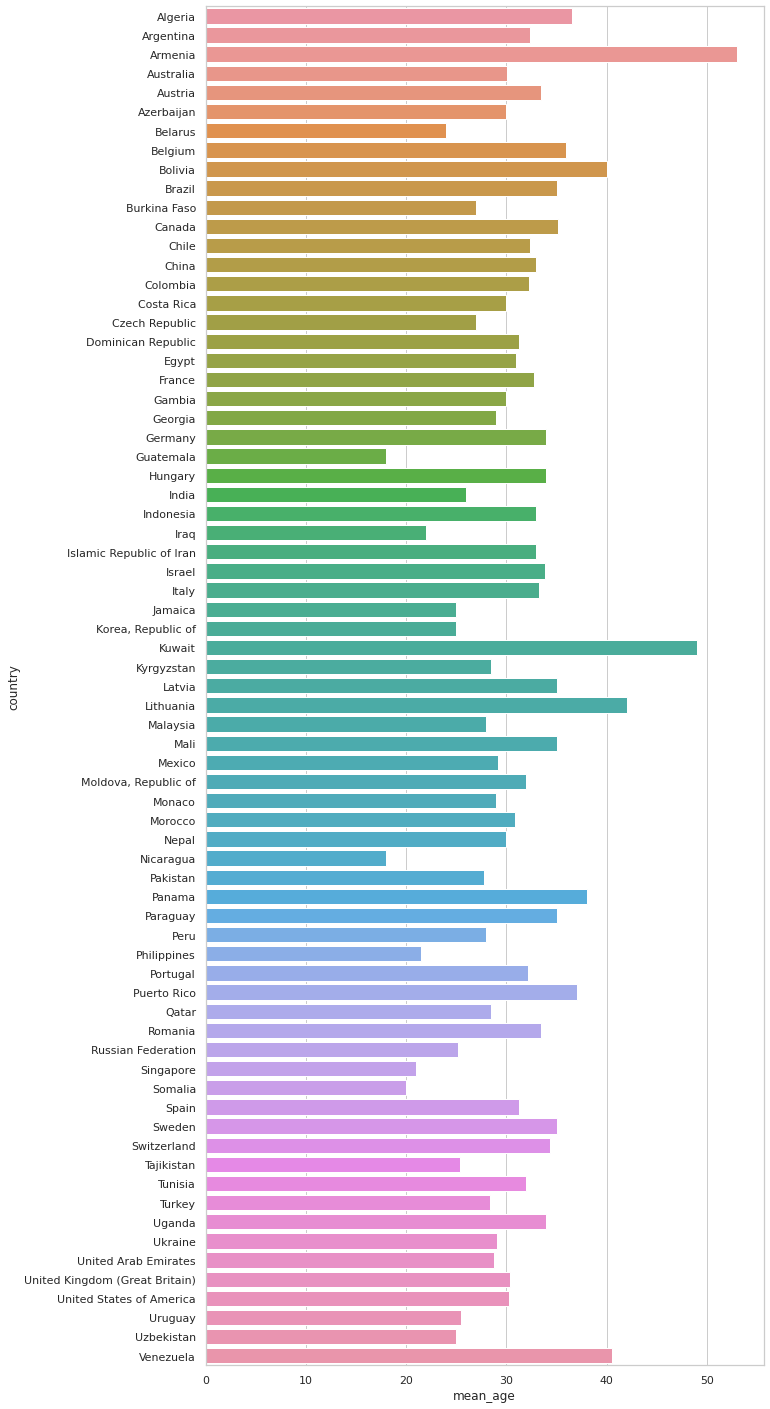

In [79]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={"figure.figsize": (10, 25)}
)

data_for_bar_age_1 = full_users.groupby("country", as_index=False)\
                               .agg({"age": "mean"})\
                               .rename(columns={"age": "mean_age"})

sns.barplot(data=data_for_bar_age_1, x="mean_age", y="country")
plt.show()

Видно, что в основном +- 30 летние люди пользуются приложением, Kuwait, Bolivia, Luthuania и Venezuela имеет средний возраст от 40 лет, Armenia более 50

Построим прибыль в зависимости от пола

In [80]:
full_users.groupby(["group_name", "gender"], as_index=False)\
          .agg({"total_revenue": "mean"})\
          .rename(columns={"total_revenue": "mean_total_revenue"})

,group_name,gender,mean_total_revenue
0,control_1,0,252.272222
1,control_1,1,611.345745
2,control_2,0,210.613402
3,control_2,1,466.276171
4,test,0,136.075377
5,test,1,545.297557


Видно, что женщины приносят прибыли в среднем меньше, чем мужчины

Построим прибыль в зависимости от пола с удаление выбросов и оставим только платящих клиентов

In [81]:
full_users_wo.groupby(["group_name", "gender"], as_index=False)\
             .agg({"total_revenue": "mean"})\
             .rename(columns={"total_revenue": "mean_total_revenue"})

,group_name,gender,mean_total_revenue
0,control_1,0,11352.250000
1,control_1,1,9187.915254
2,control_2,0,5837.000000
3,control_2,1,9120.482558
4,test,0,13539.500000
5,test,1,10812.256000


После удаления выбросов только в control_2 в среднем женщины приносят меньше прибыли чем мужчины

Построим график прибыли от возраста

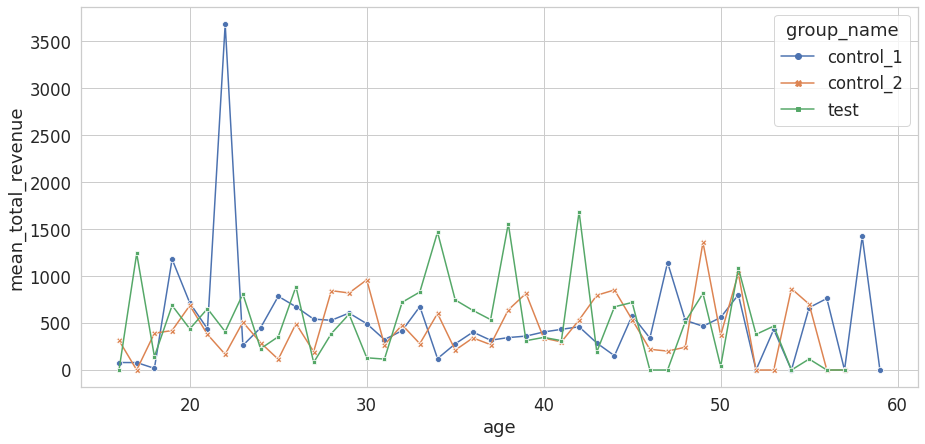

In [82]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={"figure.figsize": (15, 7)}
)

data_for_line_1 = full_users.groupby(["group_name", "age"], as_index=False)\
                            .agg({"total_revenue": "mean"})\
                            .rename(columns={"total_revenue": "mean_total_revenue"})

sns.lineplot(data=data_for_line_1, y="mean_total_revenue", 
             x="age", hue="group_name", style="group_name",
             markers=True, dashes=False)
plt.show()

Как мы видим выше, в первой половине 20 лет есть аномальное значение, похожее на выброс, удалим выбросы, оставим только платящих юзеров и посмотрим на график.

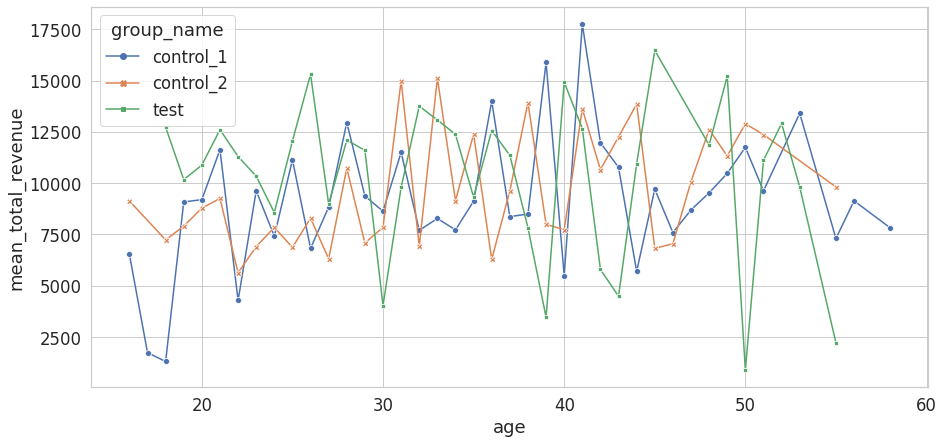

In [83]:
data_for_line_2 = full_users_wo.groupby(["group_name", "age"], as_index=False)\
                               .agg({"total_revenue": "mean"})\
                               .rename(columns={"total_revenue": "mean_total_revenue"})

sns.lineplot(data=data_for_line_2, y="mean_total_revenue", 
             x="age", hue="group_name", style="group_name",
             markers=True, dashes=False)
plt.show()

In [84]:
data_for_line_2.groupby("group_name", as_index=False).agg({"mean_total_revenue": "mean"})

,group_name,mean_total_revenue
0,control_1,9160.666931
1,control_2,9648.156127
2,test,10386.507415


На графике видны возраста юзеров которые в тесте платили больше чем в контролах, а есть те кто меньше, но визуально видно что средняя прибыль с юзеров в тесте выше чем в контролах

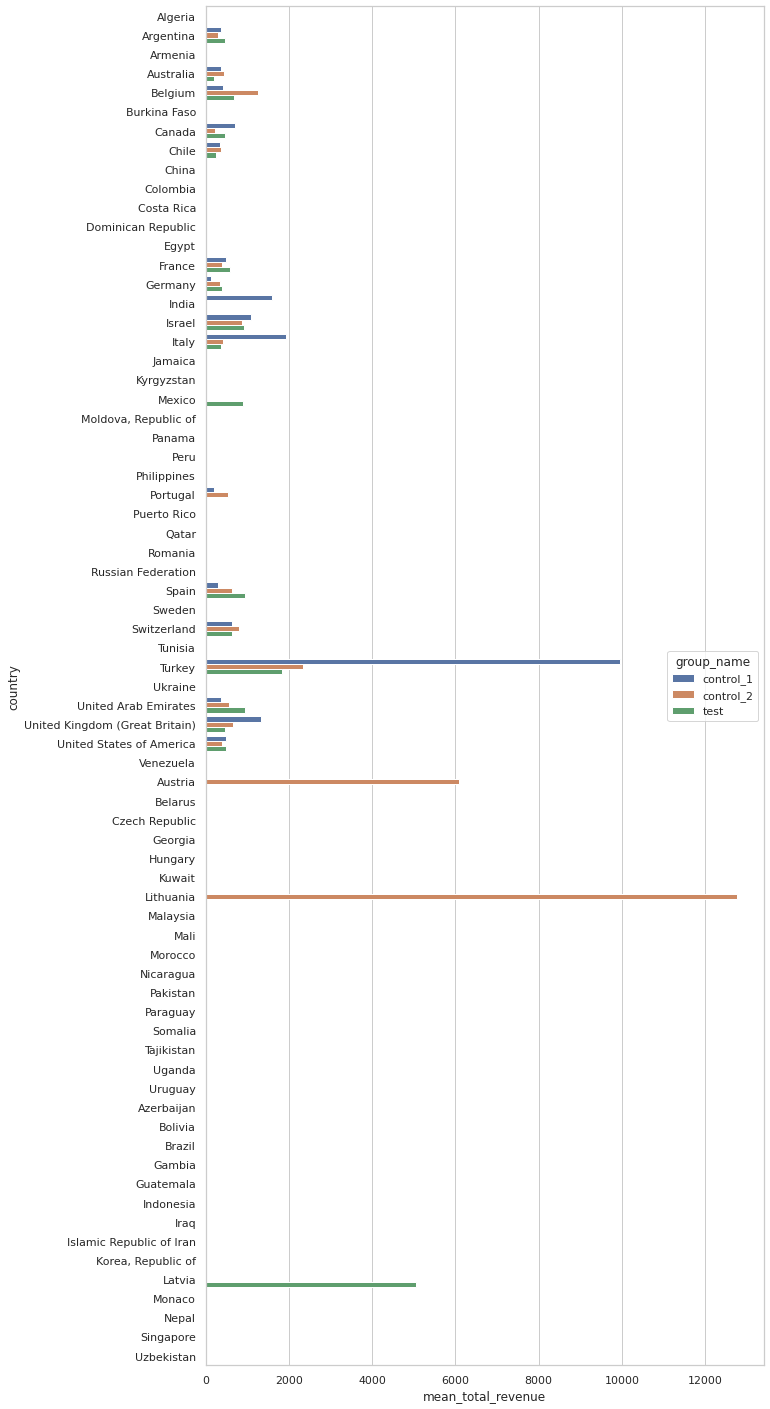

In [85]:
sns.set(
    font_scale=1,
    style="whitegrid",
    rc={"figure.figsize": (10, 25)}
)

data_for_bar_1 = full_users.groupby(["group_name", "country"], as_index=False)\
                           .agg({"total_revenue": "mean"})\
                           .rename(columns={"total_revenue": "mean_total_revenue"})

sns.barplot(data=data_for_bar_1, x="mean_total_revenue", y="country", hue="group_name")
plt.show()

Видим большое количество стран из которых прибыль приложение не получает, посмотрим сколько их и посчитаем их.

In [86]:
list_countries_0_rev = data_for_bar_1[data_for_bar_1.mean_total_revenue == 0].country.values

perc_inc = round(100 * (list_countries_0_rev.shape[0] / data_for_bar_1.shape[0]))

print("Список стран с которых приложение не имеет прибыли",
      f"за выделенный период, что примерно {perc_inc} %:\n")
for i in list_countries_0_rev:
    print(i)

Список стран с которых приложение не имеет прибыли за выделенный период, что примерно 60 %:

Algeria
Armenia
Burkina Faso
China
Colombia
Costa Rica
Dominican Republic
Egypt
Jamaica
Kyrgyzstan
Mexico
Moldova, Republic of
Panama
Peru
Philippines
Puerto Rico
Qatar
Romania
Sweden
Tunisia
Ukraine
Venezuela
Belarus
China
Colombia
Czech Republic
Dominican Republic
Georgia
Hungary
India
Kuwait
Kyrgyzstan
Malaysia
Mali
Mexico
Morocco
Nicaragua
Pakistan
Paraguay
Peru
Qatar
Russian Federation
Somalia
Tajikistan
Uganda
Ukraine
Uruguay
Algeria
Azerbaijan
Bolivia
Brazil
Colombia
Costa Rica
Dominican Republic
Egypt
Gambia
Georgia
Guatemala
Hungary
India
Indonesia
Iraq
Islamic Republic of Iran
Korea, Republic of
Monaco
Morocco
Nepal
Pakistan
Peru
Philippines
Portugal
Puerto Rico
Romania
Russian Federation
Singapore
Tajikistan
Tunisia
Ukraine
Uruguay
Uzbekistan


Удалим выбросы оставим только платящих клиентов и посмотрим как будет выглядеть график

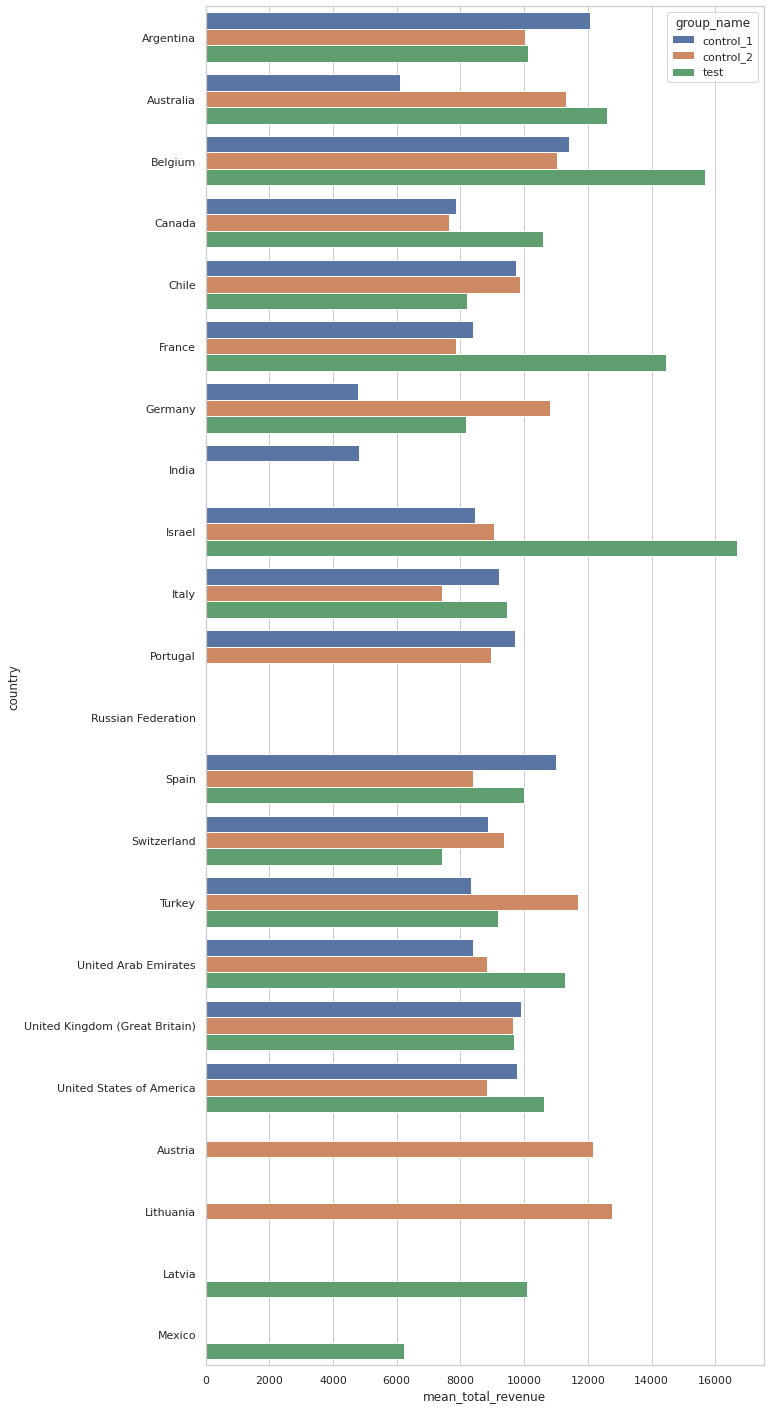

In [87]:
data_for_bar_2 = full_users_wo.groupby(["group_name", "country"], as_index=False)\
                              .agg({"total_revenue": "mean"})\
                              .rename(columns={"total_revenue": "mean_total_revenue"})

sns.barplot(data=data_for_bar_2, x="mean_total_revenue", y="country", hue="group_name")
plt.show()

Визуально видно, что Belgium, France и Israel в тестовой группе принесли прибыли больше.

**Итог по EDA**

Основные факты:
<br/>
1) Основная аудитория приложения это люди с средним возрастом 31-32 год, преимущественно мужчины, страна с которой больше всего платящих и обычных юзеров из USA.
<br/>
2) Примерно с 60 % стран приложение не имеет прибыли.
<br/>
3) Люди ищет себе партнеров примерно их возраста.
<br/>
4) Топ 2 источника откуда люди перешли на страницу оплаты empty_likes, trial_vip_popup.
<br/>
5) Слишком мало людей имели(10%) и имеют премиумы(4%).
<br/>
6) Люди мало получают оценок.
<br/>
7) В приложение обычно заходят только 1 раз.


Ошибки и подозрения в данных:
<br/>
1) age - обнаружены аномальные возраста, например такие как 99 лет, с таким возрастом мало кто будет пользоваться дейтинговым приложением.
<br/>
2) Были обнаружены подозрительные покупки до регистрации человека в приложении, преимщественно покупались coins.
<br/>
3) В первой половине 20 лет было найдено аномальное значение, которое сильно выделяется из всех остальных значений. 

In [88]:
sns.set(
    font_scale=1.5,
    style="whitegrid",
    rc={"figure.figsize": (10, 7)}
)

# Detailed Analysis

Тут мы будем отвечать на основные вопросы по проекту.


Судя по условию проекта, мы имеем дело с **A/A/B тестом**. 
<br/>
Мы имеем 2 контрольные группы и 1 тестовую группу, тогда анализ мы будем проводить следующим образом:
<br/>
- Сначало мы проверим результаты **A/A теста** то есть сравним метрики на наличие эффекта 2х контольных групп, для того, чтобы понять что группы одни и те же и ничего в какой-то из групп не пошло что-то не так. То есть если тест покажет значимые отличия, то будем считать, что статистически значимого отличия нет(в рамках A/A/B теста), поскольку мы не знаем с какой именно из групп что-то пошло не так. Возможно со сбором данных что-то пошло не так и A/A/B тест лучше запустить заново.
- Если значимых отличий найдено не будет, то проверим результаты уже **A/B теста**, где группа А это сразу 2 контрольные группы, а В тестовая.

Не совсем понятно с какой целью проводилс A/A/B тест. 
<br/>
Мы рассмотрим 2 цели с которыми возможно этот тест проводился:
- Дейтинговое приложение только недавно вышло в рынок и сейчас скорее выгоднее работать именно на сбор аудитории нежели чем на прибыль, то есть собираем аудиторию, а потом потихоньку переходим на статдию монетизации. Тут например может быть с этой целью уменьшение стоимости подписки, чтобы посмотреть не стало ли людей больше.
- Дейтинговое приложение уже относительно давно на рынке и сейчас уже надо повышать прибыль с юзеров, то есть аудитории у нас много, спрос высокой, следовательно можно повысить прибыль на премиум подписки.

**В первом случае нас будут интересовать следующие метрики:**
<br/>
1) Общее среднее количество визитов. 
<br/>
- H0: общее среднее количество визитов не поменялось 
- H1: общее среднее количество визитов стало больше. 

2) Cреднее количество визитов по странам.

- H0: среднеее количество визитов не поменялось. 
- H1: среднее количество визитов стало больше.
<br/>

3) Доля клиентов у которых был и остался премиум.
- H0: Доля клиентов у которых был и остался премиум не поменялась. 
- H1: Доля клиентов у которых был и остался премиум стала больше.
<br/>

4) Доля клиентов у которых был и остался премиум по странам.
- H0: Доля клиентов у которых был и остался премиум по странам не поменялась. 
- H1: Доля клиентов у которых был и остался премиум по странам стала больше.
<br/>

5) Доля клиентов у которых есть premium_no_trial.
- H0: Доля клиентов у которых есть premium_no_trial не поменялась. 
- H1: Доля клиентов у которых есть premium_no_trial стала больше.
<br/>

6) Доля клиентов у которых premium_no_trial по странам.
- H0: Доля клиентов у которых есть premium_no_trial по странам не поменялась. 
- H1: Доля клиентов у которых есть premium_no_trial по странам стала больше.
<br/>


**Во втором случае нас будут интересовать слудующие метрики:**
<br/>
1) ARPU(в общем) - средняя выручка на каждого пользователя.
- H0: ARPU(в общем) не поменялось. 
- H1: ARPU(в общем) стало больше.
<br/>

2) ARPU(по странам) - средняя выручка на каждого пользователя(в рамках одной страны).
- H0: ARPU(по странам) не поменялось. 
- H1: ARPU(по странам) стало больше.
<br/>

3) ARPPU(в общем) - средняя выручка на каждого пользователя, только среди тех юзеров которые совершают покупки.
- H0: ARPPU(в общем) не поменялось. 
- H1: ARPPU(в общем) стало больше.
<br/>

4) ARPPU(по странам) - средняя выручка на каждого пользователя, только среде тех юзеров которые совершают покупки(в рамках одной страны).
- H0: ARPPU(по странам) не поменялось. 
- H1: ARPPU(по странам) стало больше.
<br/>

5) Конверсия в покупку.
- H0: Конверсия в покупку не поменялась. 
- H1: Конверсия в покупку стала больше.
<br/>

6) Конверсия в покупку по странам.
- H0: Конверсия по странам в покупку не поменялась. 
- H1: Конверсия по странам в покупку стала больше.
<br/>

7) RPR(в общем) - доля клиентов, которые совершают покупки более одного раза в общем.
- H0: RPR(в общем) не поменялось. 
- H1: RPR(в общем) стало больше.
<br/>

8) RPR(по странам) - доля клиентов, которые совершают покупки более одного раза по странам.
- H0: RPR(по странам) не поменялось. 
- H1: RPR(по странам) стало больше.
<br/>

*По странам рассматриваем, потому что в разных странах разный доход, и повышение или понижение цены на премиум аккаунты могут повлиять на них по разному. При этом выше в EDA было замечено, что по странам в некоторых странах мы видели визуально, что на тесте средня выручка была больше чем на контролах.*

*По возросту смотреть не стоит, так выше в EDA мы видели что по единичным возрастам средняя прибыль в тесте была выше и ниже чем в контроле и выделить их в отдельные непрерывные группы тяжело, вдобавок  клиенту будет сложно объяснить почему например 30 летнему цена за премиум N1, а 40 летнему N2, плюс он может счесть это как дискриминация по возрасту или вообще подделать свой возраст.*

*По полу смотреть не стоит, примерно по тем же причинам что и по возрасту, несмотря на то, что мы видели визульные различия в средней прибыли в зависимости от пола и групп.*

*По страницы по которой клиент решил преобрести покупку, можно делать только может быть скидки, но не менять цену, так как это ценовая дискриминация.*

**Тесты которые участвуют в анализе A/A/B теста**:
<br/>
- **Бутстрап**(маркер bt), используется для всех результатов.
- **t-test**(маркер tt), используется почти для всех результатов, кроме конверсии.
- **mannwhitneyu**(маркер mw), используется для анализа количественных переменных.
- **Хи-квадрат**(маркер ch), используется для анализа бинарных переменных (0, 1).
- **anova**(маркер av), используется для анализа всех результатов, кроме конверсии.
- **proportions_ztest**(маркер pz),  используется для анализа бинарных переменных (0, 1) и конверсии.

**Выделим топ 15 стран с наибольшим количеством юзеров и будем анализировать их, так как дальше юзеров совсем мало и смысла анализировать их особо нет**

In [89]:
countries = users_control_m.groupby("country", as_index=False)\
                           .agg({"uid": "count"})\
                           .sort_values(by="uid", ascending=False)\
                           .head(15).country.values

Фильтрация датафреймов по этим странам

In [90]:
users_control_1_m = users_control_1_m[users_control_1_m["country"].isin(countries)]
users_control_2_m = users_control_2_m[users_control_2_m["country"].isin(countries)]
users_control_m = pd.concat([users_control_1_m, users_control_2_m])

transactions_control_1_m = transactions_control_1[transactions_control_1["country"].isin(countries)]
transactions_control_2_m = transactions_control_2[transactions_control_2["country"].isin(countries)]                                               
transactions_control_m = pd.concat([transactions_control_1_m, transactions_control_2_m])

transactions_test_m = transactions_test[transactions_test["country"].isin(countries)]

#### Первый случай

**1) Общее среднее количество визитов.**

A/A тест.

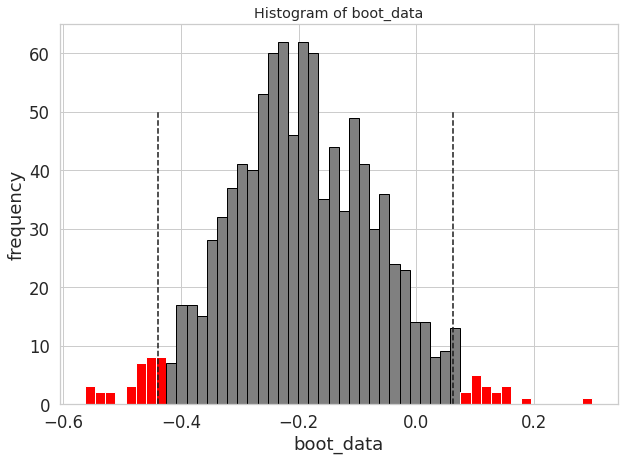

bt_p_value: 0.127
borders_con_interval: 


,0
0.025,-0.438775
0.975,0.061775


p_value_tt: 0.129
p_value_av: 0.388 av_dec: less
p_value_mw: 0.065


In [91]:
np.random.seed(10)

aa_bt = get_bootstrap(users_control_1_m.cnt_visit_days, users_control_2_m.cnt_visit_days)
aa_tt = get_t_test(users_control_1_m.cnt_visit_days, users_control_2_m.cnt_visit_days)
aa_av = get_anova(users_control_1_m, users_control_m, "cnt_visit_days")
aa_mw = get_mannwhitneyu(users_control_1_m.cnt_visit_days, users_control_2_m.cnt_visit_days)

print(f"bt_p_value: {round(aa_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(aa_bt['quants'])

print(f"p_value_tt: {round(aa_tt[0], 3)}")
print(f"p_value_av: {round(aa_av[0], 3)}", f"av_dec: {aa_av[2]}")
print(f"p_value_mw: {round(aa_mw[0], 3)}")

Как мы видим p_value > 0.05 у всех тестов и доверительный интервал включает 0, а значит значимых отличий нет, анализируем A/B тест.

A/B тест.

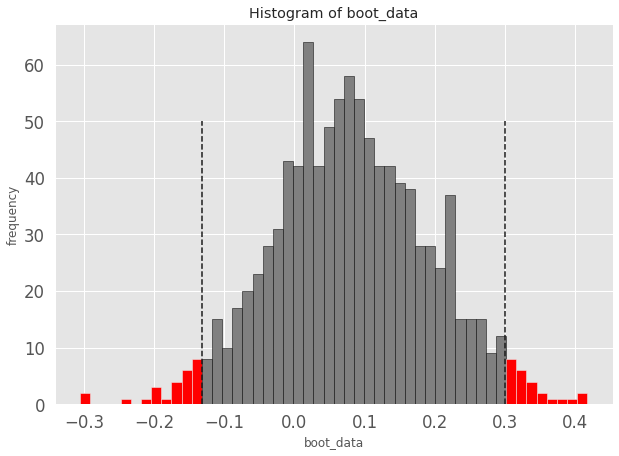

bt_p_value: 0.463
borders_con_interval: 


,0
0.025,-0.132291
0.975,0.300744


p_value_tt: 0.243
p_value_av: 0.485 av_dec: greater
p_value_mw: 0.039


In [92]:
np.random.seed(10)

ab_bt = get_bootstrap(users_control_m.cnt_visit_days, users_test_m.cnt_visit_days)
ab_tt = get_t_test(users_control_m.cnt_visit_days, users_test_m.cnt_visit_days, altr="less")
ab_av = get_anova(users_control_m, users_test_m, "cnt_visit_days")
ab_mw = get_mannwhitneyu(users_control_m.cnt_visit_days, users_test_m.cnt_visit_days, altr="less")

print(f"bt_p_value: {round(ab_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(ab_bt['quants'])

print(f"p_value_tt: {round(ab_tt[0], 3)}")
print(f"p_value_av: {round(ab_av[0], 3)}", f"av_dec: {ab_av[2]}")
print(f"p_value_mw: {round(ab_mw[0], 3)}")

Как мы видим p_value > 0.05 у всех тестов кроме mw и доверительный интервал включает 0, а значит значимых отличий нет.

То есть в плане посещаемости данное приложение не подросло по 3 тестам, а по mw подросло.

**2) Cреднее количество визитов по странам.**

A/A тест.

In [93]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(users_control_1_m, users_control_2_m, 
                               list_of_gr=countries, col="cnt_visit_days")
df_tt = get_res_test_t_test(users_control_1_m, users_control_2_m, countries, "cnt_visit_days")
df_av = get_res_test_anova(users_control_1_m, users_control_2_m, countries, "cnt_visit_days")
df_mw = get_res_test_manwh(users_control_1_m, users_control_2_m, countries, "cnt_visit_days")

multimerge(df_bt, df_tt, df_av, df_mw)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,mw_p_value,mw_has_effect
0,United States of America,0.113880,-0.794928,0.083320,0,0.099533,0,0.099533,0,less,0.185028,0
1,Argentina,0.177745,-1.537770,0.292823,0,0.173451,0,0.173451,0,less,0.068177,0
2,France,0.982288,-0.885864,0.894314,0,0.930295,0,0.930295,0,greater,0.899644,0
3,Spain,0.816085,-0.756638,0.932623,0,0.814041,0,0.814041,0,greater,0.866621,0
4,Italy,0.766786,-1.000440,0.700210,0,0.724758,0,0.724758,0,less,0.691426,0
5,Chile,0.685048,-0.718986,1.082526,0,0.692680,0,0.692680,0,greater,0.970833,0
6,United Arab Emirates,0.728680,-1.166510,0.839135,0,0.763375,0,0.763375,0,less,0.195630,0
7,Germany,0.160187,-0.303064,2.216832,0,0.137579,0,0.137579,0,greater,0.317072,0
8,United Kingdom (Great Britain),0.202798,-0.528063,2.330418,0,0.209726,0,0.209726,0,greater,0.077715,0
9,Canada,0.096847,-2.641737,0.114566,0,0.114045,0,0.114045,0,less,0.500007,0


Как мы видим p_value > 0.05 для всех тестов и доверительный интервал включает 0 для каждой из стран, а значит значимых отличий нет, анализируем A/B тест.

A/B тест.

In [94]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(users_control_m, users_test_m, 
                               list_of_gr=countries, col="cnt_visit_days")
df_tt = get_res_test_t_test(users_control_m, users_test_m, countries, "cnt_visit_days", altr="less")
df_av = get_res_test_anova(users_control_m, users_test_m, countries, "cnt_visit_days")
df_mw = get_res_test_manwh(users_control_m, users_test_m, countries, "cnt_visit_days", altr="less")

multimerge(df_bt, df_tt, df_av, df_mw)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,mw_p_value,mw_has_effect
0,United States of America,0.903261,-0.361098,0.377834,0,0.452952,0,0.905903,0,greater,0.345352,0
1,Argentina,0.123909,-1.191808,0.148469,0,0.915216,0,0.169568,0,less,0.497697,0
2,France,0.730016,-0.859707,0.601629,0,0.623808,0,0.752385,0,less,0.721274,0
3,Spain,0.914458,-0.698457,0.704259,0,0.465414,0,0.930829,0,greater,0.454359,0
4,Italy,0.332562,-0.366752,1.184077,0,0.151031,0,0.302062,0,greater,0.282836,0
5,Chile,0.108542,-1.440871,0.162920,0,0.939119,0,0.121763,0,less,0.035755,1
6,United Arab Emirates,0.104750,-0.110410,1.737719,0,0.045805,1,0.091610,0,greater,0.107564,0
7,Germany,0.545239,-0.784442,1.345529,0,0.277773,0,0.555547,0,greater,0.422607,0
8,United Kingdom (Great Britain),0.673037,-0.915940,1.450163,0,0.345420,0,0.690840,0,greater,0.459234,0
9,Canada,0.241340,-0.577288,2.307137,0,0.104904,0,0.209807,0,greater,0.502539,0


Как мы видим p_value > 0.05 почти для всех методов и доверительный интервал включает 0 для каждой из стран, а значит значимых отличий практически нет так же и для каждой из стран.

То есть в плане посещаемости данное приложение не подросло для каждой из стран, может быть кроме Chile и United Kingdom (Great Britain) по mw и то в меньшую сторону.

**3) Доля клиентов у которых был и остался премиум.**

A/A тест.

Считаем метрику признак наличия премиума в прошлом и в настоящем времени

In [95]:
users_control_1_m["is_was_premium"] = users_control_1_m.is_premium.fillna(0) * users_control_1_m.was_premium.fillna(0)
users_control_2_m["is_was_premium"] = users_control_2_m.is_premium.fillna(0) * users_control_2_m.was_premium.fillna(0)
users_test_m["is_was_premium"] = users_test_m.is_premium.fillna(0) * users_test_m.was_premium.fillna(0)
users_control_m["is_was_premium"] = users_control_m.is_premium.fillna(0) * users_control_m.was_premium.fillna(0)

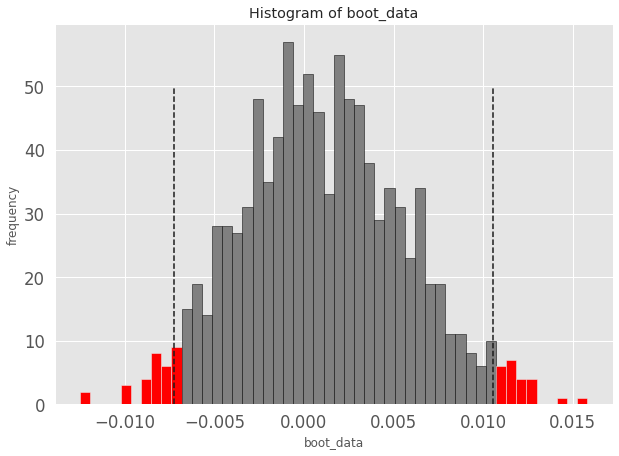

bt_p_value: 0.815
borders_con_interval: 


,0
0.025,-0.007237
0.975,0.010569


p_value_tt: 0.784
p_value_av: 0.875 av_dec: greater
p_value_ch: 0.825 ch_dec: greater
p_value_pz: 0.694


In [96]:
np.random.seed(10)

aa_bt = get_bootstrap(users_control_1_m.is_was_premium, users_control_2_m.is_was_premium)
aa_tt = get_t_test(users_control_1_m.is_was_premium, users_control_2_m.is_was_premium)
aa_av = get_anova(users_control_1_m, users_control_m, "is_was_premium")
aa_ch = get_chisquare(users_control_1_m.is_was_premium, users_control_2_m.is_was_premium)
aa_pz = get_proportions_ztest(users_control_1_m.is_was_premium, users_control_2_m.is_was_premium)

print(f"bt_p_value: {round(aa_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(aa_bt['quants'])

print(f"p_value_tt: {round(aa_tt[0], 3)}")
print(f"p_value_av: {round(aa_av[0], 3)}", f"av_dec: {aa_av[2]}")
print(f"p_value_ch: {round(aa_ch[0], 3)}", f"ch_dec: {aa_ch[2]}")
print(f"p_value_pz: {round(aa_pz[0], 3)}")

Как мы видим p_value > 0.05 для всех тестов и доверительный интервал включает 0, а значит значимых отличий нет, значит можно проводить анализ A/B теста.

A/B тест

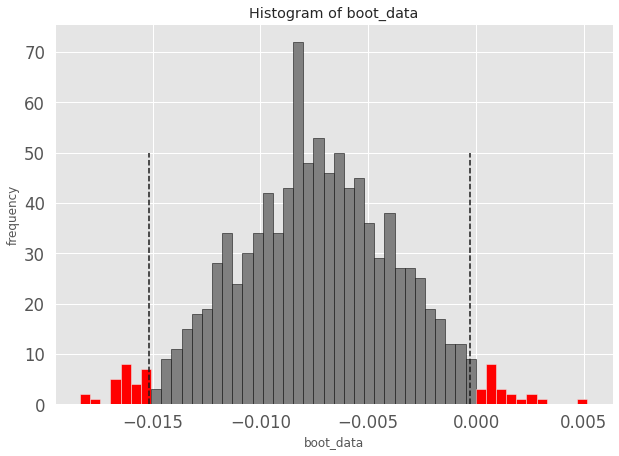

bt_p_value: 0.049
borders_con_interval: 


,0
0.025,-0.015184
0.975,-0.000289


p_value_tt: 0.982
p_value_av: 0.037 av_dec: less
p_value_ch: 0.048 ch_dec: less
p_value_pz: 1.0


In [97]:
np.random.seed(10)

ab_bt = get_bootstrap(users_control_m.is_was_premium, users_test_m.is_was_premium)
ab_tt = get_t_test(users_control_m.is_was_premium, users_test_m.is_was_premium, altr="less")
ab_av = get_anova(users_control_m, users_test_m, "is_was_premium")
ab_ch = get_chisquare(users_control_m.is_was_premium, users_test_m.is_was_premium)
ab_pz = get_proportions_ztest(users_control_m.is_was_premium, users_test_m.is_was_premium, 
                              altr="smaller")

print(f"bt_p_value: {round(ab_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(ab_bt['quants'])

print(f"p_value_tt: {round(ab_tt[0], 3)}")
print(f"p_value_av: {round(ab_av[0], 3)}", f"av_dec: {ab_av[2]}")
print(f"p_value_ch: {round(ab_ch[0], 3)}", f"ch_dec: {ab_ch[2]}")
print(f"p_value_pz: {round(ab_pz[0], 3)}")

Тут видим p_value < 0.05 для почти каждого из тестов и доверительный интервал не включает 0, а значит значимые отличий есть, но к сожалению не в пользу тестовой группы так как доля клиентов у которых был и остался премиум **упала**, то есть люди не предпочли продлевать премиум. Но tt и pz показали скорее противоположные результаты.

**4) Доля клиентов у которых был и остался премиум по странам.**

A/A тест.

In [98]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(users_control_1_m, users_control_2_m, 
                               list_of_gr=countries, col="is_was_premium")
df_tt = get_res_test_t_test(users_control_1_m, users_control_2_m, countries, "is_was_premium")
df_av = get_res_test_anova(users_control_1_m, users_control_2_m, countries, "is_was_premium")
df_ch = get_res_test_chisq(users_control_1_m, users_control_2_m, countries, "is_was_premium")
df_pz = get_res_test_prop_ztst(users_control_1_m, users_control_2_m, list_of_gr=countries, col="is_was_premium")

multimerge(df_bt, df_tt, df_av, df_ch, df_pz)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,ch_p_value,ch_has_effect,ch_dec,pz_p_value,pz_has_effect
0,United States of America,0.715756,-0.011771,0.016791,0,0.744917,0,0.744917,0,greater,0.812612,0,greater,0.641277,0
1,Argentina,0.693620,-0.028317,0.017896,0,0.661398,0,0.661398,0,less,0.824014,0,less,0.552522,0
2,France,0.449348,-0.040694,0.015976,0,0.443115,0,0.443115,0,less,0.560764,0,less,0.308112,0
3,Spain,0.132094,-0.006199,0.051783,0,0.130912,0,0.130912,0,greater,0.192302,0,greater,0.009650,1
4,Italy,0.622428,-0.036086,0.022130,0,0.623536,0,0.623536,0,less,0.784125,0,less,0.487753,0
5,Chile,0.960940,-0.027655,0.028463,0,0.981968,0,0.981968,0,greater,1.000000,0,greater,0.974313,0
6,United Arab Emirates,0.625997,-0.044936,0.028110,0,0.594204,0,0.594204,0,less,0.769316,0,less,0.477562,0
7,Germany,0.841222,-0.029226,0.039431,0,0.866404,0,0.866404,0,greater,1.000000,0,greater,0.809822,0
8,United Kingdom (Great Britain),0.831196,-0.061925,0.048948,0,0.825251,0,0.825251,0,less,1.000000,0,less,0.758655,0
9,Canada,0.926261,-0.052682,0.055832,0,0.964904,0,0.964904,0,greater,1.000000,0,greater,0.949585,0


Как мы видим p_value > 0.05 для каждого из тестов и доверительный интервал включает 0 для каждой из стран, а значит значимых отличий нет, анализируем A/B тест. Spain и Belgium (по pz) имеют значимые отличия.

A/B тест

In [99]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(users_control_m, users_test_m, 
                               list_of_gr=countries, col="is_was_premium")
df_tt = get_res_test_t_test(users_control_m, users_test_m, countries, "is_was_premium", altr="less")
df_av = get_res_test_anova(users_control_m, users_test_m, countries, "is_was_premium")
df_ch = get_res_test_chisq(users_control_m, users_test_m, countries, "is_was_premium")
df_pz = get_res_test_prop_ztst(users_control_m, users_test_m, list_of_gr=countries, 
                               col="is_was_premium", altr="smaller")

multimerge(df_bt, df_tt, df_av, df_ch, df_pz)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,ch_p_value,ch_has_effect,ch_dec,pz_p_value,pz_has_effect
0,United States of America,0.136159,-0.020837,0.003372,0,0.928065,0,0.143870,0,less,0.166966,0,less,0.993138,0
1,Argentina,0.226191,-0.027073,0.006213,0,0.860868,0,0.278263,0,less,0.375635,0,less,0.960556,0
2,France,0.914468,-0.021896,0.027048,0,0.434557,0,0.869114,0,greater,0.998340,0,greater,0.384751,0
3,Spain,0.507046,-0.018106,0.037840,0,0.241291,0,0.482583,0,greater,0.599590,0,greater,0.097144,0
4,Italy,0.405278,-0.033298,0.016049,0,0.791397,0,0.417207,0,less,0.538126,0,less,0.909412,0
5,Chile,0.654703,-0.029315,0.019577,0,0.665908,0,0.668184,0,less,0.832486,0,less,0.770070,0
6,United Arab Emirates,0.199387,-0.010385,0.060380,0,0.104336,0,0.208673,0,greater,0.283789,0,greater,0.010723,1
7,Germany,0.991961,-0.029580,0.033842,0,0.470911,0,0.941822,0,greater,1.000000,0,greater,0.449986,0
8,United Kingdom (Great Britain),0.258771,-0.065294,0.019567,0,0.860646,0,0.278708,0,less,0.380891,0,less,0.952389,0
9,Canada,0.947349,-0.046577,0.047607,0,0.523354,0,0.953292,0,less,1.000000,0,less,0.540011,0


Как мы видим p_value > 0.05 почти для каждого теста и доверительный интервал включает 0 для каждой из стран, а значит значимых отличий нет, кроме Portugal(по bt и av) и United Arab Emirates(по pz). То есть премиумы по странам продлевают примерно также как и раньше за исключением Portugal и United Arab Emirates. А вот United States of America, Argentina и Israel скорее просели по этому параметру.

**5) Доля клиентов у которых есть premium_no_trial.**

Предобработка данных

In [100]:
tr_con_1 = transactions_control_1_m[~transactions_control_1_m.uid.isna()]
tr_con_2 = transactions_control_2_m[~transactions_control_2_m.uid.isna()]
tr_con = transactions_control_m[~transactions_control_m.uid.isna()]
tr_tst = transactions_test_m[~transactions_test_m.uid.isna()]

tr_con_1.loc[:, "is_premium_no_trial"] = (tr_con_1["product_type"] == "premium_no_trial").astype(int)
tr_con_2.loc[:, "is_premium_no_trial"] = (tr_con_2["product_type"] == "premium_no_trial").astype(int)
tr_con.loc[:, "is_premium_no_trial"] = (tr_con["product_type"] == "premium_no_trial").astype(int)
tr_tst.loc[:, "is_premium_no_trial"] = (tr_tst["product_type"] == "premium_no_trial").astype(int)

A/A тест

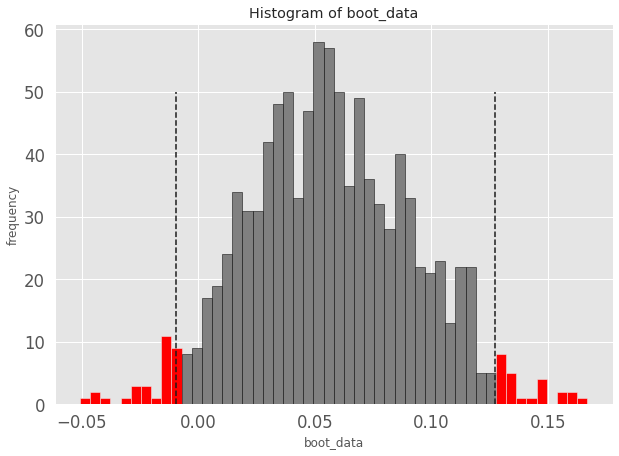

bt_p_value: 0.107
borders_con_interval: 


,0
0.025,-0.009503
0.975,0.127412


p_value_tt: 0.117
p_value_av: 0.117 av_dec: greater
p_value_ch: 0.137
p_value_pz: 0.018


In [101]:
np.random.seed(10)

aa_bt = get_bootstrap(tr_con_1.is_premium_no_trial, tr_con_2.is_premium_no_trial)
aa_tt = get_t_test(tr_con_1.is_premium_no_trial, tr_con_2.is_premium_no_trial)
aa_av = get_anova(tr_con_1, tr_con_2, "is_premium_no_trial")
aa_ch = get_chisquare(tr_con_1.is_premium_no_trial, tr_con_2.is_premium_no_trial)
aa_pz = get_proportions_ztest(tr_con_1.is_premium_no_trial, tr_con_2.is_premium_no_trial)

print(f"bt_p_value: {round(aa_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(aa_bt['quants'])

print(f"p_value_tt: {round(aa_tt[0], 3)}")
print(f"p_value_av: {round(aa_av[0], 3)}", f"av_dec: {aa_av[2]}")
print(f"p_value_ch: {round(aa_ch[0], 3)}")
print(f"p_value_pz: {round(aa_pz[0], 3)}")

Как мы видим p_value > 0.05 для каждого из тестов, кроме pz и доверительный интервал включает 0, а значит значимые отличий нет, значит можно проводить анализ A/B теста.

A/B тест

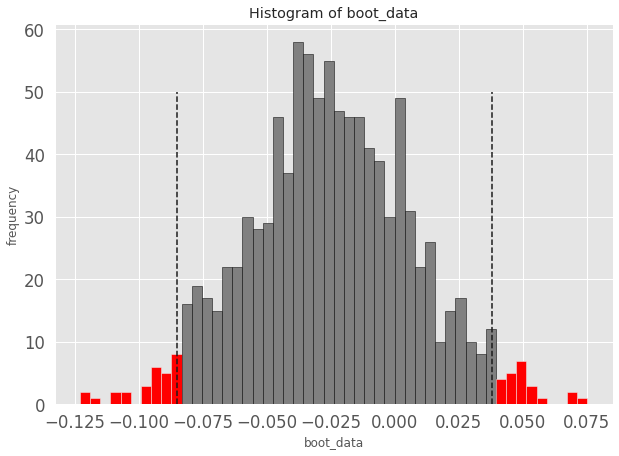

bt_p_value: 0.431
borders_con_interval: 


,0
0.025,-0.084991
0.975,0.037953


p_value_tt: 0.786
p_value_av: 0.429 av_dec: less
p_value_ch: 0.476
p_value_pz: 0.137


In [102]:
np.random.seed(10)

ab_bt = get_bootstrap(tr_con.is_premium_no_trial, tr_tst.is_premium_no_trial)
ab_tt = get_t_test(tr_con.is_premium_no_trial, tr_tst.is_premium_no_trial, altr="less")
ab_av = get_anova(tr_con, tr_tst, "is_premium_no_trial")
ab_ch = get_chisquare(tr_con.is_premium_no_trial, tr_tst.is_premium_no_trial)
ab_pz = get_proportions_ztest(tr_con.is_premium_no_trial, tr_tst.is_premium_no_trial)

print(f"bt_p_value: {round(ab_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(ab_bt['quants'])

print(f"p_value_tt: {round(ab_tt[0], 3)}")
print(f"p_value_av: {round(ab_av[0], 3)}", f"av_dec: {ab_av[2]}")
print(f"p_value_ch: {round(ab_ch[0], 3)}")
print(f"p_value_pz: {round(ab_pz[0], 3)}")

Как мы видим p_value > 0.05 для каждого из тестов и доверительный интервал включает 0, а значит значимые отличий нет, следовательно premium_no_trial чаще покупать не стали.

**6) Доля клиентов у которых premium_no_trial по странам.**

A/A тест

In [103]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(tr_con_1, tr_con_2, 
                               list_of_gr=countries, col="is_premium_no_trial")
df_tt = get_res_test_t_test(tr_con_1, tr_con_2, countries, "is_premium_no_trial")
df_av = get_res_test_anova(tr_con_1, tr_con_2, countries, "is_premium_no_trial")
df_ch = get_res_test_chisq(tr_con_1, tr_con_2, countries, "is_premium_no_trial")
df_pz = get_res_test_prop_ztst(tr_con_1, tr_con_2, list_of_gr=countries, col="is_premium_no_trial")

multimerge(df_bt, df_tt, df_av, df_ch, df_pz)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,ch_p_value,ch_has_effect,ch_dec,pz_p_value,pz_has_effect
0,United States of America,0.584015,-0.089283,0.154606,0,0.608123,0,0.608123,0,greater,0.715370,0,greater,0.460249,0
1,Argentina,0.122508,-0.047619,0.472520,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.214458,0,greater,0.003663,1
2,France,0.921513,-0.218506,0.265329,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1.000000,0,greater,0.847746,0
3,Spain,0.601615,-0.242857,0.400214,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.868700,0,greater,0.517621,0
4,Italy,0.166726,-0.242803,0.060606,0,0.210479,0,0.210479,0,less,0.320939,0,less,0.039775,1
5,Chile,0.751460,-0.256140,0.340351,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1.000000,0,greater,0.667033,0
6,United Arab Emirates,0.059695,0.000000,0.833333,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.231468,0,greater,0.000858,1
7,Germany,0.581009,-0.571429,0.428571,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1.000000,0,less,0.445009,0
8,United Kingdom (Great Britain),0.004707,0.116667,0.633333,1,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.011173,1,greater,0.000000,1
9,Canada,0.538350,-0.500000,0.285714,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1.000000,0,less,0.324127,0


Как мы видим в целом значимых эффектов нет по каждому из тестов, кроме bt и ch, кроме United Kingdom (Great Britain) и Israel, United Arab Emirates, Argentina и Italy по pz, возможно с этими подгруппами что-то не так.

A/B тест

In [104]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(tr_con, tr_tst, 
                               list_of_gr=countries, col="is_premium_no_trial")
df_tt = get_res_test_t_test(tr_con, tr_tst, countries, "is_premium_no_trial", altr="less")
df_av = get_res_test_anova(tr_con, tr_tst, countries, "is_premium_no_trial")
df_ch = get_res_test_chisq(tr_con, tr_tst, countries, "is_premium_no_trial")
df_pz = get_res_test_prop_ztst(tr_con, tr_tst, list_of_gr=countries, col="is_premium_no_trial")

multimerge(df_bt, df_tt, df_av, df_ch, df_pz)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,ch_p_value,ch_has_effect,ch_dec,pz_p_value,pz_has_effect
0,United States of America,0.138678,-0.196708,0.030138,0,0.926261,0,0.147478,0,less,0.189504,0,less,0.010753,1
1,Argentina,0.152736,-0.082609,0.574130,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.266504,0,greater,0.000221,1
2,France,0.059196,-0.331120,0.009488,0,0.953657,0,0.092685,0,less,0.146061,0,less,0.006950,1
3,Spain,0.149422,-0.404103,0.052308,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.25872,0,less,0.030649,1
4,Italy,0.075388,-0.022222,0.447980,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.082936,0,greater,0.000000,1
5,Chile,0.198492,-0.102941,0.539338,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.349848,0,greater,0.008421,1
6,United Arab Emirates,0.298808,-0.166667,0.555556,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.501382,0,greater,0.090602,0
7,Germany,0.213370,-0.660714,0.142857,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.486078,0,less,0.061369,0
8,United Kingdom (Great Britain),0.506525,-0.193333,0.390333,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.767391,0,greater,0.142834,0
9,Canada,0.527545,-0.227273,0.445455,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.799935,0,greater,0.240543,0


Как мы видим в целом значимых эффектов нет почти в каждом из тестов, кроме Australia и Switzerland(по bt), United States of America, France, Spain, Italy и Chile(по pz) в этих подгруппах premium_no_trial покупать стали почаще, при этом данных Portugal после предобработки в тестовых данных не оказалось.

#### Второй случай

**1) ARPU(в общем) - средняя выручка на каждого пользователя.**

A/A тест

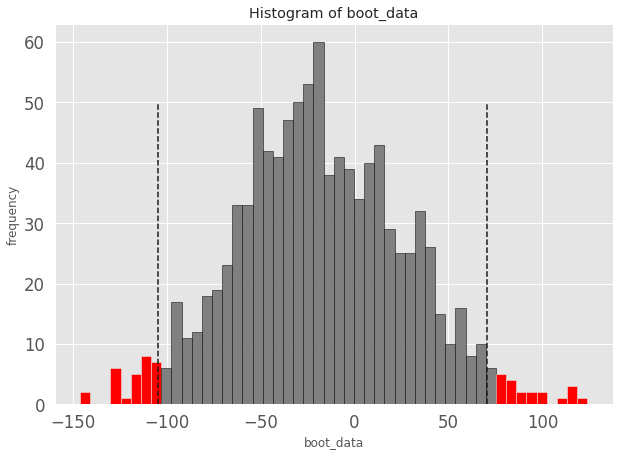

bt_p_value: 0.687
borders_con_interval: 


,0
0.025,-104.410665
0.975,70.470885


p_value_tt: 0.694
p_value_av: 0.694 av_dec: less
p_value_mw: 0.9


In [105]:
np.random.seed(10)

# Так же удаляем выбросы и оставляем 0 потому что левая граница для среза данных содержит 0
uc_1 = users_control_1_m[users_control_1_m.total_revenue > 0]
uc_2 = users_control_2_m[users_control_2_m.total_revenue > 0]

uc_1 = pd.concat([del_outliers(uc_1, "total_revenue"), 
                  users_control_1_m[users_control_1_m.total_revenue == 0]])

uc_2 = pd.concat([del_outliers(uc_2, "total_revenue"), 
                  users_control_2_m[users_control_2_m.total_revenue == 0]])

aa_bt = get_bootstrap(uc_1.total_revenue, uc_2.total_revenue)
aa_tt = get_t_test(uc_1.total_revenue, uc_2.total_revenue)
aa_av = get_anova(uc_1, uc_2, "total_revenue")
aa_mw = get_mannwhitneyu(uc_1.total_revenue, uc_2.total_revenue)

print(f"bt_p_value: {round(aa_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(aa_bt['quants'])

print(f"p_value_tt: {round(aa_tt[0], 3)}")
print(f"p_value_av: {round(aa_av[0], 3)}", f"av_dec: {aa_av[2]}")
print(f"p_value_mw: {round(aa_mw[0], 3)}")

Как мы видим p_value > 0.05 для каждого из тестов и доверительный интервал включает 0, а значит значимые отличий нет, значит можно проводить анализ A/B теста.

A/B тест

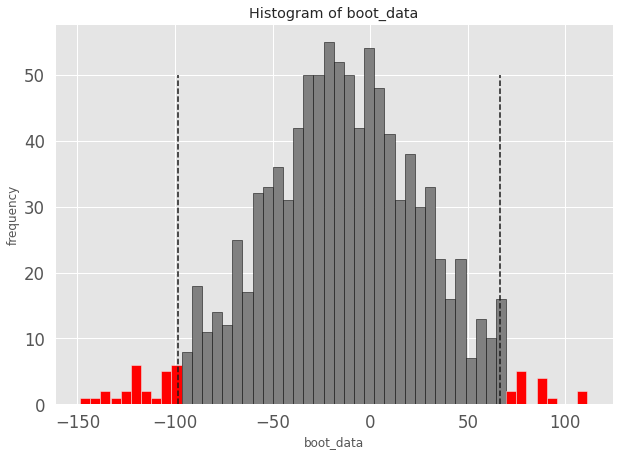

bt_p_value: 0.721
borders_con_interval: 


,0
0.025,-98.552348
0.975,66.512235


p_value_tt: 0.652
p_value_av: 0.695 av_dec: less
p_value_mw: 0.997


In [106]:
np.random.seed(10)

# Так же удаляем выбросы и оставляем 0 потому что левая граница для среза данных содержит 0
ut = users_test_m[users_test_m.total_revenue > 0]
uc = users_control_m[users_control_m.total_revenue > 0]
ut = pd.concat([del_outliers(ut, "total_revenue"), users_test_m[users_test_m.total_revenue == 0]])
uc = pd.concat([del_outliers(uc, "total_revenue"), users_control_m[users_control_m.total_revenue == 0]])

ab_bt = get_bootstrap(uc.total_revenue, ut.total_revenue)
ab_tt = get_t_test(uc.total_revenue, ut.total_revenue, altr="less")
ab_av = get_anova(uc, ut, "total_revenue")
ab_mw = get_mannwhitneyu(uc.total_revenue, ut.total_revenue, altr="less")

print(f"bt_p_value: {round(ab_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(ab_bt['quants'])

print(f"p_value_tt: {round(ab_tt[0], 3)}")
print(f"p_value_av: {round(ab_av[0], 3)}", f"av_dec: {ab_av[2]}")
print(f"p_value_mw: {round(ab_mw[0], 3)}")

Как мы видим p_value > 0.05 для каждого метода и доверительный интервал включает 0, а значит значимых отличий нет, то есть прибыль по ARPU не изменилось.

**2) ARPU(по странам) - средняя выручка на каждого пользователя(в рамках одной страны).**

A/A тест

In [107]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(uc_1, uc_2, 
                               list_of_gr=countries, col="total_revenue")
df_tt = get_res_test_t_test(uc_1, uc_2, countries, "total_revenue")
df_av = get_res_test_anova(uc_1, uc_2, countries, "total_revenue")
df_mw = get_res_test_manwh(uc_1, uc_2, countries, "total_revenue")

multimerge(df_bt, df_tt, df_av, df_mw)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,mw_p_value,mw_has_effect
0,United States of America,0.833575,-154.149216,126.967691,0,0.778261,0,0.778261,0,less,0.620731,0
1,Argentina,0.304924,-447.339524,140.075000,0,0.319459,0,0.319459,0,less,0.492064,0
2,France,0.549518,-434.535522,204.191556,0,0.546967,0,0.546967,0,less,0.601796,0
3,Spain,0.971645,-290.631059,279.595517,0,0.914337,0,0.914337,0,less,0.653639,0
4,Italy,0.853125,-377.170350,306.732544,0,0.890216,0,0.890216,0,less,0.664078,0
5,Chile,0.813193,-333.237957,407.814209,0,0.815520,0,0.815520,0,greater,0.805815,0
6,United Arab Emirates,0.565940,-365.803294,185.632330,0,0.580865,0,0.580865,0,less,0.503571,0
7,Germany,0.501328,-146.753423,355.078971,0,0.497800,0,0.497800,0,greater,0.695206,0
8,United Kingdom (Great Britain),0.541927,-434.190372,832.027194,0,0.558333,0,0.558333,0,greater,0.482471,0
9,Canada,0.345859,-732.677892,240.513020,0,0.311841,0,0.311841,0,less,0.251021,0


Как мы видим, эффектов нет в каждом из тестов кроме Belgium(по mw), поэтому будем анализировать A/B тест.

A/B тест

In [108]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(uc, ut, 
                               list_of_gr=countries, col="total_revenue")
df_tt = get_res_test_t_test(uc, ut, countries, "total_revenue", altr="less")
df_av = get_res_test_anova(uc, ut, countries, "total_revenue")
df_mw = get_res_test_manwh(uc, ut, countries, "total_revenue", altr="less")

multimerge(df_bt, df_tt, df_av, df_mw)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,mw_p_value,mw_has_effect
0,United States of America,0.667508,-113.463599,164.320760,0,0.342106,0,0.684213,0,greater,0.408611,0
1,Argentina,0.070317,-356.575321,19.625834,0,0.944318,0,0.111363,0,less,0.120501,0
2,France,0.817170,-340.431913,276.253545,0,0.597698,0,0.804604,0,less,0.060461,0
3,Spain,0.193625,-95.120343,608.703220,0,0.055763,0,0.111525,0,greater,0.173269,0
4,Italy,0.166483,-451.771171,68.976572,0,0.901011,0,0.197977,0,less,0.065171,0
5,Chile,0.532655,-420.369195,246.080947,0,0.725735,0,0.548529,0,less,0.086303,0
6,United Arab Emirates,0.235775,-121.782286,523.397358,0,0.090688,0,0.181376,0,greater,0.396498,0
7,Germany,0.831519,-202.774543,298.707313,0,0.403031,0,0.806063,0,greater,0.905132,0
8,United Kingdom (Great Britain),0.632886,-582.352935,411.751990,0,0.683840,0,0.632321,0,less,0.595025,0
9,Canada,0.637056,-367.150989,678.399216,0,0.310884,0,0.621767,0,greater,0.971175,0


Эффектов в данном анализе не найдено, соответственно прибыль по ARPU не поменялась для каждой из стран, кроме Portugal(по bt) в меньшую сторону.

**3) ARPPU(в общем) - средняя выручка на каждого пользователя, только среди тех юзеров которые совершают покупки.**

Предобработка датасетов

In [109]:
tr_con_1 = transactions_control_1_m[~transactions_control_1_m.uid.isna()]
tr_con_2 = transactions_control_2_m[~transactions_control_2_m.uid.isna()]
tr_con = transactions_control_m[~transactions_control_m.uid.isna()]
tr_tst = transactions_test_m[~transactions_test_m.uid.isna()]

tr_con_1_gr = tr_con_1.groupby("uid", as_index=False).agg({"revenue": "sum"})
tr_con_2_gr = tr_con_2.groupby("uid", as_index=False).agg({"revenue": "sum"})
tr_con_gr = tr_con.groupby("uid", as_index=False).agg({"revenue": "sum"})
tr_tst_gr = tr_tst.groupby("uid", as_index=False).agg({"revenue": "sum"})

tr_con_1_md = tr_con_1_gr.merge(users_control_1_m, 
                                how="inner", 
                                on="uid")[["uid", "country", "revenue"]]
tr_con_2_md = tr_con_2_gr.merge(users_control_2_m, 
                                how="inner", 
                                on="uid")[["uid", "country", "revenue"]]
tr_con_md = tr_con_gr.merge(users_control_m, 
                            how="inner", 
                            on="uid")[["uid", "country", "revenue"]]
tr_tst_md = tr_tst_gr.merge(users_test_m, 
                            how="inner", 
                            on="uid")[["uid", "country", "revenue"]]

A/A тест

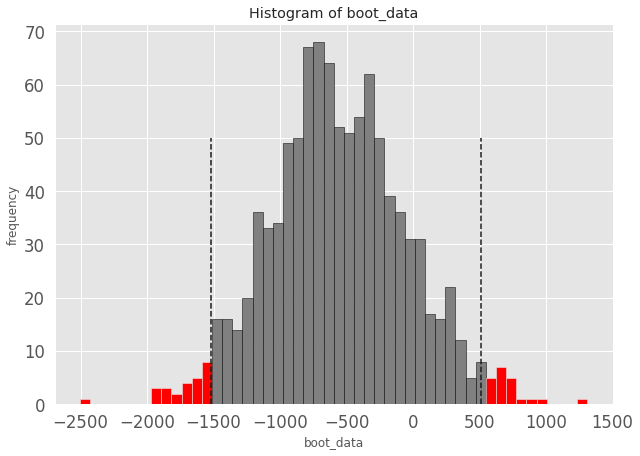

bt_p_value: 0.273
borders_con_interval: 


,0
0.025,-1518.396774
0.975,508.808831


p_value_tt: 0.27
p_value_av: 0.27 av_dec: less
p_value_mw: 0.19


In [110]:
np.random.seed(10)

# Так же удаляем выбросы
tr_con_1_md_o = del_outliers(tr_con_1_md, "revenue")
tr_con_2_md_o = del_outliers(tr_con_2_md, "revenue")

aa_bt = get_bootstrap(tr_con_1_md_o.revenue, tr_con_2_md_o.revenue)
aa_tt = get_t_test(tr_con_1_md_o.revenue, tr_con_2_md_o.revenue)
aa_av = get_anova(tr_con_1_md_o, tr_con_2_md_o, "revenue")
aa_mw = get_mannwhitneyu(tr_con_1_md_o.revenue, tr_con_2_md_o.revenue)

print(f"bt_p_value: {round(aa_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(aa_bt['quants'])

print(f"p_value_tt: {round(aa_tt[0], 3)}")
print(f"p_value_av: {round(aa_av[0], 3)}", f"av_dec: {aa_av[2]}")
print(f"p_value_mw: {round(aa_mw[0], 3)}")

Как мы видим p_value > 0.05 для каждого из тестов и доверительный интервал включает 0, а значит значимые отличий нет, значит можно проводить анализ A/B теста.

A/B тест

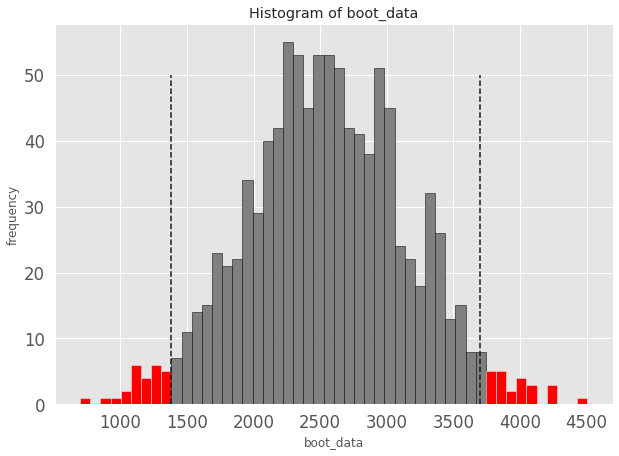

bt_p_value: 0.0
borders_con_interval: 


,0
0.025,1380.430618
0.975,3701.938133


p_value_tt: 0.0
p_value_av: 0.0 av_dec: greater
p_value_mw: 0.0


In [111]:
np.random.seed(10)

# Так же удаляем выбросы
tr_con_md_o = del_outliers(tr_con_md, "revenue")
tr_tst_md_o = del_outliers(tr_tst_md, "revenue")

ab_bt = get_bootstrap(tr_con_md_o.revenue, tr_tst_md_o.revenue)
ab_tt = get_t_test(tr_con_md_o.revenue, tr_tst_md_o.revenue, altr="less")
ab_av = get_anova(tr_con_md_o, tr_tst_md_o, "revenue")
ab_mw = get_mannwhitneyu(tr_con_md_o.revenue, tr_tst_md_o.revenue, altr="less")

print(f"bt_p_value: {round(ab_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(ab_bt['quants'])

print(f"p_value_tt: {round(ab_tt[0], 3)}")
print(f"p_value_av: {round(ab_av[0], 3)}", f"av_dec: {ab_av[2]}")
print(f"p_value_mw: {round(ab_mw[0], 3)}")

Как мы видим p_value < 0.05 для каждого теста и доверительный интервал включает не включает 0, а значит значимые отличия есть, то есть прибыль по ARPPU изменилась и стала больше.

**4) ARPPU(по странам) - средняя выручка на каждого пользователя, только среде тех юзеров которые совершают покупки(в рамках одной страны).**

A/A тест

In [112]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(tr_con_1_md_o, tr_con_2_md_o, 
                               list_of_gr=countries, col="revenue")
df_tt = get_res_test_t_test(tr_con_1_md_o, tr_con_2_md_o, countries, "revenue")
df_av = get_res_test_anova(tr_con_1_md_o, tr_con_2_md_o, countries, "revenue")
df_mw = get_res_test_manwh(tr_con_1_md_o, tr_con_2_md_o, countries, "revenue")

multimerge(df_bt, df_tt, df_av, df_mw)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,mw_p_value,mw_has_effect
0,United States of America,0.075944,-2924.867094,107.715656,0,0.085873,0,0.085873,0,less,0.062724,0
1,Argentina,0.279308,-5951.065972,1610.564583,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.135212,0
2,France,0.796880,-3716.559270,2687.216627,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.675361,0
3,Spain,0.142763,-5992.407778,974.277778,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.092723,0
4,Italy,0.401222,-5781.100000,2072.281250,0,0.387606,0,0.387606,0,less,0.597645,0
5,Chile,0.915511,-5010.362500,5334.635682,0,0.966119,0,0.966119,0,greater,1.000000,0
6,United Arab Emirates,0.831130,-3616.166667,4788.468750,0,0.862991,0,0.862991,0,greater,0.667916,0
7,Germany,0.008580,1836.802500,10296.487500,1,0.034122,1,0.034122,1,greater,0.049090,1
8,United Kingdom (Great Britain),0.892585,-4800.398571,4718.818929,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.431846,0
9,Canada,0.937751,-5358.518750,5020.031250,0,0.943155,0,0.943155,0,less,1.000000,0


Как мы видим что в целом эффектов нет кроме Germany, поэтому все равно будем анализировать A/B тест.

A/B тест

In [113]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(tr_con_md_o, tr_tst_md_o, 
                               list_of_gr=countries, col="revenue")
df_tt = get_res_test_t_test(tr_con_md_o, tr_tst_md_o, countries, "revenue", altr="less")
df_av = get_res_test_anova(tr_con_md_o, tr_tst_md_o, countries, "revenue")
df_mw = get_res_test_manwh(tr_con_md_o, tr_tst_md_o, countries, "revenue", altr="less")

multimerge(df_bt, df_tt, df_av, df_mw)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,mw_p_value,mw_has_effect
0,United States of America,0.015423,405.683937,4127.080542,1,0.0033,1,0.006601,1,greater,0.003275,1
1,Argentina,0.558170,-4844.480952,2371.292857,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1,0
2,France,0.000792,2505.191599,9644.840041,1,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.00275,1
3,Spain,0.462016,-2483.660996,5507.310714,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.756396,0
4,Italy,0.667816,-3589.300000,5565.960156,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.799717,0
5,Chile,0.101632,-1295.945238,17415.310714,0,0.126202,0,0.252404,0,greater,0.194224,0
6,United Arab Emirates,0.124272,-706.135625,5946.768750,0,0.07985,0,0.1597,0,greater,0.208043,0
7,Germany,0.800737,-4884.887222,6160.057222,0,0.404278,0,0.808557,0,greater,0.94673,0
8,United Kingdom (Great Britain),0.941076,-5096.284375,4893.352941,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.883963,0
9,Canada,0.334379,-2650.916667,8153.600000,0,0.169448,0,0.338897,0,greater,0.398049,0


Как мы видим что в целом эффектов нет кроме United States of America, France, Belgium, Israel и Australia именно эти странны стали приносить больше денег по ARPPU, особенно France и Israel, так как левая граница сильно сдвинута в плюс.

**5) Конверсия в покупку.**

A/A тест.

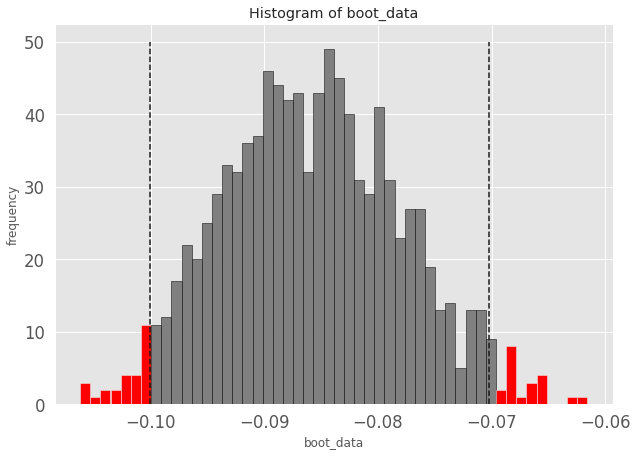

bt_p_value: 0.0
borders_con_interval: 


,0
0.025,-0.100111
0.975,-0.070237


p_value_pz: 0.029


In [114]:
np.random.seed(10)

o_data_1 = transactions_control_1_m.uid.count()
n_data_1 = users_control_1_m.uid.nunique()
vl = transactions_control_2_m.uid.count() / users_control_2_m.uid.nunique()


aa_bt = get_bootstrap(users_control_1_m, transactions_control_1, 
                      users_control_2_m, transactions_control_2, 
                      boot_it=1000, bootstrap_conf_level=0.95)

aa_pz = get_proportions_ztest(o_data_1, n_data_1, vl)

print(f"bt_p_value: {round(aa_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(aa_bt['quants'])

print(f"p_value_pz: {round(aa_pz[0], 3)}")

Как мы видим p_value < 0.05 и доверительный интервал не включает 0, а значит значимые отличия есть, значит в плане конверсий что-то не так с данными группами.

**6) Конверсия в покупку по странам.**

A/A тест.

In [115]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(users_control_1_m, transactions_control_1_m, 
                               users_control_2_m, transactions_control_2_m,
                               list_of_gr=countries)
df_pz = get_res_test_prop_ztst(users_control_1_m, transactions_control_1_m,
                               users_control_2_m, transactions_control_2_m,
                               list_of_gr=countries)

multimerge(df_bt, df_pz)

,country,bt_p_value,0.025,0.0975,bt_has_effect,pz_p_value,pz_has_effect
0,United States of America,2.609724e-16,-0.088429,-0.054580,1,0.879923,0
1,Argentina,1.382465e-03,-0.106842,-0.029409,1,0.048747,1
2,France,8.417202e-06,-0.145301,-0.057765,1,0.006142,1
3,Spain,2.848329e-04,-0.061328,-0.018347,1,0.000171,1
4,Italy,3.760411e-03,-0.302911,-0.064661,1,0.000167,1
5,Chile,5.692884e-05,-0.076097,-0.025975,1,0.265227,0
6,United Arab Emirates,9.373354e-03,-0.091603,-0.015382,1,0.067612,0
7,Germany,1.296738e-02,-0.060345,-0.008403,1,0.871475,0
8,United Kingdom (Great Britain),8.800474e-03,-0.310345,-0.043467,1,0.043215,1
9,Canada,8.776290e-04,-0.158537,-0.037026,1,0.026288,1


Как и ожидалось, p_value < 0.05 и доверительный интервал не включает 0 для бутстрапа для каждой из стран, кроме Portugal, а значит значимые отличия есть, значит в плане конверсий что-то не так с данными группами. Но тест pz выделил только 8 стран с эффектом. Все таки проведем анализ A/B теста.

A/B тест

In [116]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(users_control_m, transactions_control_m,
                               users_test_m, transactions_test_m,
                               list_of_gr=countries)
df_pz = get_res_test_prop_ztst(users_control_m, transactions_control_m,
                               users_test_m, transactions_test_m,
                               list_of_gr=countries, altr="smaller")

multimerge(df_bt, df_pz)

,country,bt_p_value,0.025,0.0975,bt_has_effect,pz_p_value,pz_has_effect
0,United States of America,3.885089e-29,-0.084729,-0.059139,1,0.924583,0
1,Argentina,1.092523e-05,-0.082000,-0.032585,1,0.999965,0
2,France,9.712242e-10,-0.108571,-0.057082,1,0.102277,0
3,Spain,1.278308e-04,-0.083538,-0.031175,1,0.006613,1
4,Italy,3.892288e-05,-0.223671,-0.086726,1,1.000000,0
5,Chile,2.326390e-07,-0.081301,-0.036305,1,0.932059,0
6,United Arab Emirates,3.196488e-04,-0.064004,-0.019157,1,0.165407,0
7,Germany,2.214193e-04,-0.054399,-0.016461,1,0.354968,0
8,United Kingdom (Great Britain),1.834420e-04,-0.247253,-0.078115,1,0.999998,0
9,Canada,3.794083e-05,-0.109091,-0.037494,1,0.370064,0


Если посмотреть на две таблицы сверху, то несмотря на то что слишком много групп не прошло A/A тест(особенно по бутстрапу), в A/B тесте в целом тенденция показывает что конверсия упала, особенно подметить страны Australia и Israel(по pz).

**7) RPR(в общем) - доля клиентов, которые совершают покупки более одного раза в общем.**

Предобработка данных

In [117]:
tr_con_1_g = tr_con_1.groupby("uid", as_index=False).agg({"revenue": "count"})
tr_con_1_g["rep_payment"] = (tr_con_1_g["revenue"] > 1).astype(int)
tr_con_1_g_r = tr_con_1_g.merge(tr_con_1, on="uid", how="inner")[["uid", "country", "rep_payment"]]

tr_con_2_g = tr_con_2.groupby("uid", as_index=False).agg({"revenue": "count"})
tr_con_2_g["rep_payment"] = (tr_con_2_g["revenue"] > 1).astype(int)
tr_con_2_g_r = tr_con_2_g.merge(tr_con_2, on="uid", how="inner")[["uid", "country", "rep_payment"]]

tr_con_g = tr_con.groupby("uid", as_index=False).agg({"revenue": "count"})
tr_con_g["rep_payment"] = (tr_con_g["revenue"] > 1).astype(int)
tr_con_g_r = tr_con_g.merge(tr_con, on="uid", how="inner")[["uid", "country", "rep_payment"]]

tr_tst_g = tr_tst.groupby("uid", as_index=False).agg({"revenue": "count"})
tr_tst_g["rep_payment"] = (tr_tst_g["revenue"] > 1).astype(int)
tr_tst_g_r = tr_tst_g.merge(tr_tst, on="uid", how="inner")[["uid", "country", "rep_payment"]]

A/A тест

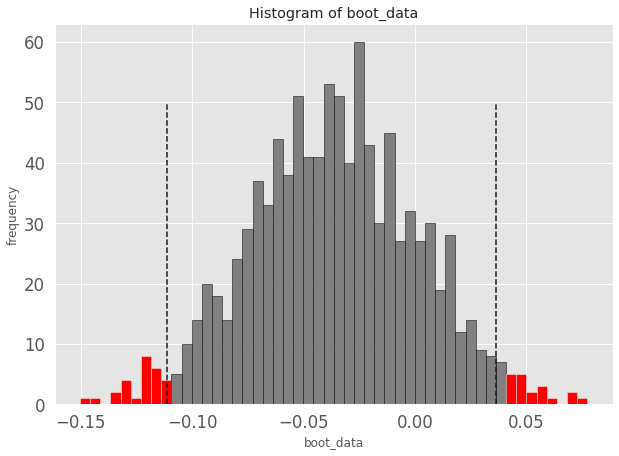

bt_p_value: 0.331
borders_con_interval: 


,0
0.025,-0.111299
0.975,0.036553


p_value_tt: 0.311
p_value_av: 0.311 av_dec: less
p_value_ch: 0.349 ch_dec: less
p_value_pz: 0.132


In [118]:
np.random.seed(10)

aa_bt = get_bootstrap(tr_con_1_g_r.rep_payment, tr_con_2_g_r.rep_payment)
aa_tt = get_t_test(tr_con_1_g_r.rep_payment, tr_con_2_g_r.rep_payment)
aa_av = get_anova(tr_con_1_g_r, tr_con_2_g_r, "rep_payment")
aa_ch = get_chisquare(tr_con_1_g_r.rep_payment, tr_con_2_g_r.rep_payment)
aa_pz = get_proportions_ztest(tr_con_1_g_r.rep_payment, tr_con_2_g_r.rep_payment)

print(f"bt_p_value: {round(aa_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(aa_bt['quants'])

print(f"p_value_tt: {round(aa_tt[0], 3)}")
print(f"p_value_av: {round(aa_av[0], 3)}", f"av_dec: {aa_av[2]}")
print(f"p_value_ch: {round(aa_ch[0], 3)}", f"ch_dec: {aa_ch[2]}")
print(f"p_value_pz: {round(aa_pz[0], 3)}")

Как мы видим p_value > 0.05 для каждого из тестов и доверительный интервал включает 0, а значит значимые отличий нет, значит можно проводить анализ A/B теста.

A/B тест

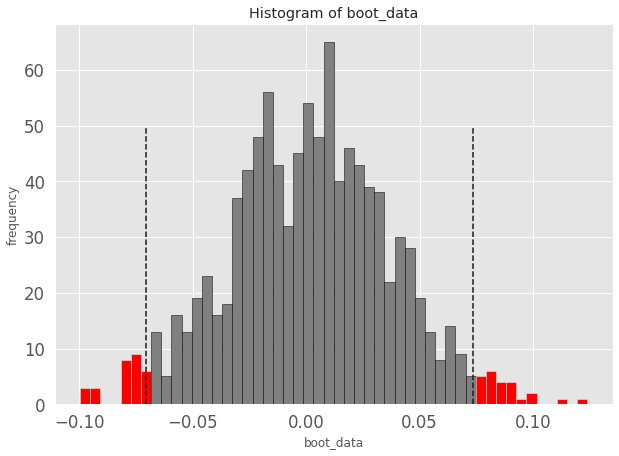

bt_p_value: 0.961
borders_con_interval: 


,0
0.025,-0.070820
0.975,0.073355


p_value_tt: 0.464
p_value_av: 0.928 av_dec: greater
p_value_ch: 0.988 ch_dec: greater
p_value_pz: 0.432


In [119]:
np.random.seed(10)

ab_bt = get_bootstrap(tr_con_g_r.rep_payment, tr_tst_g_r.rep_payment)
ab_tt = get_t_test(tr_con_g_r.rep_payment, tr_tst_g_r.rep_payment, altr="less")
ab_av = get_anova(tr_con_g_r, tr_tst_g_r, "rep_payment")
ab_ch = get_chisquare(tr_con_g_r.rep_payment, tr_tst_g_r.rep_payment)
ab_pz = get_proportions_ztest(tr_con_g_r.rep_payment, tr_tst_g_r.rep_payment, altr="smaller")

print(f"bt_p_value: {round(ab_bt['bt_p_value'], 3)}")
print("borders_con_interval: ")
display(ab_bt['quants'])

print(f"p_value_tt: {round(ab_tt[0], 3)}")
print(f"p_value_av: {round(ab_av[0], 3)}", f"av_dec: {ab_av[2]}")
print(f"p_value_ch: {round(ab_ch[0], 3)}", f"ch_dec: {ab_ch[2]}")
print(f"p_value_pz: {round(ab_pz[0], 3)}")

Как мы видим p_value > 0.05 для каждого из тестов и доверительный интервал включает 0, а значит значимые отличий нет, значит RPR остался тот же и больше повторных покупок не стало.

**8) RPR(по странам) - доля клиентов, которые совершают покупки более одного раза по странам.**

A/A тест

In [120]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(tr_con_1_g_r, tr_con_2_g_r, 
                               list_of_gr=countries, col="rep_payment")
df_tt = get_res_test_t_test(tr_con_1_g_r, tr_con_2_g_r, countries, "rep_payment")
df_av = get_res_test_anova(tr_con_1_g_r, tr_con_2_g_r, countries, "rep_payment")
df_ch = get_res_test_chisq(tr_con_1_g_r, tr_con_2_g_r, countries, "rep_payment")
df_pz = get_res_test_prop_ztst(tr_con_1_g_r, tr_con_2_g_r, list_of_gr=countries, col="rep_payment")

multimerge(df_bt, df_tt, df_av, df_ch, df_pz)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,ch_p_value,ch_has_effect,ch_dec,pz_p_value,pz_has_effect
0,United States of America,0.454641,-0.172230,0.083489,0,0.473495,0,0.473495,0,less,0.561082,0,less,0.305602,0
1,Argentina,0.576424,-0.357143,0.194444,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.781678,0,less,0.308512,0
2,France,0.014688,-0.544231,-0.068004,1,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.035444,1,less,0.000065,1
3,Spain,0.991783,-0.314286,0.331643,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1.000000,0,less,0.982200,0
4,Italy,0.188257,-0.272727,0.045455,0,0.190838,0,0.190838,0,less,0.300008,0,less,0.012046,1
5,Chile,0.804253,-0.287719,0.347456,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1.000000,0,greater,0.802855,0
6,United Arab Emirates,0.311711,-0.666667,0.250000,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.617075,0,less,0.078983,0
7,Germany,0.969207,-0.571429,0.571429,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1.000000,0,less,1.000000,0
8,United Kingdom (Great Britain),0.572718,-0.316667,0.166667,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.843486,0,less,0.387955,0
9,Canada,0.490069,-0.309524,0.619048,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.844482,0,greater,0.212317,0


Как мы видим что в целом эффектов нет кроме France, Belgium, Israel, Australia, Italy и Switzerland, поэтому все равно будем анализировать A/B тест так как их меньшество.

A/B тест

In [121]:
np.random.seed(10)

df_bt = get_res_test_bootstrap(tr_con_g_r, tr_tst_g_r,
                               list_of_gr=countries, col="rep_payment")
df_tt = get_res_test_t_test(tr_con_g_r, tr_tst_g_r, countries, "rep_payment", altr="less")
df_av = get_res_test_anova(tr_con_g_r, tr_tst_g_r, countries, "rep_payment")
df_ch = get_res_test_chisq(tr_con_g_r, tr_tst_g_r, countries, "rep_payment")
df_pz = get_res_test_prop_ztst(tr_con_g_r, tr_tst_g_r, list_of_gr=countries, 
                               col="rep_payment", altr="smaller")

multimerge(df_bt, df_tt, df_av, df_ch, df_pz)

,country,bt_p_value,0.025,0.0975,bt_has_effect,tt_p_value,tt_has_effect,av_p_value,av_has_effect,av_dec,ch_p_value,ch_has_effect,ch_dec,pz_p_value,pz_has_effect
0,United States of America,0.601052,-0.093138,0.157397,0,0.299489,0,0.598977,0,greater,0.687898,0,greater,0.171309,0
1,Argentina,0.188180,-0.517391,0.104348,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.336779,0,less,0.999471,0
2,France,0.005719,0.072035,0.446869,1,0.004156,1,0.008311,1,greater,0.02098,1,greater,0.000015,1
3,Spain,0.750590,-0.209513,0.272897,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.959667,0,greater,0.305941,0
4,Italy,0.415433,-0.298485,0.111629,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.612287,0,less,0.980554,0
5,Chile,0.124376,-0.063848,0.446691,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.311477,0,greater,0.004827,1
6,United Arab Emirates,0.661461,-0.444444,0.277778,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.940452,0,less,0.760250,0
7,Germany,0.405842,-0.571429,0.267857,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.706242,0,less,0.911517,0
8,United Kingdom (Great Britain),0.118250,-0.530417,0.090000,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,0.203789,0,less,0.999945,0
9,Canada,0.952006,-0.377273,0.368182,0,can't estimate,can't estimate,can't estimate,can't estimate,can't estimate,1,0,less,0.516296,0


Как мы видим что в целом эффектов нет кроме France, но эту подгруппу лучше исключть так как с ней что-то не то было в A/A тесте и тестовых данных по транзакциям после обработки по Portugal не оказалось, соответственно RPR у нас не вырос и повторных покупок больше не стало по каждой из стран. Но есть страна в которых повторных покупок стало меньше: United Kingdom (Great Britain). 

# Выводы

**То что интересует из EDA:**

1) Основная аудитория приложения это люди с средним возрастом 31-32 год, преимущественно мужчины, страна с которой больше всего платящих и обычных юзеров из USA.
<br/>
2) Примерно с 60 % стран приложение не имеет прибыли.
<br/>
3) Топ 2 источника откуда люди перешли на страницу оплаты empty_likes, trial_vip_popup.
<br/>
4) Слишком мало людей имели(10%) и имеют(4%) премиумы.
<br/>
5) В приложение обычно заходят только 1 раз.

**По детальному анализу:**

#### По части 1

Было сформировано 6 гипотез. Почти во всех гипотезах которые мы построили пришлось принять гипотезу H0, так как эффектов почти нигде не было. Есть отдельные страны такие как Portugal, где выяснилось что там скорее предпочитают продлевать премиумы. При этом в целом доля клиентов у которых был и остался премиум упала. При всем при этом люди из Australia и Switzerland предпочитают продлевать premium_no_trial. Так же приложение посещать чаще не стали. Несмотря на маленькие успехи, сложно сказать что эксперимент оказался удачным, скорее на нем потеряли деньги, хотя все зависит от того сколько в него вложили.

#### По части 2

Было сформировано 8 гипотез. Тут немного получше. Несмотря на то, что ARPU был значим и показывал отрицательную прибыль по ARPU, конверсия в покупку не стала больше и люди не охотно совершают повторные покупки, прибыль по ARPPU в общем стала прилично больше особенно для стран United States of America, France, Belgium, Israel и Australia. Тут скорее эксперимент можно назвать удачным чем нет, хотя все зависит от того в какие деньги он обошелся компании.

**Вывод для бизнеса:**

- В A/A/B тесте вышло явно поднять выручку за счет изменения стоимости на премиум аккаунты с каждого клиента, особенно для стран United States of America, France, Belgium, Israel и Australia, хотя конверсия людей в покупку уменьшилась(особенно для стран Australia и Israel). Приобретать премиумы стали чаще в Australia, Switzerland, United States of America, France, Spain, Italy и Chile. В United Kingdom (Great Britain) количество повторных покупок уменьшилось, в остальных группах осталось также. Если резюмировать вышесказанное, то изменив стоимость преимиумов мы уменьшили лояльность юзеров приложения и начали работать на прибыль текущих клиентов, которые лояльны приложению несмотря на изменения. Предлагается ограничится изменением цены только для стран United States of America, France, Belgium, Israel и Australia, а для остольных стран оставить пока прежние цены. 
<br/>
- Также как было сказано в работе менять цену на премиумы не стоит по полу, возрасту, так как люди могут подделать на выгодный себе пол и возраст и в целом измененная цена может быть воспринята как дискриминация по данным признакам, что может сильно уменьшить лояльность юзеров к приложению и оттоку, даже проведение нового A/B связанно с этими признаками очень рискованная. По страницы по которой клиент решил преобрести покупку, можно делать только может быть скидки, но не менять цену на постоянной основе, так как люди будут друг другу скидывать эти ссылки друг другу и приобретать премиумы дешевле и/или это может восприниматься как ценовая дискриминация и тоже может привести к падению лояльности юзеров и даже оттоку.
<br/>
- Также стоит обратить внимание на те 60 % стран(список выше в EDA) в которых покупки не происходили за данный период вообще, от них лучше отключить приложение для экономии ресурсов, либо простимулировать их пользоваться премиумами, например попробовать увеличить длительность триал периода для премиумов, чтобы развить првычку удобства данного продукта.
